In [269]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
from sklearn.svm import SVC 

In [197]:
phnompenh_lulc = gpd.read_file('./eo4sd_phnom_penh_lulcvhr_2017/EO4SD_PHNOM_PENH_LULCVHR_2017.shp')
phnompenh_lulc.head(2)

,C_L4,N_L4,C_L3,N_L3,C_L2,N_L2,C_L1,N_L1,AREA,ID,geometry
0,11220,Discontinuous medium density urban fabric (10 ...,11200,Discontinuous Urban Fabric (Sealing level: 10%...,11000,Urban Fabric,10000,Artificial Surfaces,1590.437,1,"POLYGON ((484091.269 1286418.159, 484091.269 1..."
1,12110,Commercial and Industrial units,12100,"Industrial, Commercial, Public, Military and P...",12000,"Industrial, Commercial, Public, Military, Priv...",10000,Artificial Surfaces,6349.577,2,"POLYGON ((483875.490 1286062.818, 483875.903 1..."


In [198]:
# All Meta Data of the shape file
phnompenh_lulc_crs = phnompenh_lulc.crs
print('Shape data file crs = ',phnompenh_lulc_crs)

Shape data file crs =  EPSG:32648


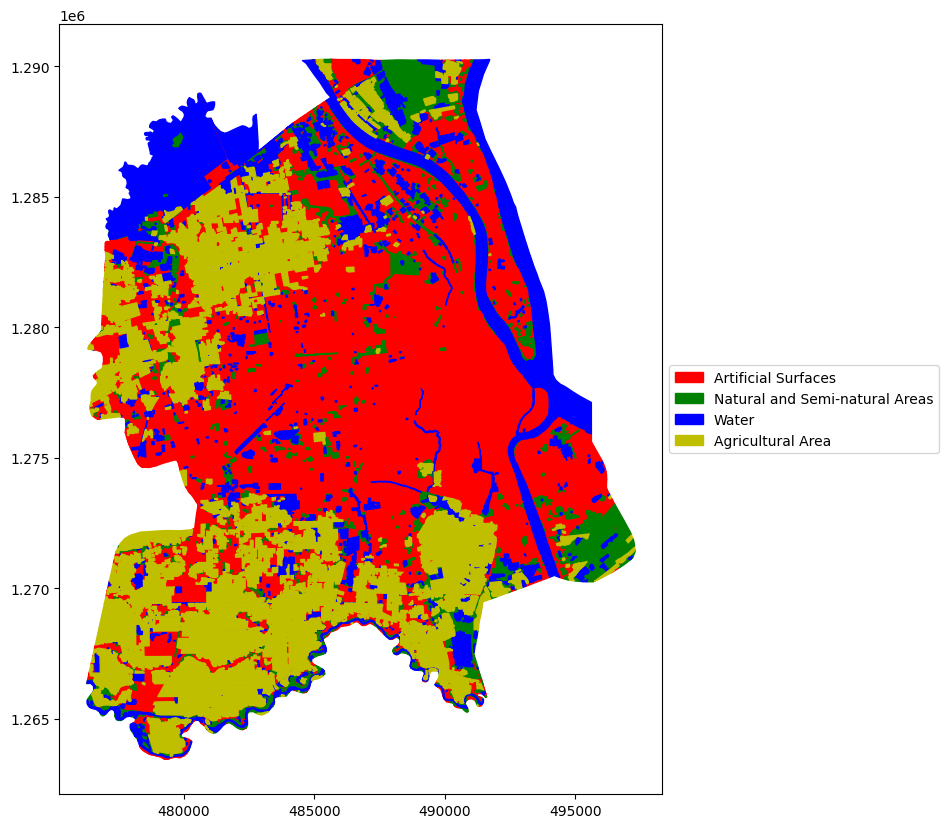

In [199]:
#Visulaize the polygons in the shape file
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 10))

artSurf = phnompenh_lulc[phnompenh_lulc['N_L1'] == 'Artificial Surfaces']
natSemNat = phnompenh_lulc[phnompenh_lulc['N_L1'] == 'Natural and Semi-natural Areas']
water = phnompenh_lulc[phnompenh_lulc['N_L1'] == 'Water']
AgrArea = phnompenh_lulc[phnompenh_lulc['N_L1'] == 'Agricultural Area']

# Plot each class as a separate plot with the specified color
artSurf.plot( ax=ax, color = 'r', categorical=True, edgecolor="face", linewidth=1)
natSemNat.plot( ax=ax, color = 'g', categorical=True, edgecolor="face", linewidth=1)
water.plot( ax=ax, color = 'b', categorical=True, edgecolor="face", linewidth=1)
AgrArea.plot( ax=ax, color = 'y', categorical=True, edgecolor="face", linewidth=1)

# Create a legend for each class with the specified color
red_patch = mpatches.Patch(color='r', label='Artificial Surfaces')
green_patch = mpatches.Patch(color='g', label='Natural and Semi-natural Areas')
blue_patch = mpatches.Patch(color='b', label='Water')
yellow_patch = mpatches.Patch(color='y', label='Agricultural Area')

# Add the legend to the plot
plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch],  loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [230]:
artSurf_sortby_area =  artSurf.sort_values(by=['AREA'], ascending=False)
natSemNat_sortby_area = natSemNat.sort_values(by=['AREA'], ascending=False)
water_sortby_area = water.sort_values(by=['AREA'], ascending=False)
AgrArea_sortby_area = AgrArea.sort_values(by=['AREA'], ascending=False)

artSurf_sortby_area_small = artSurf_sortby_area.iloc[ :100] 
natSemNat_sortby_area_small = natSemNat_sortby_area.iloc[:100]
water_sortby_area_small = water_sortby_area.iloc[:100]
AgrArea_sortby_area_small = AgrArea_sortby_area.iloc[:100]
# AgrArea_sortby_area_small.iloc[[0]].bounds

water_sortby_area_small.C_L1 = 40000

cols = ['C_L1','ID', 'geometry']
combinedPolygons = pd.concat([artSurf_sortby_area_small, natSemNat_sortby_area_small,water_sortby_area_small,AgrArea_sortby_area_small ])
combinedPolygons = combinedPolygons[cols]

C:\Users\riyad\anaconda3\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [247]:
import geopandas as gpd
import shapely.geometry as geometry
import random
# polygons = combinedPolygons

points = []
c_ls = []
polygon_ids = []
num_points = 15
for idx in tqdm(range(0,len(combinedPolygons))):
    polygon_geom = combinedPolygons['geometry'].iloc[idx]
    polygon_cl1 = combinedPolygons['C_L1'].iloc[idx]
    polygon_id = combinedPolygons['ID'].iloc[idx]

    polygon_poly = geometry.Polygon(polygon_geom)
    point_this_pol = 0
    
    while point_this_pol < num_points:
        # Generate a random point within the bounding box of the polygon
        point = geometry.Point([random.uniform(polygon_poly.bounds[0], polygon_poly.bounds[2]),
                                 random.uniform(polygon_poly.bounds[1], polygon_poly.bounds[3])])
        # Check if the point is within the polygon
        if polygon_poly.contains(point):
            points.append(point)
            c_ls.append(int(polygon_cl1/10000))
            polygon_ids.append(polygon_id)
            point_this_pol = point_this_pol + 1       
            
points_gdf = gpd.GeoDataFrame(geometry=points)

points_gdf = points_gdf.rename(columns={"index":"ID"})
points_gdf['ID'] = points_gdf.index 

points_gdf.crs = phnompenh_lulc.crs


points_gdf['C_L1'] = c_ls
points_gdf['PolygonID'] = polygon_ids

points_gdf.to_file('Random Points inside Polygons', driver='ESRI Shapefile', crs=points_gdf.crs)

100%|██████████| 400/400 [00:11<00:00, 33.74it/s] 


In [248]:
points_gdf

,geometry,ID,C_L1,PolygonID
0,POINT (490681.656 1277436.801),0,1,19994
1,POINT (488193.990 1278585.602),1,1,19994
2,POINT (492222.510 1275298.278),2,1,19994
3,POINT (480582.783 1273854.786),3,1,19994
4,POINT (492467.474 1274631.759),4,1,19994
...,...,...,...,...
5995,POINT (481040.510 1272187.309),5995,2,11706
5996,POINT (481088.097 1272137.439),5996,2,11706
5997,POINT (480910.585 1271639.570),5997,2,11706
5998,POINT (480945.151 1272137.798),5998,2,11706


In [251]:
# Read the local tif files

#Put the path to the folder where the Sentinel-2 image is stored.
filepath="./PH_AOI_S2Bands/" 

NumOfClasses=len(points_gdf.C_L1.unique())
print('Number of Classes: ',NumOfClasses)
UniqueClasses = points_gdf.C_L1.unique()

#This list will store the numpy form of the satellite images.
S2Image=[]
transform = ()
#List of band names that we want to use.
BandNames=["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"]
#The number of bands.
NumOfBands=len(BandNames)

#Read and store the each band as a numpy array.
for Band in tqdm(BandNames):
    ReadBand=rio.open(filepath+f"20210331T031541_20210331T032710_T48PVT_{Band}.tif")
    ReadBandArray=ReadBand.read(1)
    S2Image.append(ReadBandArray)
    transform = ReadBand.transform

Number of Classes:  4


100%|██████████| 12/12 [00:02<00:00,  4.61it/s]


In [252]:
S2Image

[array([[ 883,  881,  878, ..., 1157, 1151, 1145],
        [ 877,  874,  871, ..., 1153, 1146, 1139],
        [ 879,  874,  870, ..., 1147, 1138, 1128],
        ...,
        [ 897,  927,  984, ...,  658,  660,  661],
        [ 901,  933,  996, ...,  660,  661,  662],
        [ 901,  933,  999, ...,  660,  660,  661]], dtype=uint16),
 array([[1382, 1148,  929, ..., 1224, 1160, 1154],
        [1346, 1062,  828, ..., 1340, 1304, 1288],
        [1106,  927,  797, ..., 1318, 1334, 1342],
        ...,
        [1032, 1036, 1014, ...,  619,  617,  646],
        [ 905,  968, 1003, ...,  613,  592,  633],
        [1124, 1188, 1106, ...,  615,  617,  637]], dtype=uint16),
 array([[1996, 1484, 1324, ..., 1520, 1450, 1450],
        [1898, 1446, 1210, ..., 1742, 1664, 1644],
        [1556, 1406, 1098, ..., 1710, 1704, 1726],
        ...,
        [1340, 1350, 1380, ...,  913,  953,  964],
        [1340, 1340, 1394, ...,  833,  826,  827],
        [1680, 1690, 1522, ...,  850,  861,  813]], dtype=uint

In [253]:
N=len(points_gdf["C_L1"])

#This list will store the spectrum information at each training point.
spectrum_data=[]

for n in tqdm(range(N)):
    point = points_gdf.iloc[n]
    row, col = rio.transform.rowcol(transform, point.geometry.x, point.geometry.y)
    spectrum_data_at_xy=[]
#     print(row,col)
    
    for band in S2Image:
        spectrum_data_at_xy.append(band[row,col])
    spectrum_data.append(spectrum_data_at_xy)
        
points_gdf["Spectrum_data"]=spectrum_data

100%|██████████| 6000/6000 [00:06<00:00, 935.51it/s] 


In [254]:
points_gdf

,geometry,ID,C_L1,PolygonID,Spectrum_data
0,POINT (490681.656 1277436.801),0,1,19994,"[1194, 865, 1023, 1200, 1632, 1852, 2049, 1870..."
1,POINT (488193.990 1278585.602),1,1,19994,"[1224, 927, 1074, 1148, 1764, 2036, 2124, 1526..."
2,POINT (492222.510 1275298.278),2,1,19994,"[1149, 1002, 1144, 1188, 1613, 1852, 1980, 172..."
3,POINT (480582.783 1273854.786),3,1,19994,"[1753, 1722, 1958, 2170, 2207, 2482, 2550, 195..."
4,POINT (492467.474 1274631.759),4,1,19994,"[1245, 1036, 1166, 1276, 1498, 1467, 1501, 133..."
...,...,...,...,...,...
5995,POINT (481040.510 1272187.309),5995,2,11706,"[1627, 830, 1200, 904, 1975, 3645, 4269, 4684,..."
5996,POINT (481088.097 1272137.439),5996,2,11706,"[1385, 2688, 3348, 3520, 3530, 4000, 4136, 368..."
5997,POINT (480910.585 1271639.570),5997,2,11706,"[1610, 2254, 2920, 3530, 3689, 3833, 3970, 412..."
5998,POINT (480945.151 1272137.798),5998,2,11706,"[2028, 2534, 1438, 1316, 1405, 1459, 2079, 285..."


In [255]:
trainData=[]
trainLabel=[]
testData=[]
testLabel=[]

for i in tqdm(range(1,NumOfClasses+1)):
#     print(i)
    Data_class_i=points_gdf[points_gdf["C_L1"]==i]["Spectrum_data"]
    Labels_class_i=points_gdf[points_gdf["C_L1"]==i]["C_L1"]
    
    Data_train, Data_test, Label_train, Label_test = train_test_split(Data_class_i, Labels_class_i, test_size=0.2)
    
    trainData.extend(Data_train)
    trainLabel.extend(Label_train)
    testData.extend(Data_test)
    testLabel.extend(Label_test)


trainData=np.array(trainData)
testData=np.array(testData)
trainLabel=np.array(trainLabel)
testLabel=np.array(testLabel)

100%|██████████| 4/4 [00:00<00:00, 185.51it/s]

1
2
3
4


In [256]:
trainData=np.array(trainData)
testData=np.array(testData)
trainLabel=np.array(trainLabel)
testLabel=np.array(testLabel)

In [239]:
testLabel

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [267]:
#Neural Network
#Two hidden layers with 250 nodes each.
#Two dropout layers were added to reduce the overfitting problems.

trainData_NN=np.array(trainData)
testData_NN=np.array(testData)
trainLabel_NN=keras.utils.to_categorical(trainLabel)
testLabel_NN=keras.utils.to_categorical(testLabel)

model=Sequential()
model.add(Dense(250,activation="relu",input_dim=12))
model.add(Dropout(0.1))
model.add(Dense(250,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(5,activation="softmax"))

adam=Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",optimizer=adam,metrics=["accuracy"])

model.fit(trainData_NN,trainLabel_NN,epochs=500,batch_size=150,verbose=0)
loss,acc=model.evaluate(testData_NN,testLabel_NN)
print("The classification accuracy is {:.4f}".format(acc))

38/38 [==============================] - 0s 1ms/step - loss: 1.0027 - accuracy: 0.5658
The classification accuracy is 0.5658


In [273]:
# model.predict_classes

In [279]:
predicted_LULC_NN=[]
column_length=S2Image[0].shape[1]

for i in tqdm(range(S2Image[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(NumOfBands):
        spectrum_data_at_row_i.append(S2Image[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class = np.argmax(model.predict(spectrum_data_at_row_i_T),axis=1 ) 
    predicted_LULC_NN.append(predicted_class)

predicted_LULC_NN=np.array(predicted_LULC_NN).astype(np.uint8)

  0%|          | 0/3638 [00:00<?, ?it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 1/3638 [00:00<21:58,  2.76it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 2/3638 [00:00<25:38,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 3/3638 [00:01<24:03,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


  0%|          | 4/3638 [00:01<26:46,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 5/3638 [00:02<26:11,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 6/3638 [00:02<24:02,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 7/3638 [00:02<22:14,  2.72it/s]

133/133 [==============================] - 0s 1ms/step


  0%|          | 8/3638 [00:03<20:24,  2.96it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 9/3638 [00:03<19:27,  3.11it/s]

133/133 [==============================] - 0s 1ms/step


  0%|          | 10/3638 [00:03<18:28,  3.27it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 11/3638 [00:03<20:13,  2.99it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 12/3638 [00:04<22:00,  2.75it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 13/3638 [00:04<20:48,  2.90it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 14/3638 [00:05<20:34,  2.94it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 15/3638 [00:05<20:00,  3.02it/s]

133/133 [==============================] - 0s 1ms/step


  0%|          | 16/3638 [00:05<19:28,  3.10it/s]

133/133 [==============================] - 0s 2ms/step


  0%|          | 17/3638 [00:05<18:46,  3.21it/s]

133/133 [==============================] - 0s 1ms/step


  0%|          | 18/3638 [00:06<17:45,  3.40it/s]

133/133 [==============================] - 0s 1ms/step


  1%|          | 19/3638 [00:06<16:34,  3.64it/s]

133/133 [==============================] - 0s 1ms/step


  1%|          | 20/3638 [00:06<16:33,  3.64it/s]

133/133 [==============================] - 0s 1ms/step


  1%|          | 21/3638 [00:06<16:20,  3.69it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 22/3638 [00:07<18:22,  3.28it/s]

133/133 [==============================] - 0s 1ms/step


  1%|          | 23/3638 [00:07<17:32,  3.43it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 24/3638 [00:08<19:48,  3.04it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 25/3638 [00:08<22:39,  2.66it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 26/3638 [00:08<22:51,  2.63it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 27/3638 [00:09<24:34,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 28/3638 [00:09<24:33,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 29/3638 [00:10<25:08,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 30/3638 [00:10<26:02,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 31/3638 [00:11<25:36,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 32/3638 [00:11<26:23,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 33/3638 [00:11<26:02,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 34/3638 [00:12<26:44,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 35/3638 [00:12<27:02,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 36/3638 [00:13<27:00,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 37/3638 [00:13<26:58,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 38/3638 [00:14<26:01,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 39/3638 [00:14<25:04,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 40/3638 [00:15<24:58,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 41/3638 [00:15<25:37,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 42/3638 [00:15<24:04,  2.49it/s]

133/133 [==============================] - 0s 1ms/step


  1%|          | 43/3638 [00:16<21:56,  2.73it/s]

133/133 [==============================] - 0s 2ms/step


  1%|          | 44/3638 [00:16<20:56,  2.86it/s]

133/133 [==============================] - 0s 3ms/step


  1%|          | 45/3638 [00:16<22:56,  2.61it/s]

133/133 [==============================] - 0s 2ms/step


  1%|▏         | 46/3638 [00:17<22:46,  2.63it/s]

133/133 [==============================] - 0s 3ms/step


  1%|▏         | 47/3638 [00:17<24:56,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


  1%|▏         | 48/3638 [00:18<25:19,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


  1%|▏         | 49/3638 [00:18<24:35,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


  1%|▏         | 50/3638 [00:19<25:58,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


  1%|▏         | 51/3638 [00:19<26:16,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


  1%|▏         | 52/3638 [00:19<26:50,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


  1%|▏         | 53/3638 [00:20<27:43,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


  1%|▏         | 54/3638 [00:20<26:31,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 55/3638 [00:21<25:54,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 56/3638 [00:21<26:02,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 57/3638 [00:22<25:07,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 58/3638 [00:22<25:46,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 59/3638 [00:23<26:24,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 60/3638 [00:23<25:51,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 61/3638 [00:23<25:09,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 62/3638 [00:24<25:49,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 63/3638 [00:24<25:02,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 64/3638 [00:25<25:49,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 65/3638 [00:25<26:30,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 66/3638 [00:26<27:27,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 67/3638 [00:26<28:40,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 68/3638 [00:27<28:10,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 69/3638 [00:27<27:40,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 70/3638 [00:28<27:41,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 71/3638 [00:28<26:55,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 72/3638 [00:28<26:55,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 73/3638 [00:29<27:13,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 74/3638 [00:29<26:26,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 75/3638 [00:30<26:23,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 76/3638 [00:30<26:08,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 77/3638 [00:31<25:35,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 78/3638 [00:31<26:02,  2.28it/s]

133/133 [==============================] - 0s 1ms/step


  2%|▏         | 79/3638 [00:31<23:27,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 80/3638 [00:32<21:42,  2.73it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 81/3638 [00:32<21:27,  2.76it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 82/3638 [00:32<22:34,  2.63it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 83/3638 [00:33<22:00,  2.69it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 84/3638 [00:33<23:03,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


  2%|▏         | 85/3638 [00:34<22:38,  2.62it/s]

133/133 [==============================] - 0s 1ms/step


  2%|▏         | 86/3638 [00:34<20:37,  2.87it/s]

133/133 [==============================] - 0s 1ms/step


  2%|▏         | 87/3638 [00:34<19:25,  3.05it/s]

133/133 [==============================] - 0s 1ms/step


  2%|▏         | 88/3638 [00:34<19:17,  3.07it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 89/3638 [00:35<21:58,  2.69it/s]

133/133 [==============================] - 0s 3ms/step


  2%|▏         | 90/3638 [00:35<23:45,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 91/3638 [00:36<25:06,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 92/3638 [00:36<24:42,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 93/3638 [00:37<25:16,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 94/3638 [00:37<25:56,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 95/3638 [00:38<25:36,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 96/3638 [00:38<25:55,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 97/3638 [00:39<26:45,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 98/3638 [00:39<26:14,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 99/3638 [00:39<25:08,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 100/3638 [00:40<25:52,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 101/3638 [00:40<26:51,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 102/3638 [00:41<26:32,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 103/3638 [00:41<26:21,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 104/3638 [00:42<26:49,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 105/3638 [00:42<27:22,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 106/3638 [00:43<27:15,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 107/3638 [00:43<27:50,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 108/3638 [00:44<28:00,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 109/3638 [00:44<27:58,  2.10it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 110/3638 [00:44<25:44,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 111/3638 [00:45<25:06,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 112/3638 [00:45<25:38,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 113/3638 [00:46<26:23,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 114/3638 [00:46<25:46,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 115/3638 [00:46<23:46,  2.47it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 116/3638 [00:47<24:36,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 117/3638 [00:47<22:42,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 118/3638 [00:48<21:58,  2.67it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 119/3638 [00:48<21:01,  2.79it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 120/3638 [00:48<21:57,  2.67it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 121/3638 [00:49<21:28,  2.73it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 122/3638 [00:49<22:24,  2.62it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 123/3638 [00:50<24:02,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


  3%|▎         | 124/3638 [00:50<24:31,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 125/3638 [00:50<25:03,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 126/3638 [00:51<26:16,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


  3%|▎         | 127/3638 [00:51<27:01,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▎         | 128/3638 [00:52<27:21,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▎         | 129/3638 [00:52<26:54,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▎         | 130/3638 [00:53<26:54,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▎         | 131/3638 [00:53<25:55,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▎         | 132/3638 [00:54<26:38,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▎         | 133/3638 [00:54<25:09,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▎         | 134/3638 [00:55<25:38,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▎         | 135/3638 [00:55<26:40,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▎         | 136/3638 [00:56<26:52,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▍         | 137/3638 [00:56<27:04,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▍         | 138/3638 [00:56<27:37,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▍         | 139/3638 [00:57<27:27,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▍         | 140/3638 [00:57<27:39,  2.11it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 141/3638 [00:58<26:45,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▍         | 142/3638 [00:58<27:01,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 143/3638 [00:59<25:37,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 144/3638 [00:59<23:22,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 145/3638 [00:59<22:04,  2.64it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 146/3638 [01:00<21:07,  2.75it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 147/3638 [01:00<20:34,  2.83it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 148/3638 [01:00<21:22,  2.72it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 149/3638 [01:01<21:25,  2.72it/s]

133/133 [==============================] - 0s 1ms/step


  4%|▍         | 150/3638 [01:01<19:42,  2.95it/s]

133/133 [==============================] - 0s 1ms/step


  4%|▍         | 151/3638 [01:01<17:44,  3.28it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▍         | 152/3638 [01:02<20:30,  2.83it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 153/3638 [01:02<21:38,  2.68it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 154/3638 [01:03<23:01,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 155/3638 [01:03<23:06,  2.51it/s]

133/133 [==============================] - 0s 1ms/step


  4%|▍         | 156/3638 [01:03<22:03,  2.63it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 157/3638 [01:04<21:22,  2.71it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 158/3638 [01:04<21:41,  2.67it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 159/3638 [01:05<22:48,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


  4%|▍         | 160/3638 [01:05<22:58,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▍         | 161/3638 [01:05<24:32,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▍         | 162/3638 [01:06<25:33,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


  4%|▍         | 163/3638 [01:06<25:57,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


  5%|▍         | 164/3638 [01:07<26:38,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


  5%|▍         | 165/3638 [01:07<26:49,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 166/3638 [01:08<24:59,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 167/3638 [01:08<24:39,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


  5%|▍         | 168/3638 [01:09<25:11,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 169/3638 [01:09<24:01,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


  5%|▍         | 170/3638 [01:09<25:30,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 171/3638 [01:10<25:15,  2.29it/s]

133/133 [==============================] - 0s 1ms/step


  5%|▍         | 172/3638 [01:10<22:58,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 173/3638 [01:11<23:20,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 174/3638 [01:11<23:24,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 175/3638 [01:11<23:21,  2.47it/s]

133/133 [==============================] - 0s 3ms/step


  5%|▍         | 176/3638 [01:12<24:54,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 177/3638 [01:12<23:24,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 178/3638 [01:13<23:12,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


  5%|▍         | 179/3638 [01:13<23:45,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 180/3638 [01:13<24:26,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▍         | 181/3638 [01:14<23:51,  2.41it/s]

133/133 [==============================] - 0s 1ms/step


  5%|▌         | 182/3638 [01:14<22:05,  2.61it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 183/3638 [01:15<22:23,  2.57it/s]

133/133 [==============================] - 0s 3ms/step


  5%|▌         | 184/3638 [01:15<24:13,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 185/3638 [01:16<24:12,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 186/3638 [01:16<23:33,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 187/3638 [01:16<24:22,  2.36it/s]

133/133 [==============================] - 0s 1ms/step


  5%|▌         | 188/3638 [01:17<21:31,  2.67it/s]

133/133 [==============================] - 0s 3ms/step


  5%|▌         | 189/3638 [01:17<23:22,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 190/3638 [01:18<23:29,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 191/3638 [01:18<23:08,  2.48it/s]

133/133 [==============================] - 0s 1ms/step


  5%|▌         | 192/3638 [01:18<21:33,  2.66it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 193/3638 [01:19<21:44,  2.64it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 194/3638 [01:19<21:54,  2.62it/s]

133/133 [==============================] - 0s 1ms/step


  5%|▌         | 195/3638 [01:19<21:07,  2.72it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 196/3638 [01:20<20:32,  2.79it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 197/3638 [01:20<20:54,  2.74it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 198/3638 [01:20<22:10,  2.59it/s]

133/133 [==============================] - 0s 2ms/step


  5%|▌         | 199/3638 [01:21<21:58,  2.61it/s]

133/133 [==============================] - 0s 3ms/step


  5%|▌         | 200/3638 [01:21<23:33,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 201/3638 [01:22<24:24,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 202/3638 [01:22<24:32,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 203/3638 [01:23<26:07,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 204/3638 [01:23<26:38,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▌         | 205/3638 [01:24<24:43,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▌         | 206/3638 [01:24<24:36,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▌         | 207/3638 [01:24<24:34,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 208/3638 [01:25<25:08,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 209/3638 [01:25<25:37,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 210/3638 [01:26<26:49,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 211/3638 [01:26<26:33,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 212/3638 [01:27<26:54,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 213/3638 [01:27<26:27,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 214/3638 [01:28<26:51,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▌         | 215/3638 [01:28<26:04,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▌         | 216/3638 [01:29<25:03,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▌         | 217/3638 [01:29<24:21,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 218/3638 [01:29<25:32,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 219/3638 [01:30<26:42,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 220/3638 [01:30<27:14,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 221/3638 [01:31<27:00,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 222/3638 [01:31<27:00,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 223/3638 [01:32<27:16,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 224/3638 [01:32<27:50,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 225/3638 [01:33<28:01,  2.03it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▌         | 226/3638 [01:33<26:56,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▌         | 227/3638 [01:34<27:56,  2.03it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▋         | 228/3638 [01:34<25:49,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▋         | 229/3638 [01:35<25:31,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▋         | 230/3638 [01:35<25:34,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▋         | 231/3638 [01:36<23:59,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▋         | 232/3638 [01:36<22:06,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▋         | 233/3638 [01:36<22:36,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


  6%|▋         | 234/3638 [01:37<21:10,  2.68it/s]

133/133 [==============================] - 0s 1ms/step


  6%|▋         | 235/3638 [01:37<19:52,  2.85it/s]

133/133 [==============================] - 0s 3ms/step


  6%|▋         | 236/3638 [01:37<22:14,  2.55it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 237/3638 [01:38<24:39,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 238/3638 [01:38<25:36,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 239/3638 [01:39<23:29,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 240/3638 [01:39<25:00,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 241/3638 [01:40<24:04,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 242/3638 [01:40<24:19,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 243/3638 [01:41<24:59,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 244/3638 [01:41<24:41,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 245/3638 [01:41<25:19,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 246/3638 [01:42<26:05,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 247/3638 [01:42<26:35,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 248/3638 [01:43<26:26,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 249/3638 [01:43<26:23,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 250/3638 [01:44<26:03,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 251/3638 [01:44<25:53,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 252/3638 [01:45<24:52,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 253/3638 [01:45<26:05,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 254/3638 [01:46<25:05,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 255/3638 [01:46<26:07,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 256/3638 [01:46<26:05,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 257/3638 [01:47<25:56,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 258/3638 [01:47<26:20,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 259/3638 [01:48<25:46,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 260/3638 [01:48<25:04,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 261/3638 [01:49<24:34,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 262/3638 [01:49<23:42,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 263/3638 [01:50<24:30,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


  7%|▋         | 264/3638 [01:50<25:02,  2.25it/s]

133/133 [==============================] - 0s 1ms/step


  7%|▋         | 265/3638 [01:50<22:12,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 266/3638 [01:51<23:05,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 267/3638 [01:51<23:15,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 268/3638 [01:51<21:40,  2.59it/s]

133/133 [==============================] - 0s 1ms/step


  7%|▋         | 269/3638 [01:52<19:59,  2.81it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 270/3638 [01:52<21:01,  2.67it/s]

133/133 [==============================] - 0s 2ms/step


  7%|▋         | 271/3638 [01:53<21:28,  2.61it/s]

133/133 [==============================] - 0s 1ms/step


  7%|▋         | 272/3638 [01:53<20:13,  2.77it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 273/3638 [01:53<21:12,  2.64it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 274/3638 [01:54<22:35,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 275/3638 [01:54<23:40,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 276/3638 [01:55<23:51,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 277/3638 [01:55<25:38,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 278/3638 [01:56<26:12,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 279/3638 [01:56<25:01,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 280/3638 [01:57<25:28,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 281/3638 [01:57<25:07,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 282/3638 [01:58<25:43,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 283/3638 [01:58<26:14,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 284/3638 [01:58<25:14,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 285/3638 [01:59<23:49,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 286/3638 [01:59<23:31,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 287/3638 [02:00<24:12,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 288/3638 [02:00<23:48,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 289/3638 [02:00<24:00,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 290/3638 [02:01<24:47,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 291/3638 [02:01<25:16,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 292/3638 [02:02<25:15,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 293/3638 [02:02<25:50,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 294/3638 [02:03<25:48,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 295/3638 [02:03<25:46,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 296/3638 [02:04<24:30,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 297/3638 [02:04<22:10,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 298/3638 [02:04<23:20,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 299/3638 [02:05<24:56,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 300/3638 [02:05<25:52,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


  8%|▊         | 301/3638 [02:06<26:18,  2.11it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 302/3638 [02:06<23:57,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 303/3638 [02:07<23:18,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 304/3638 [02:07<23:20,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 305/3638 [02:08<23:07,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 306/3638 [02:08<22:42,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 307/3638 [02:08<22:54,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 308/3638 [02:09<21:12,  2.62it/s]

133/133 [==============================] - 0s 2ms/step


  8%|▊         | 309/3638 [02:09<20:40,  2.68it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▊         | 310/3638 [02:09<20:44,  2.67it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▊         | 311/3638 [02:10<22:16,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▊         | 312/3638 [02:10<23:55,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▊         | 313/3638 [02:11<24:18,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▊         | 314/3638 [02:11<24:14,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▊         | 315/3638 [02:12<24:56,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▊         | 316/3638 [02:12<25:45,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▊         | 317/3638 [02:13<25:32,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▊         | 318/3638 [02:13<25:14,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 319/3638 [02:13<23:47,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 320/3638 [02:14<23:46,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 321/3638 [02:14<24:42,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 322/3638 [02:15<25:21,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 323/3638 [02:15<25:41,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 324/3638 [02:16<24:37,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 325/3638 [02:16<25:26,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 326/3638 [02:17<26:05,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 327/3638 [02:17<26:14,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 328/3638 [02:18<26:33,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 329/3638 [02:18<26:41,  2.07it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 330/3638 [02:19<25:51,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 331/3638 [02:19<23:08,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 332/3638 [02:19<23:37,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 333/3638 [02:20<24:12,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 334/3638 [02:20<24:40,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 335/3638 [02:21<25:02,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 336/3638 [02:21<25:26,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 337/3638 [02:22<24:08,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


  9%|▉         | 338/3638 [02:22<24:15,  2.27it/s]

133/133 [==============================] - 0s 1ms/step


  9%|▉         | 339/3638 [02:22<22:03,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 340/3638 [02:23<21:33,  2.55it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 341/3638 [02:23<21:59,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 342/3638 [02:24<21:46,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 343/3638 [02:24<22:03,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 344/3638 [02:25<23:08,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


  9%|▉         | 345/3638 [02:25<21:59,  2.50it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 346/3638 [02:25<22:50,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 347/3638 [02:26<23:12,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 348/3638 [02:26<23:39,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 349/3638 [02:27<24:50,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 350/3638 [02:27<24:54,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 351/3638 [02:28<25:36,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 352/3638 [02:28<25:47,  2.12it/s]

133/133 [==============================] - 0s 1ms/step


 10%|▉         | 353/3638 [02:28<22:38,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 10%|▉         | 354/3638 [02:29<23:01,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 355/3638 [02:29<23:22,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 356/3638 [02:30<23:48,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 10%|▉         | 357/3638 [02:30<23:26,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 10%|▉         | 358/3638 [02:31<23:44,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 10%|▉         | 359/3638 [02:31<23:03,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 360/3638 [02:31<23:46,  2.30it/s]

133/133 [==============================] - 0s 1ms/step


 10%|▉         | 361/3638 [02:32<20:44,  2.63it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 362/3638 [02:32<22:18,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 10%|▉         | 363/3638 [02:33<22:39,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


 10%|█         | 364/3638 [02:33<23:31,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 10%|█         | 365/3638 [02:34<23:46,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 10%|█         | 366/3638 [02:34<23:33,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 10%|█         | 367/3638 [02:34<23:48,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 10%|█         | 368/3638 [02:35<24:19,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 10%|█         | 369/3638 [02:35<24:16,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 10%|█         | 370/3638 [02:36<25:07,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 10%|█         | 371/3638 [02:36<25:16,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 10%|█         | 372/3638 [02:37<24:58,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 10%|█         | 373/3638 [02:37<24:47,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 10%|█         | 374/3638 [02:38<24:32,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 10%|█         | 375/3638 [02:38<23:30,  2.31it/s]

133/133 [==============================] - 0s 1ms/step


 10%|█         | 376/3638 [02:38<20:56,  2.60it/s]

133/133 [==============================] - 0s 1ms/step


 10%|█         | 377/3638 [02:39<19:17,  2.82it/s]

133/133 [==============================] - 0s 1ms/step


 10%|█         | 378/3638 [02:39<17:47,  3.05it/s]

133/133 [==============================] - 0s 2ms/step


 10%|█         | 379/3638 [02:39<18:09,  2.99it/s]

133/133 [==============================] - 0s 2ms/step


 10%|█         | 380/3638 [02:40<17:47,  3.05it/s]

133/133 [==============================] - 0s 2ms/step


 10%|█         | 381/3638 [02:40<18:39,  2.91it/s]

133/133 [==============================] - 0s 1ms/step


 11%|█         | 382/3638 [02:40<17:28,  3.11it/s]

133/133 [==============================] - 0s 1ms/step


 11%|█         | 383/3638 [02:40<16:40,  3.25it/s]

133/133 [==============================] - 0s 1ms/step


 11%|█         | 384/3638 [02:41<16:16,  3.33it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 385/3638 [02:41<16:18,  3.32it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 386/3638 [02:41<19:00,  2.85it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 387/3638 [02:42<18:44,  2.89it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 388/3638 [02:42<20:52,  2.60it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 389/3638 [02:43<22:08,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 390/3638 [02:43<22:36,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 391/3638 [02:44<22:53,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 392/3638 [02:44<24:01,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 393/3638 [02:45<24:18,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 394/3638 [02:45<24:14,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 395/3638 [02:46<24:54,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 396/3638 [02:46<24:30,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 397/3638 [02:46<24:45,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 398/3638 [02:47<24:09,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 399/3638 [02:47<24:24,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 400/3638 [02:48<23:57,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 401/3638 [02:48<24:49,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 402/3638 [02:49<24:00,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 403/3638 [02:49<23:59,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 404/3638 [02:49<23:14,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 405/3638 [02:50<23:42,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 406/3638 [02:50<23:32,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 407/3638 [02:51<23:59,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█         | 408/3638 [02:51<23:22,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█         | 409/3638 [02:52<23:46,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█▏        | 410/3638 [02:52<23:42,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█▏        | 411/3638 [02:53<23:08,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█▏        | 412/3638 [02:53<24:15,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█▏        | 413/3638 [02:53<24:00,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█▏        | 414/3638 [02:54<24:04,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█▏        | 415/3638 [02:54<22:07,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 11%|█▏        | 416/3638 [02:55<22:56,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█▏        | 417/3638 [02:55<21:33,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 11%|█▏        | 418/3638 [02:55<19:56,  2.69it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 419/3638 [02:56<18:54,  2.84it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 420/3638 [02:56<19:41,  2.72it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 421/3638 [02:57<20:52,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 422/3638 [02:57<20:37,  2.60it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 423/3638 [02:57<21:21,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 424/3638 [02:58<22:23,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 425/3638 [02:58<22:44,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 426/3638 [02:59<21:42,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 427/3638 [02:59<22:18,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 428/3638 [03:00<23:09,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 429/3638 [03:00<22:54,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 430/3638 [03:00<21:44,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 431/3638 [03:01<22:06,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 432/3638 [03:01<22:53,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 433/3638 [03:02<23:38,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 434/3638 [03:02<23:42,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 435/3638 [03:03<23:42,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 436/3638 [03:03<22:45,  2.35it/s]

133/133 [==============================] - 0s 1ms/step


 12%|█▏        | 437/3638 [03:03<20:27,  2.61it/s]

133/133 [==============================] - 0s 1ms/step


 12%|█▏        | 438/3638 [03:03<17:56,  2.97it/s]

133/133 [==============================] - 0s 1ms/step


 12%|█▏        | 439/3638 [03:04<16:16,  3.28it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 440/3638 [03:04<19:51,  2.69it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 441/3638 [03:05<21:46,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 442/3638 [03:05<22:29,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 443/3638 [03:06<23:12,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 444/3638 [03:06<21:59,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 445/3638 [03:06<21:39,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 446/3638 [03:07<23:05,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 447/3638 [03:07<23:59,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 448/3638 [03:08<24:12,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 449/3638 [03:08<25:18,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 450/3638 [03:09<25:09,  2.11it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 451/3638 [03:09<23:08,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 452/3638 [03:10<24:16,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 12%|█▏        | 453/3638 [03:10<24:22,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 12%|█▏        | 454/3638 [03:10<22:34,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 455/3638 [03:11<21:59,  2.41it/s]

133/133 [==============================] - 0s 1ms/step


 13%|█▎        | 456/3638 [03:11<20:07,  2.63it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 457/3638 [03:11<19:02,  2.78it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 458/3638 [03:12<18:59,  2.79it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 459/3638 [03:12<19:19,  2.74it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 460/3638 [03:13<19:42,  2.69it/s]

133/133 [==============================] - 0s 1ms/step


 13%|█▎        | 461/3638 [03:13<18:13,  2.91it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 462/3638 [03:13<19:51,  2.67it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 463/3638 [03:14<21:02,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 464/3638 [03:14<22:16,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 465/3638 [03:15<23:37,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 466/3638 [03:15<24:34,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 467/3638 [03:16<24:27,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 468/3638 [03:16<24:35,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 469/3638 [03:17<24:07,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 470/3638 [03:17<22:12,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 471/3638 [03:17<21:41,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 472/3638 [03:18<21:19,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 473/3638 [03:18<22:21,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 474/3638 [03:19<21:27,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 475/3638 [03:19<20:03,  2.63it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 476/3638 [03:19<21:34,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 477/3638 [03:20<22:19,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 478/3638 [03:20<22:04,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 479/3638 [03:21<22:38,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 480/3638 [03:21<22:35,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 481/3638 [03:22<23:45,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 482/3638 [03:22<24:19,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 483/3638 [03:23<24:03,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 484/3638 [03:23<23:35,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 485/3638 [03:23<22:41,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 486/3638 [03:24<22:00,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 487/3638 [03:24<22:15,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 488/3638 [03:25<24:00,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 13%|█▎        | 489/3638 [03:25<23:18,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 490/3638 [03:26<24:35,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 13%|█▎        | 491/3638 [03:26<25:04,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▎        | 492/3638 [03:26<22:25,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▎        | 493/3638 [03:27<22:28,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▎        | 494/3638 [03:27<21:30,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▎        | 495/3638 [03:28<20:45,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▎        | 496/3638 [03:28<21:20,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▎        | 497/3638 [03:28<21:16,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▎        | 498/3638 [03:29<19:44,  2.65it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▎        | 499/3638 [03:29<20:53,  2.50it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▎        | 500/3638 [03:30<22:07,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 501/3638 [03:30<22:47,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▍        | 502/3638 [03:31<21:13,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 503/3638 [03:31<21:49,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 504/3638 [03:31<23:13,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 505/3638 [03:32<23:35,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 506/3638 [03:32<24:05,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 507/3638 [03:33<24:26,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 508/3638 [03:33<25:23,  2.05it/s]

133/133 [==============================] - 0s 1ms/step


 14%|█▍        | 509/3638 [03:34<22:13,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 510/3638 [03:34<22:33,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▍        | 511/3638 [03:35<21:44,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 512/3638 [03:35<22:03,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 513/3638 [03:35<22:49,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 514/3638 [03:36<23:18,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 515/3638 [03:36<23:38,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▍        | 516/3638 [03:37<23:19,  2.23it/s]

133/133 [==============================] - 0s 1ms/step


 14%|█▍        | 517/3638 [03:37<20:36,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 518/3638 [03:38<21:47,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 519/3638 [03:38<22:02,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▍        | 520/3638 [03:38<21:35,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▍        | 521/3638 [03:39<20:18,  2.56it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 522/3638 [03:39<21:43,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 523/3638 [03:40<22:11,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 14%|█▍        | 524/3638 [03:40<21:55,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 525/3638 [03:41<22:34,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 526/3638 [03:41<23:19,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 14%|█▍        | 527/3638 [03:42<23:35,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 528/3638 [03:42<23:59,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 529/3638 [03:42<22:06,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 530/3638 [03:43<21:20,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 531/3638 [03:43<20:09,  2.57it/s]

133/133 [==============================] - 0s 1ms/step


 15%|█▍        | 532/3638 [03:43<19:05,  2.71it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 533/3638 [03:44<18:33,  2.79it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 534/3638 [03:44<18:36,  2.78it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 535/3638 [03:44<19:07,  2.70it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 536/3638 [03:45<18:06,  2.86it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 537/3638 [03:45<18:33,  2.78it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▍        | 538/3638 [03:46<20:29,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▍        | 539/3638 [03:46<22:16,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 540/3638 [03:46<20:46,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▍        | 541/3638 [03:47<20:23,  2.53it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▍        | 542/3638 [03:47<21:47,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▍        | 543/3638 [03:48<23:08,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▍        | 544/3638 [03:48<24:03,  2.14it/s]

133/133 [==============================] - 0s 1ms/step


 15%|█▍        | 545/3638 [03:49<21:03,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▌        | 546/3638 [03:49<21:37,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▌        | 547/3638 [03:49<20:24,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▌        | 548/3638 [03:50<21:46,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▌        | 549/3638 [03:50<22:51,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▌        | 550/3638 [03:51<23:16,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▌        | 551/3638 [03:51<22:44,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▌        | 552/3638 [03:52<20:59,  2.45it/s]

133/133 [==============================] - 0s 1ms/step


 15%|█▌        | 553/3638 [03:52<19:12,  2.68it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▌        | 554/3638 [03:52<19:59,  2.57it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▌        | 555/3638 [03:53<21:15,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▌        | 556/3638 [03:53<21:40,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▌        | 557/3638 [03:54<20:14,  2.54it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▌        | 558/3638 [03:54<21:51,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▌        | 559/3638 [03:54<20:51,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 15%|█▌        | 560/3638 [03:55<20:55,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▌        | 561/3638 [03:55<22:30,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 15%|█▌        | 562/3638 [03:56<22:52,  2.24it/s]

133/133 [==============================] - 0s 1ms/step


 15%|█▌        | 563/3638 [03:56<20:34,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 564/3638 [03:57<21:20,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 565/3638 [03:57<21:27,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 566/3638 [03:57<22:11,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 567/3638 [03:58<22:57,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 568/3638 [03:58<22:08,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 569/3638 [03:59<21:32,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 570/3638 [03:59<20:57,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 571/3638 [03:59<19:51,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 572/3638 [04:00<19:05,  2.68it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 573/3638 [04:00<20:21,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 574/3638 [04:01<20:49,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 575/3638 [04:01<19:14,  2.65it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 576/3638 [04:01<20:04,  2.54it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 577/3638 [04:02<21:28,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 578/3638 [04:02<22:18,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 579/3638 [04:03<20:22,  2.50it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 580/3638 [04:03<20:56,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 581/3638 [04:04<21:39,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 582/3638 [04:04<21:21,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 583/3638 [04:04<21:42,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 584/3638 [04:05<22:37,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 585/3638 [04:05<23:35,  2.16it/s]

133/133 [==============================] - 0s 1ms/step


 16%|█▌        | 586/3638 [04:06<21:12,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 587/3638 [04:06<22:02,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 588/3638 [04:07<22:46,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 589/3638 [04:07<22:53,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▌        | 590/3638 [04:08<23:49,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▌        | 591/3638 [04:08<21:54,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▋        | 592/3638 [04:08<20:54,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▋        | 593/3638 [04:09<20:27,  2.48it/s]

133/133 [==============================] - 0s 1ms/step


 16%|█▋        | 594/3638 [04:09<18:50,  2.69it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▋        | 595/3638 [04:10<21:14,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▋        | 596/3638 [04:10<21:57,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▋        | 597/3638 [04:10<20:46,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 16%|█▋        | 598/3638 [04:11<21:06,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▋        | 599/3638 [04:11<21:10,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 16%|█▋        | 600/3638 [04:12<21:27,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 601/3638 [04:12<19:55,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 602/3638 [04:12<20:34,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 603/3638 [04:13<20:56,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 604/3638 [04:13<20:56,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 605/3638 [04:14<20:26,  2.47it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 606/3638 [04:14<21:31,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 607/3638 [04:15<20:41,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 608/3638 [04:15<20:11,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 609/3638 [04:15<19:12,  2.63it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 610/3638 [04:16<18:14,  2.77it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 611/3638 [04:16<18:55,  2.67it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 612/3638 [04:16<19:58,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 613/3638 [04:17<19:02,  2.65it/s]

133/133 [==============================] - 0s 1ms/step


 17%|█▋        | 614/3638 [04:17<17:45,  2.84it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 615/3638 [04:17<18:40,  2.70it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 616/3638 [04:18<20:39,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 617/3638 [04:18<22:19,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 618/3638 [04:19<22:07,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 619/3638 [04:19<21:20,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 620/3638 [04:20<22:06,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 621/3638 [04:20<22:12,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 622/3638 [04:21<22:42,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 623/3638 [04:21<22:47,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 624/3638 [04:22<22:45,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 625/3638 [04:22<23:28,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 626/3638 [04:23<23:14,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 627/3638 [04:23<23:10,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 628/3638 [04:24<23:36,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 629/3638 [04:24<23:33,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 630/3638 [04:24<22:01,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 631/3638 [04:25<21:33,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 632/3638 [04:25<21:45,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 17%|█▋        | 633/3638 [04:26<21:31,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 634/3638 [04:26<22:11,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 635/3638 [04:27<23:11,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 17%|█▋        | 636/3638 [04:27<23:12,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 637/3638 [04:28<22:56,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 638/3638 [04:28<23:52,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 639/3638 [04:28<22:59,  2.17it/s]

133/133 [==============================] - 0s 1ms/step


 18%|█▊        | 640/3638 [04:29<20:28,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 641/3638 [04:29<20:56,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 642/3638 [04:30<21:37,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 643/3638 [04:30<22:24,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 644/3638 [04:30<20:43,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 645/3638 [04:31<20:48,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 646/3638 [04:31<20:10,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 647/3638 [04:32<19:40,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 648/3638 [04:32<20:19,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 649/3638 [04:33<21:02,  2.37it/s]

133/133 [==============================] - 0s 1ms/step


 18%|█▊        | 650/3638 [04:33<19:29,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 651/3638 [04:33<18:44,  2.66it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 652/3638 [04:34<20:03,  2.48it/s]

133/133 [==============================] - 0s 1ms/step


 18%|█▊        | 653/3638 [04:34<18:42,  2.66it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 654/3638 [04:34<18:16,  2.72it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 655/3638 [04:35<20:27,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 656/3638 [04:35<18:40,  2.66it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 657/3638 [04:36<18:55,  2.62it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 658/3638 [04:36<19:48,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 659/3638 [04:36<20:52,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 660/3638 [04:37<21:42,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 661/3638 [04:37<22:12,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 662/3638 [04:38<22:39,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 663/3638 [04:38<22:21,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 664/3638 [04:39<23:17,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 665/3638 [04:39<22:30,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 666/3638 [04:40<22:24,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 667/3638 [04:40<22:33,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 668/3638 [04:41<22:46,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 18%|█▊        | 669/3638 [04:41<22:20,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 670/3638 [04:41<21:56,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 671/3638 [04:42<21:10,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 672/3638 [04:42<20:42,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 18%|█▊        | 673/3638 [04:43<19:40,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▊        | 674/3638 [04:43<20:53,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▊        | 675/3638 [04:43<19:52,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▊        | 676/3638 [04:44<20:26,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▊        | 677/3638 [04:44<21:16,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▊        | 678/3638 [04:45<19:59,  2.47it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▊        | 679/3638 [04:45<20:53,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▊        | 680/3638 [04:46<21:57,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▊        | 681/3638 [04:46<23:21,  2.11it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▊        | 682/3638 [04:47<21:43,  2.27it/s]

133/133 [==============================] - 0s 1ms/step


 19%|█▉        | 683/3638 [04:47<19:26,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 684/3638 [04:47<18:34,  2.65it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 685/3638 [04:48<17:58,  2.74it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 686/3638 [04:48<17:23,  2.83it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 687/3638 [04:48<18:48,  2.61it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 688/3638 [04:49<19:21,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 689/3638 [04:49<18:10,  2.71it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 690/3638 [04:49<19:00,  2.59it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 691/3638 [04:50<19:36,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 692/3638 [04:50<20:15,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 693/3638 [04:51<21:21,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 694/3638 [04:51<22:18,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 695/3638 [04:52<22:33,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 696/3638 [04:52<23:20,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 697/3638 [04:53<23:43,  2.07it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 698/3638 [04:53<22:10,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 699/3638 [04:54<22:52,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 700/3638 [04:54<21:32,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 701/3638 [04:55<21:39,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 702/3638 [04:55<21:43,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 703/3638 [04:55<21:51,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 704/3638 [04:56<22:44,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 705/3638 [04:56<22:09,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 706/3638 [04:57<23:00,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 19%|█▉        | 707/3638 [04:57<21:50,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 708/3638 [04:58<22:23,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 19%|█▉        | 709/3638 [04:58<22:34,  2.16it/s]

133/133 [==============================] - 0s 1ms/step


 20%|█▉        | 710/3638 [04:58<19:33,  2.50it/s]

133/133 [==============================] - 0s 3ms/step


 20%|█▉        | 711/3638 [04:59<20:29,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 20%|█▉        | 712/3638 [04:59<19:40,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 20%|█▉        | 713/3638 [05:00<19:14,  2.53it/s]

133/133 [==============================] - 0s 3ms/step


 20%|█▉        | 714/3638 [05:00<20:49,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 20%|█▉        | 715/3638 [05:01<21:38,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 20%|█▉        | 716/3638 [05:01<22:47,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 20%|█▉        | 717/3638 [05:02<22:06,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 20%|█▉        | 718/3638 [05:02<22:47,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 20%|█▉        | 719/3638 [05:03<21:35,  2.25it/s]

133/133 [==============================] - 0s 1ms/step


 20%|█▉        | 720/3638 [05:03<19:23,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 20%|█▉        | 721/3638 [05:03<19:16,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 20%|█▉        | 722/3638 [05:04<18:22,  2.64it/s]

133/133 [==============================] - 0s 2ms/step


 20%|█▉        | 723/3638 [05:04<18:31,  2.62it/s]

133/133 [==============================] - 0s 3ms/step


 20%|█▉        | 724/3638 [05:04<19:55,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 20%|█▉        | 725/3638 [05:05<19:39,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 20%|█▉        | 726/3638 [05:05<18:41,  2.60it/s]

133/133 [==============================] - 0s 3ms/step


 20%|█▉        | 727/3638 [05:06<20:00,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 728/3638 [05:06<18:30,  2.62it/s]

133/133 [==============================] - 0s 3ms/step


 20%|██        | 729/3638 [05:06<20:11,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 20%|██        | 730/3638 [05:07<21:25,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 20%|██        | 731/3638 [05:07<21:54,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 732/3638 [05:08<20:57,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 733/3638 [05:08<19:43,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 734/3638 [05:08<18:58,  2.55it/s]

133/133 [==============================] - 0s 3ms/step


 20%|██        | 735/3638 [05:09<19:58,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 736/3638 [05:09<19:57,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 737/3638 [05:10<19:20,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 738/3638 [05:10<19:22,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 739/3638 [05:10<18:41,  2.59it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 740/3638 [05:11<17:29,  2.76it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 741/3638 [05:11<17:06,  2.82it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 742/3638 [05:11<16:22,  2.95it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 743/3638 [05:12<15:55,  3.03it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 744/3638 [05:12<15:59,  3.02it/s]

133/133 [==============================] - 0s 2ms/step


 20%|██        | 745/3638 [05:12<16:30,  2.92it/s]

133/133 [==============================] - 0s 1ms/step


 21%|██        | 746/3638 [05:13<15:45,  3.06it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 747/3638 [05:13<15:56,  3.02it/s]

133/133 [==============================] - 0s 1ms/step


 21%|██        | 748/3638 [05:13<15:17,  3.15it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 749/3638 [05:14<15:01,  3.21it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 750/3638 [05:14<16:02,  3.00it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 751/3638 [05:14<15:35,  3.09it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 752/3638 [05:15<15:59,  3.01it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 753/3638 [05:15<16:12,  2.97it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 754/3638 [05:15<16:10,  2.97it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 755/3638 [05:16<16:48,  2.86it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 756/3638 [05:16<16:53,  2.84it/s]

133/133 [==============================] - 0s 1ms/step


 21%|██        | 757/3638 [05:16<15:56,  3.01it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 758/3638 [05:17<15:29,  3.10it/s]

133/133 [==============================] - 0s 1ms/step


 21%|██        | 759/3638 [05:17<14:54,  3.22it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 760/3638 [05:17<14:54,  3.22it/s]

133/133 [==============================] - 0s 1ms/step


 21%|██        | 761/3638 [05:18<14:37,  3.28it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 762/3638 [05:18<15:02,  3.19it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 763/3638 [05:18<15:38,  3.06it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 764/3638 [05:19<16:03,  2.98it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 765/3638 [05:19<17:22,  2.76it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 766/3638 [05:19<17:16,  2.77it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 767/3638 [05:20<17:04,  2.80it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 768/3638 [05:20<18:41,  2.56it/s]

133/133 [==============================] - 0s 3ms/step


 21%|██        | 769/3638 [05:21<19:41,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 770/3638 [05:21<19:08,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 771/3638 [05:21<18:31,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 772/3638 [05:22<19:20,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██        | 773/3638 [05:22<19:07,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██▏       | 774/3638 [05:23<19:28,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██▏       | 775/3638 [05:23<18:19,  2.60it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██▏       | 776/3638 [05:23<17:10,  2.78it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██▏       | 777/3638 [05:24<16:33,  2.88it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██▏       | 778/3638 [05:24<16:25,  2.90it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██▏       | 779/3638 [05:24<16:20,  2.91it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██▏       | 780/3638 [05:25<16:45,  2.84it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██▏       | 781/3638 [05:25<17:05,  2.79it/s]

133/133 [==============================] - 0s 2ms/step


 21%|██▏       | 782/3638 [05:25<17:02,  2.79it/s]

133/133 [==============================] - 0s 1ms/step


 22%|██▏       | 783/3638 [05:26<16:04,  2.96it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 784/3638 [05:26<16:26,  2.89it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 785/3638 [05:26<16:46,  2.84it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 786/3638 [05:27<17:04,  2.78it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 787/3638 [05:27<17:06,  2.78it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 788/3638 [05:28<16:38,  2.85it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 789/3638 [05:28<16:45,  2.83it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 790/3638 [05:28<16:38,  2.85it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 791/3638 [05:29<16:28,  2.88it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 792/3638 [05:29<16:02,  2.96it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 793/3638 [05:29<15:48,  3.00it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 794/3638 [05:30<16:51,  2.81it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 795/3638 [05:30<18:12,  2.60it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 796/3638 [05:30<17:32,  2.70it/s]

133/133 [==============================] - 0s 3ms/step


 22%|██▏       | 797/3638 [05:31<19:11,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 798/3638 [05:31<18:52,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 799/3638 [05:32<18:08,  2.61it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 800/3638 [05:32<17:56,  2.64it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 801/3638 [05:32<18:36,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 802/3638 [05:33<19:01,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 803/3638 [05:33<19:23,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 804/3638 [05:34<18:43,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 22%|██▏       | 805/3638 [05:34<19:38,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 806/3638 [05:35<19:53,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 807/3638 [05:35<20:14,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 808/3638 [05:35<19:05,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 809/3638 [05:36<18:08,  2.60it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 810/3638 [05:36<18:33,  2.54it/s]

133/133 [==============================] - 0s 3ms/step


 22%|██▏       | 811/3638 [05:37<20:10,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 812/3638 [05:37<19:27,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 813/3638 [05:37<20:07,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 22%|██▏       | 814/3638 [05:38<20:54,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 22%|██▏       | 815/3638 [05:38<21:23,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 22%|██▏       | 816/3638 [05:39<21:47,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 22%|██▏       | 817/3638 [05:39<20:09,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 22%|██▏       | 818/3638 [05:40<20:20,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 819/3638 [05:40<20:06,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 820/3638 [05:41<20:53,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 821/3638 [05:41<20:45,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 822/3638 [05:41<21:10,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 823/3638 [05:42<21:41,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 824/3638 [05:42<21:48,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 825/3638 [05:43<22:26,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 826/3638 [05:43<20:20,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 827/3638 [05:44<19:14,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 828/3638 [05:44<19:08,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 829/3638 [05:44<18:15,  2.56it/s]

133/133 [==============================] - 0s 1ms/step


 23%|██▎       | 830/3638 [05:45<16:51,  2.78it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 831/3638 [05:45<18:38,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 832/3638 [05:45<18:03,  2.59it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 833/3638 [05:46<18:45,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 834/3638 [05:46<18:37,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 835/3638 [05:47<20:06,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 836/3638 [05:47<21:40,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 837/3638 [05:48<22:22,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 838/3638 [05:48<22:49,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 839/3638 [05:49<23:26,  1.99it/s]

133/133 [==============================] - 0s 1ms/step


 23%|██▎       | 840/3638 [05:49<20:02,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 841/3638 [05:50<19:57,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 842/3638 [05:50<20:59,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 843/3638 [05:50<19:38,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 844/3638 [05:51<20:22,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 845/3638 [05:51<20:12,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 846/3638 [05:52<18:53,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 847/3638 [05:52<18:29,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 848/3638 [05:53<19:33,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 849/3638 [05:53<19:25,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 850/3638 [05:53<18:39,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 851/3638 [05:54<19:40,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 852/3638 [05:54<19:50,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 23%|██▎       | 853/3638 [05:55<20:50,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 23%|██▎       | 854/3638 [05:55<19:10,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▎       | 855/3638 [05:56<19:51,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▎       | 856/3638 [05:56<20:08,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▎       | 857/3638 [05:56<20:12,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▎       | 858/3638 [05:57<20:27,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▎       | 859/3638 [05:57<19:47,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▎       | 860/3638 [05:58<18:41,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▎       | 861/3638 [05:58<19:02,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▎       | 862/3638 [05:59<20:31,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▎       | 863/3638 [05:59<20:01,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▎       | 864/3638 [05:59<18:54,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 865/3638 [06:00<19:13,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 866/3638 [06:00<18:45,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 867/3638 [06:00<17:33,  2.63it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▍       | 868/3638 [06:01<19:43,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▍       | 869/3638 [06:02<21:13,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▍       | 870/3638 [06:02<21:45,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 871/3638 [06:02<19:30,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▍       | 872/3638 [06:03<19:56,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 873/3638 [06:03<18:34,  2.48it/s]

133/133 [==============================] - 0s 1ms/step


 24%|██▍       | 874/3638 [06:03<16:54,  2.72it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 875/3638 [06:04<16:45,  2.75it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 876/3638 [06:04<16:31,  2.79it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 877/3638 [06:05<16:47,  2.74it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 878/3638 [06:05<17:55,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 879/3638 [06:05<17:50,  2.58it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▍       | 880/3638 [06:06<18:44,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 881/3638 [06:06<18:43,  2.45it/s]

133/133 [==============================] - 0s 1ms/step


 24%|██▍       | 882/3638 [06:07<17:21,  2.65it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▍       | 883/3638 [06:07<18:18,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 884/3638 [06:07<18:28,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 885/3638 [06:08<18:01,  2.55it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 886/3638 [06:08<18:05,  2.54it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▍       | 887/3638 [06:09<19:09,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 888/3638 [06:09<19:13,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▍       | 889/3638 [06:09<19:42,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 24%|██▍       | 890/3638 [06:10<18:38,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 24%|██▍       | 891/3638 [06:10<20:04,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 892/3638 [06:11<19:29,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 25%|██▍       | 893/3638 [06:11<20:21,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 25%|██▍       | 894/3638 [06:12<21:15,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 895/3638 [06:12<19:45,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 896/3638 [06:13<19:57,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 897/3638 [06:13<19:46,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 898/3638 [06:13<18:44,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 899/3638 [06:14<17:59,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 900/3638 [06:14<17:25,  2.62it/s]

133/133 [==============================] - 0s 3ms/step


 25%|██▍       | 901/3638 [06:15<18:36,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 902/3638 [06:15<18:22,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 903/3638 [06:15<18:02,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 904/3638 [06:16<18:15,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 905/3638 [06:16<18:04,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 906/3638 [06:16<18:11,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 907/3638 [06:17<17:41,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 908/3638 [06:17<16:50,  2.70it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▍       | 909/3638 [06:18<17:14,  2.64it/s]

133/133 [==============================] - 0s 3ms/step


 25%|██▌       | 910/3638 [06:18<18:32,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 911/3638 [06:19<19:15,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 912/3638 [06:19<19:45,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 913/3638 [06:19<18:08,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 914/3638 [06:20<18:13,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 915/3638 [06:20<17:29,  2.60it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 916/3638 [06:20<17:19,  2.62it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 917/3638 [06:21<18:14,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 918/3638 [06:21<18:27,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 919/3638 [06:22<18:07,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 920/3638 [06:22<18:13,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 921/3638 [06:22<17:40,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 922/3638 [06:23<17:54,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 923/3638 [06:23<17:37,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 924/3638 [06:24<17:48,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 25%|██▌       | 925/3638 [06:24<18:14,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 25%|██▌       | 926/3638 [06:25<19:20,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 25%|██▌       | 927/3638 [06:25<19:46,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 928/3638 [06:25<20:19,  2.22it/s]

133/133 [==============================] - 0s 1ms/step


 26%|██▌       | 929/3638 [06:26<17:54,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 930/3638 [06:26<18:48,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 931/3638 [06:27<18:24,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 932/3638 [06:27<18:55,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 933/3638 [06:28<19:23,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 934/3638 [06:28<20:37,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 935/3638 [06:29<21:24,  2.10it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 936/3638 [06:29<19:09,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 937/3638 [06:29<18:34,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 938/3638 [06:30<19:05,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 939/3638 [06:30<19:22,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 940/3638 [06:31<20:01,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 941/3638 [06:31<18:48,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 942/3638 [06:31<17:58,  2.50it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 943/3638 [06:32<19:36,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 944/3638 [06:32<20:55,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 945/3638 [06:33<20:57,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 946/3638 [06:33<19:03,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 947/3638 [06:34<20:01,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 948/3638 [06:34<19:36,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 949/3638 [06:34<18:11,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 950/3638 [06:35<17:23,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 951/3638 [06:35<17:10,  2.61it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 952/3638 [06:35<16:44,  2.67it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▌       | 953/3638 [06:36<17:09,  2.61it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▌       | 954/3638 [06:36<17:57,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▋       | 955/3638 [06:37<19:06,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▋       | 956/3638 [06:37<19:09,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▋       | 957/3638 [06:38<18:55,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▋       | 958/3638 [06:38<19:25,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▋       | 959/3638 [06:38<18:02,  2.47it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▋       | 960/3638 [06:39<19:24,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▋       | 961/3638 [06:39<19:17,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▋       | 962/3638 [06:40<17:46,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 26%|██▋       | 963/3638 [06:40<17:17,  2.58it/s]

133/133 [==============================] - 0s 3ms/step


 26%|██▋       | 964/3638 [06:41<18:18,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 965/3638 [06:41<18:05,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 966/3638 [06:41<18:29,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 967/3638 [06:42<18:19,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 968/3638 [06:42<18:59,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 969/3638 [06:43<18:12,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 970/3638 [06:43<18:14,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 971/3638 [06:44<19:18,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 972/3638 [06:44<19:26,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 973/3638 [06:44<20:13,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 974/3638 [06:45<19:09,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 975/3638 [06:45<20:13,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 976/3638 [06:46<20:54,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 977/3638 [06:46<20:40,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 978/3638 [06:47<20:24,  2.17it/s]

133/133 [==============================] - 0s 1ms/step


 27%|██▋       | 979/3638 [06:47<17:52,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 980/3638 [06:47<18:37,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 981/3638 [06:48<18:51,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 982/3638 [06:48<19:31,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 983/3638 [06:49<19:46,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 984/3638 [06:49<20:30,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 985/3638 [06:50<20:40,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 986/3638 [06:50<19:44,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 987/3638 [06:51<20:01,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 988/3638 [06:51<20:46,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 989/3638 [06:52<20:29,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 990/3638 [06:52<20:22,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 991/3638 [06:52<19:10,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 992/3638 [06:53<20:16,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 993/3638 [06:53<20:08,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 994/3638 [06:54<20:32,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 995/3638 [06:54<19:40,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 996/3638 [06:55<19:25,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 27%|██▋       | 997/3638 [06:55<19:54,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 998/3638 [06:56<18:23,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 999/3638 [06:56<17:41,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 27%|██▋       | 1000/3638 [06:56<17:40,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1001/3638 [06:57<17:33,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1002/3638 [06:57<17:07,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1003/3638 [06:58<17:33,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1004/3638 [06:58<17:50,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1005/3638 [06:58<18:33,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1006/3638 [06:59<19:29,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1007/3638 [06:59<20:23,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1008/3638 [07:00<20:41,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1009/3638 [07:00<20:11,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1010/3638 [07:01<19:20,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1011/3638 [07:01<19:30,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1012/3638 [07:02<22:59,  1.90it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1013/3638 [07:02<22:13,  1.97it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1014/3638 [07:03<21:59,  1.99it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1015/3638 [07:03<21:30,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1016/3638 [07:04<21:30,  2.03it/s]

133/133 [==============================] - 0s 1ms/step


 28%|██▊       | 1017/3638 [07:04<18:43,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1018/3638 [07:05<19:33,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1019/3638 [07:05<18:46,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1020/3638 [07:05<18:33,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1021/3638 [07:06<18:52,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1022/3638 [07:06<18:35,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1023/3638 [07:07<19:00,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1024/3638 [07:07<20:06,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1025/3638 [07:08<19:55,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1026/3638 [07:08<19:43,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1027/3638 [07:09<20:38,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1028/3638 [07:09<20:29,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1029/3638 [07:09<18:34,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 28%|██▊       | 1030/3638 [07:10<19:21,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1031/3638 [07:10<18:26,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1032/3638 [07:11<18:13,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1033/3638 [07:11<18:39,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1034/3638 [07:12<17:22,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1035/3638 [07:12<16:16,  2.66it/s]

133/133 [==============================] - 0s 2ms/step


 28%|██▊       | 1036/3638 [07:12<15:44,  2.75it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▊       | 1037/3638 [07:13<16:22,  2.65it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▊       | 1038/3638 [07:13<15:48,  2.74it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▊       | 1039/3638 [07:13<17:59,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▊       | 1040/3638 [07:14<19:02,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▊       | 1041/3638 [07:14<19:01,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▊       | 1042/3638 [07:15<19:25,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▊       | 1043/3638 [07:15<19:44,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▊       | 1044/3638 [07:16<20:04,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▊       | 1045/3638 [07:16<20:12,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1046/3638 [07:17<19:01,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1047/3638 [07:17<18:03,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1048/3638 [07:18<19:05,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1049/3638 [07:18<20:24,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1050/3638 [07:19<20:06,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1051/3638 [07:19<19:15,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1052/3638 [07:19<17:34,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1053/3638 [07:20<17:10,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1054/3638 [07:20<17:38,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1055/3638 [07:21<18:42,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1056/3638 [07:21<19:44,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1057/3638 [07:22<20:11,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1058/3638 [07:22<20:33,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1059/3638 [07:23<20:58,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1060/3638 [07:23<20:09,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1061/3638 [07:23<19:57,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1062/3638 [07:24<19:50,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1063/3638 [07:24<19:45,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1064/3638 [07:25<20:07,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1065/3638 [07:25<20:17,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1066/3638 [07:26<21:02,  2.04it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1067/3638 [07:26<19:12,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1068/3638 [07:27<17:58,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1069/3638 [07:27<18:21,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1070/3638 [07:27<17:57,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1071/3638 [07:28<16:58,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 29%|██▉       | 1072/3638 [07:28<17:04,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 29%|██▉       | 1073/3638 [07:29<18:18,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 30%|██▉       | 1074/3638 [07:29<18:04,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 30%|██▉       | 1075/3638 [07:30<18:24,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1076/3638 [07:30<18:51,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1077/3638 [07:30<18:34,  2.30it/s]

133/133 [==============================] - 0s 1ms/step


 30%|██▉       | 1078/3638 [07:31<16:38,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 30%|██▉       | 1079/3638 [07:31<16:52,  2.53it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1080/3638 [07:32<18:29,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1081/3638 [07:32<19:24,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 30%|██▉       | 1082/3638 [07:33<19:17,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 30%|██▉       | 1083/3638 [07:33<18:45,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1084/3638 [07:33<19:09,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1085/3638 [07:34<19:32,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1086/3638 [07:34<19:34,  2.17it/s]

133/133 [==============================] - 0s 1ms/step


 30%|██▉       | 1087/3638 [07:35<17:03,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 30%|██▉       | 1088/3638 [07:35<17:52,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1089/3638 [07:36<19:29,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1090/3638 [07:36<19:52,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 30%|██▉       | 1091/3638 [07:37<20:21,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1092/3638 [07:37<20:20,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1093/3638 [07:38<20:11,  2.10it/s]

133/133 [==============================] - 0s 1ms/step


 30%|███       | 1094/3638 [07:38<17:56,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1095/3638 [07:38<18:30,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1096/3638 [07:39<19:30,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1097/3638 [07:39<20:12,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1098/3638 [07:40<19:59,  2.12it/s]

133/133 [==============================] - 0s 1ms/step


 30%|███       | 1099/3638 [07:40<17:20,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1100/3638 [07:41<18:34,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1101/3638 [07:41<19:15,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1102/3638 [07:42<19:38,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 30%|███       | 1103/3638 [07:42<19:24,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 30%|███       | 1104/3638 [07:42<18:16,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 30%|███       | 1105/3638 [07:43<18:32,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 30%|███       | 1106/3638 [07:43<17:49,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 30%|███       | 1107/3638 [07:44<17:46,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 30%|███       | 1108/3638 [07:44<17:05,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 30%|███       | 1109/3638 [07:45<17:45,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1110/3638 [07:45<17:20,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1111/3638 [07:45<17:42,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1112/3638 [07:46<18:09,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1113/3638 [07:46<19:09,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1114/3638 [07:47<18:06,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1115/3638 [07:47<18:51,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1116/3638 [07:48<19:36,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1117/3638 [07:48<19:02,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1118/3638 [07:49<18:53,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1119/3638 [07:49<18:57,  2.21it/s]

133/133 [==============================] - 0s 1ms/step


 31%|███       | 1120/3638 [07:49<16:34,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1121/3638 [07:50<15:58,  2.63it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1122/3638 [07:50<17:03,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1123/3638 [07:50<16:51,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1124/3638 [07:51<17:31,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1125/3638 [07:51<18:27,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1126/3638 [07:52<18:57,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1127/3638 [07:52<19:35,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1128/3638 [07:53<18:31,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1129/3638 [07:53<18:10,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1130/3638 [07:54<18:14,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1131/3638 [07:54<18:02,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 31%|███       | 1132/3638 [07:55<18:32,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1133/3638 [07:55<17:16,  2.42it/s]

133/133 [==============================] - 0s 1ms/step


 31%|███       | 1134/3638 [07:55<15:19,  2.72it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1135/3638 [07:56<15:51,  2.63it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███       | 1136/3638 [07:56<16:24,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███▏      | 1137/3638 [07:56<16:58,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███▏      | 1138/3638 [07:57<17:03,  2.44it/s]

133/133 [==============================] - 0s 1ms/step


 31%|███▏      | 1139/3638 [07:57<15:30,  2.69it/s]

133/133 [==============================] - 0s 1ms/step


 31%|███▏      | 1140/3638 [07:57<14:13,  2.93it/s]

133/133 [==============================] - 0s 1ms/step


 31%|███▏      | 1141/3638 [07:58<13:23,  3.11it/s]

133/133 [==============================] - 0s 1ms/step


 31%|███▏      | 1142/3638 [07:58<12:41,  3.28it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███▏      | 1143/3638 [07:58<12:44,  3.26it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███▏      | 1144/3638 [07:59<12:43,  3.27it/s]

133/133 [==============================] - 0s 2ms/step


 31%|███▏      | 1145/3638 [07:59<12:56,  3.21it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1146/3638 [07:59<13:36,  3.05it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1147/3638 [08:00<13:52,  2.99it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1148/3638 [08:00<13:53,  2.99it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1149/3638 [08:00<14:09,  2.93it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1150/3638 [08:01<15:37,  2.65it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1151/3638 [08:01<15:30,  2.67it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1152/3638 [08:01<15:22,  2.70it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1153/3638 [08:02<16:40,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1154/3638 [08:02<17:14,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1155/3638 [08:03<18:17,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1156/3638 [08:03<18:16,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1157/3638 [08:04<17:37,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1158/3638 [08:04<17:59,  2.30it/s]

133/133 [==============================] - 0s 1ms/step


 32%|███▏      | 1159/3638 [08:05<16:22,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1160/3638 [08:05<18:00,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1161/3638 [08:05<18:10,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1162/3638 [08:06<18:41,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1163/3638 [08:06<18:55,  2.18it/s]

133/133 [==============================] - 0s 1ms/step


 32%|███▏      | 1164/3638 [08:07<16:46,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1165/3638 [08:07<17:12,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1166/3638 [08:08<17:22,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1167/3638 [08:08<18:28,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1168/3638 [08:09<18:40,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1169/3638 [08:09<19:02,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1170/3638 [08:10<19:30,  2.11it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1171/3638 [08:10<18:12,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1172/3638 [08:10<19:16,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1173/3638 [08:11<19:46,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1174/3638 [08:11<19:33,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1175/3638 [08:12<19:22,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1176/3638 [08:12<19:30,  2.10it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1177/3638 [08:13<18:22,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1178/3638 [08:13<18:32,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 32%|███▏      | 1179/3638 [08:14<19:43,  2.08it/s]

133/133 [==============================] - 0s 1ms/step


 32%|███▏      | 1180/3638 [08:14<17:25,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1181/3638 [08:14<17:04,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 32%|███▏      | 1182/3638 [08:15<17:19,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1183/3638 [08:15<17:21,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1184/3638 [08:16<17:07,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1185/3638 [08:16<16:14,  2.52it/s]

133/133 [==============================] - 0s 1ms/step


 33%|███▎      | 1186/3638 [08:16<15:17,  2.67it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1187/3638 [08:17<16:36,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1188/3638 [08:17<16:37,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1189/3638 [08:18<17:44,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1190/3638 [08:18<16:49,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1191/3638 [08:19<16:47,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1192/3638 [08:19<17:21,  2.35it/s]

133/133 [==============================] - 0s 1ms/step


 33%|███▎      | 1193/3638 [08:19<15:31,  2.62it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1194/3638 [08:20<15:41,  2.60it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1195/3638 [08:20<16:37,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1196/3638 [08:21<18:12,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1197/3638 [08:21<18:41,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1198/3638 [08:22<20:27,  1.99it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1199/3638 [08:22<20:05,  2.02it/s]

133/133 [==============================] - 0s 1ms/step


 33%|███▎      | 1200/3638 [08:23<17:34,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1201/3638 [08:23<17:47,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1202/3638 [08:23<17:47,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1203/3638 [08:24<18:30,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1204/3638 [08:24<19:08,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1205/3638 [08:25<19:29,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1206/3638 [08:25<19:49,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1207/3638 [08:26<19:17,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1208/3638 [08:26<19:41,  2.06it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1209/3638 [08:27<18:31,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1210/3638 [08:27<19:15,  2.10it/s]

133/133 [==============================] - 0s 1ms/step


 33%|███▎      | 1211/3638 [08:28<17:14,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1212/3638 [08:28<18:12,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1213/3638 [08:29<18:46,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1214/3638 [08:29<17:21,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1215/3638 [08:29<16:28,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1216/3638 [08:30<17:41,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 33%|███▎      | 1217/3638 [08:30<17:31,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 33%|███▎      | 1218/3638 [08:31<17:43,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▎      | 1219/3638 [08:31<17:42,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▎      | 1220/3638 [08:32<17:49,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▎      | 1221/3638 [08:32<17:29,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▎      | 1222/3638 [08:32<16:23,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▎      | 1223/3638 [08:33<17:03,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▎      | 1224/3638 [08:33<16:35,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▎      | 1225/3638 [08:34<17:28,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▎      | 1226/3638 [08:34<17:41,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▎      | 1227/3638 [08:35<18:02,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1228/3638 [08:35<17:59,  2.23it/s]

133/133 [==============================] - 0s 1ms/step


 34%|███▍      | 1229/3638 [08:35<16:04,  2.50it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1230/3638 [08:36<17:01,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1231/3638 [08:36<17:39,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1232/3638 [08:37<17:45,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1233/3638 [08:37<18:03,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1234/3638 [08:38<18:42,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1235/3638 [08:38<19:08,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1236/3638 [08:39<19:20,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1237/3638 [08:39<19:36,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1238/3638 [08:40<20:04,  1.99it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1239/3638 [08:40<19:36,  2.04it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▍      | 1240/3638 [08:41<18:46,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▍      | 1241/3638 [08:41<18:23,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1242/3638 [08:42<18:15,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▍      | 1243/3638 [08:42<17:59,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1244/3638 [08:42<18:24,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1245/3638 [08:43<18:24,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1246/3638 [08:43<19:05,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1247/3638 [08:44<19:48,  2.01it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1248/3638 [08:45<20:00,  1.99it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▍      | 1249/3638 [08:45<17:59,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1250/3638 [08:45<18:39,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1251/3638 [08:46<19:15,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 34%|███▍      | 1252/3638 [08:46<18:55,  2.10it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▍      | 1253/3638 [08:47<17:14,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▍      | 1254/3638 [08:47<16:57,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 34%|███▍      | 1255/3638 [08:47<16:27,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1256/3638 [08:48<16:32,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1257/3638 [08:48<16:06,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1258/3638 [08:49<15:51,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1259/3638 [08:49<15:58,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1260/3638 [08:49<15:45,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1261/3638 [08:50<16:20,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1262/3638 [08:50<16:20,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1263/3638 [08:51<15:35,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1264/3638 [08:51<15:22,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1265/3638 [08:51<15:32,  2.54it/s]

133/133 [==============================] - 0s 3ms/step


 35%|███▍      | 1266/3638 [08:52<16:06,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1267/3638 [08:52<15:48,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1268/3638 [08:53<15:20,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1269/3638 [08:53<14:26,  2.74it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1270/3638 [08:53<14:23,  2.74it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1271/3638 [08:54<14:21,  2.75it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1272/3638 [08:54<14:51,  2.65it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▍      | 1273/3638 [08:54<15:14,  2.59it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1274/3638 [08:55<15:17,  2.58it/s]

133/133 [==============================] - 0s 3ms/step


 35%|███▌      | 1275/3638 [08:55<15:49,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1276/3638 [08:56<15:43,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1277/3638 [08:56<16:08,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1278/3638 [08:57<16:05,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 35%|███▌      | 1279/3638 [08:57<16:56,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1280/3638 [08:57<17:22,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1281/3638 [08:58<16:40,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1282/3638 [08:58<15:30,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1283/3638 [08:58<14:23,  2.73it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1284/3638 [08:59<13:46,  2.85it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1285/3638 [08:59<13:40,  2.87it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1286/3638 [09:00<14:26,  2.71it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1287/3638 [09:00<14:21,  2.73it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1288/3638 [09:00<14:32,  2.69it/s]

133/133 [==============================] - 0s 2ms/step


 35%|███▌      | 1289/3638 [09:01<13:42,  2.86it/s]

133/133 [==============================] - 0s 1ms/step


 35%|███▌      | 1290/3638 [09:01<12:53,  3.03it/s]

133/133 [==============================] - 0s 1ms/step


 35%|███▌      | 1291/3638 [09:01<12:25,  3.15it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1292/3638 [09:02<12:21,  3.16it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1293/3638 [09:02<12:41,  3.08it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1294/3638 [09:02<13:31,  2.89it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1295/3638 [09:03<14:13,  2.75it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1296/3638 [09:03<14:28,  2.70it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1297/3638 [09:03<15:11,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1298/3638 [09:04<14:58,  2.60it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1299/3638 [09:04<14:21,  2.71it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1300/3638 [09:05<14:58,  2.60it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1301/3638 [09:05<15:11,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1302/3638 [09:05<15:25,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 36%|███▌      | 1303/3638 [09:06<16:31,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1304/3638 [09:06<15:03,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1305/3638 [09:07<15:11,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1306/3638 [09:07<14:52,  2.61it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1307/3638 [09:07<14:21,  2.71it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1308/3638 [09:08<13:40,  2.84it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1309/3638 [09:08<14:05,  2.75it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1310/3638 [09:08<13:22,  2.90it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1311/3638 [09:09<12:49,  3.02it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1312/3638 [09:09<12:59,  2.98it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1313/3638 [09:09<13:12,  2.93it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1314/3638 [09:10<14:00,  2.76it/s]

133/133 [==============================] - 0s 3ms/step


 36%|███▌      | 1315/3638 [09:10<15:30,  2.50it/s]

133/133 [==============================] - 0s 1ms/step


 36%|███▌      | 1316/3638 [09:10<13:45,  2.81it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1317/3638 [09:11<13:48,  2.80it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▌      | 1318/3638 [09:11<14:34,  2.65it/s]

133/133 [==============================] - 0s 1ms/step


 36%|███▋      | 1319/3638 [09:12<13:42,  2.82it/s]

133/133 [==============================] - 0s 2ms/step


 36%|███▋      | 1320/3638 [09:12<14:41,  2.63it/s]

133/133 [==============================] - 0s 3ms/step


 36%|███▋      | 1321/3638 [09:12<15:19,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 36%|███▋      | 1322/3638 [09:13<16:04,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 36%|███▋      | 1323/3638 [09:13<16:50,  2.29it/s]

133/133 [==============================] - 0s 1ms/step


 36%|███▋      | 1324/3638 [09:14<15:04,  2.56it/s]

133/133 [==============================] - 0s 3ms/step


 36%|███▋      | 1325/3638 [09:14<15:56,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 36%|███▋      | 1326/3638 [09:15<16:37,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 36%|███▋      | 1327/3638 [09:15<17:07,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1328/3638 [09:16<17:06,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1329/3638 [09:16<16:34,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1330/3638 [09:16<16:56,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1331/3638 [09:17<16:13,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1332/3638 [09:17<16:16,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1333/3638 [09:18<17:12,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1334/3638 [09:18<17:30,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1335/3638 [09:19<16:58,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1336/3638 [09:19<17:03,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1337/3638 [09:19<17:22,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1338/3638 [09:20<16:33,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1339/3638 [09:20<16:45,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1340/3638 [09:21<16:38,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1341/3638 [09:21<15:33,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1342/3638 [09:21<15:24,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1343/3638 [09:22<16:05,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1344/3638 [09:22<16:58,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1345/3638 [09:23<16:41,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1346/3638 [09:23<17:28,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1347/3638 [09:24<17:18,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1348/3638 [09:24<17:09,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1349/3638 [09:25<17:23,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1350/3638 [09:25<17:25,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1351/3638 [09:26<17:40,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1352/3638 [09:26<18:07,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1353/3638 [09:27<19:01,  2.00it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1354/3638 [09:27<18:58,  2.01it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1355/3638 [09:28<18:38,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1356/3638 [09:28<18:58,  2.00it/s]

133/133 [==============================] - 0s 1ms/step


 37%|███▋      | 1357/3638 [09:28<16:38,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 37%|███▋      | 1358/3638 [09:29<16:07,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1359/3638 [09:29<16:32,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1360/3638 [09:30<17:23,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1361/3638 [09:30<17:41,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1362/3638 [09:31<17:33,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1363/3638 [09:31<18:19,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 37%|███▋      | 1364/3638 [09:32<18:38,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1365/3638 [09:32<19:00,  1.99it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1366/3638 [09:33<16:56,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1367/3638 [09:34<21:53,  1.73it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1368/3638 [09:34<21:28,  1.76it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1369/3638 [09:35<19:28,  1.94it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1370/3638 [09:35<18:05,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1371/3638 [09:35<17:28,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1372/3638 [09:36<16:13,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1373/3638 [09:36<16:05,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1374/3638 [09:37<16:30,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1375/3638 [09:37<15:54,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1376/3638 [09:37<16:36,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1377/3638 [09:38<17:27,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1378/3638 [09:38<17:41,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1379/3638 [09:39<18:23,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1380/3638 [09:39<18:19,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1381/3638 [09:40<18:29,  2.03it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1382/3638 [09:40<16:44,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1383/3638 [09:41<17:07,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1384/3638 [09:41<17:33,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1385/3638 [09:42<17:01,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1386/3638 [09:42<17:32,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1387/3638 [09:43<17:48,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1388/3638 [09:43<17:40,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1389/3638 [09:44<16:37,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1390/3638 [09:44<17:28,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1391/3638 [09:45<17:50,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1392/3638 [09:45<18:10,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1393/3638 [09:46<18:04,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1394/3638 [09:46<18:24,  2.03it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1395/3638 [09:46<17:06,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 38%|███▊      | 1396/3638 [09:47<16:28,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1397/3638 [09:47<17:21,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1398/3638 [09:48<18:12,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1399/3638 [09:48<18:39,  2.00it/s]

133/133 [==============================] - 0s 3ms/step


 38%|███▊      | 1400/3638 [09:49<18:47,  1.98it/s]

133/133 [==============================] - 0s 2ms/step


 39%|███▊      | 1401/3638 [09:49<16:30,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▊      | 1402/3638 [09:50<17:02,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▊      | 1403/3638 [09:50<17:15,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 39%|███▊      | 1404/3638 [09:51<16:36,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 39%|███▊      | 1405/3638 [09:51<16:26,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 39%|███▊      | 1406/3638 [09:51<15:24,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 39%|███▊      | 1407/3638 [09:52<15:17,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 39%|███▊      | 1408/3638 [09:52<15:19,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▊      | 1409/3638 [09:53<16:00,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 39%|███▉      | 1410/3638 [09:53<15:24,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1411/3638 [09:54<16:07,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1412/3638 [09:54<16:55,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1413/3638 [09:55<17:24,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1414/3638 [09:55<17:47,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1415/3638 [09:55<17:23,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1416/3638 [09:56<18:08,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1417/3638 [09:57<18:21,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1418/3638 [09:57<17:43,  2.09it/s]

133/133 [==============================] - 0s 1ms/step


 39%|███▉      | 1419/3638 [09:57<15:28,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1420/3638 [09:58<15:42,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1421/3638 [09:58<16:50,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1422/3638 [09:59<18:09,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1423/3638 [09:59<17:36,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1424/3638 [10:00<17:30,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1425/3638 [10:00<17:49,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1426/3638 [10:01<17:37,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1427/3638 [10:01<17:58,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1428/3638 [10:02<18:40,  1.97it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1429/3638 [10:02<18:55,  1.95it/s]

133/133 [==============================] - 0s 1ms/step


 39%|███▉      | 1430/3638 [10:03<16:42,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1431/3638 [10:03<17:13,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1432/3638 [10:04<17:32,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1433/3638 [10:04<17:18,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1434/3638 [10:05<17:33,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1435/3638 [10:05<17:19,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1436/3638 [10:05<17:41,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 39%|███▉      | 1437/3638 [10:06<17:38,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1438/3638 [10:06<17:33,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 40%|███▉      | 1439/3638 [10:07<15:52,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1440/3638 [10:07<16:11,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 40%|███▉      | 1441/3638 [10:08<15:35,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1442/3638 [10:08<15:50,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1443/3638 [10:09<15:59,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 40%|███▉      | 1444/3638 [10:09<14:54,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 40%|███▉      | 1445/3638 [10:09<14:02,  2.60it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1446/3638 [10:10<14:31,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1447/3638 [10:10<15:45,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1448/3638 [10:11<16:52,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 40%|███▉      | 1449/3638 [10:11<15:16,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 40%|███▉      | 1450/3638 [10:11<15:05,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 40%|███▉      | 1451/3638 [10:12<15:15,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1452/3638 [10:12<16:11,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1453/3638 [10:13<16:32,  2.20it/s]

133/133 [==============================] - 0s 1ms/step


 40%|███▉      | 1454/3638 [10:13<14:58,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 40%|███▉      | 1455/3638 [10:14<15:37,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1456/3638 [10:14<16:30,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1457/3638 [10:15<17:01,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1458/3638 [10:15<16:59,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1459/3638 [10:16<16:58,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1460/3638 [10:16<17:33,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1461/3638 [10:17<18:01,  2.01it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1462/3638 [10:17<17:55,  2.02it/s]

133/133 [==============================] - 0s 2ms/step


 40%|████      | 1463/3638 [10:17<16:08,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1464/3638 [10:18<16:58,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1465/3638 [10:18<17:44,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1466/3638 [10:19<17:50,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1467/3638 [10:19<17:26,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1468/3638 [10:20<18:06,  2.00it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1469/3638 [10:20<18:31,  1.95it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1470/3638 [10:21<18:29,  1.95it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1471/3638 [10:21<17:44,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1472/3638 [10:22<17:36,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 40%|████      | 1473/3638 [10:22<17:57,  2.01it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████      | 1474/3638 [10:23<16:24,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1475/3638 [10:23<17:10,  2.10it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████      | 1476/3638 [10:24<16:24,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1477/3638 [10:24<16:27,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████      | 1478/3638 [10:25<16:13,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████      | 1479/3638 [10:25<15:37,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████      | 1480/3638 [10:25<14:37,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████      | 1481/3638 [10:26<14:48,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1482/3638 [10:26<15:50,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1483/3638 [10:27<16:45,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1484/3638 [10:27<16:50,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1485/3638 [10:28<16:34,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1486/3638 [10:28<16:57,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1487/3638 [10:29<16:59,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1488/3638 [10:29<16:47,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1489/3638 [10:30<16:55,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1490/3638 [10:30<17:31,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1491/3638 [10:31<18:05,  1.98it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████      | 1492/3638 [10:31<16:00,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1493/3638 [10:32<16:31,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1494/3638 [10:32<16:31,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1495/3638 [10:33<17:21,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1496/3638 [10:33<17:18,  2.06it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████      | 1497/3638 [10:33<16:20,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1498/3638 [10:34<16:42,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1499/3638 [10:34<17:10,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████      | 1500/3638 [10:35<17:45,  2.01it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████▏     | 1501/3638 [10:35<16:58,  2.10it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████▏     | 1502/3638 [10:36<16:01,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████▏     | 1503/3638 [10:36<16:39,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████▏     | 1504/3638 [10:37<17:15,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████▏     | 1505/3638 [10:37<17:37,  2.02it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████▏     | 1506/3638 [10:38<16:19,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████▏     | 1507/3638 [10:38<17:07,  2.07it/s]

133/133 [==============================] - 0s 2ms/step


 41%|████▏     | 1508/3638 [10:39<16:14,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 41%|████▏     | 1509/3638 [10:39<16:10,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1510/3638 [10:39<15:30,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1511/3638 [10:40<14:39,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1512/3638 [10:40<14:13,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1513/3638 [10:41<15:08,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1514/3638 [10:41<14:31,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1515/3638 [10:41<13:55,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1516/3638 [10:42<12:56,  2.73it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1517/3638 [10:42<14:25,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1518/3638 [10:43<15:10,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1519/3638 [10:43<15:14,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1520/3638 [10:44<16:25,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1521/3638 [10:44<17:13,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1522/3638 [10:45<16:58,  2.08it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1523/3638 [10:45<16:12,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1524/3638 [10:46<16:28,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1525/3638 [10:46<17:05,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1526/3638 [10:47<16:45,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1527/3638 [10:47<16:10,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1528/3638 [10:47<15:03,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1529/3638 [10:48<15:51,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1530/3638 [10:48<16:09,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1531/3638 [10:49<15:23,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1532/3638 [10:49<15:17,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1533/3638 [10:50<15:20,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1534/3638 [10:50<16:14,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1535/3638 [10:51<17:01,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1536/3638 [10:51<17:27,  2.01it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1537/3638 [10:52<17:32,  2.00it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1538/3638 [10:52<17:35,  1.99it/s]

133/133 [==============================] - 0s 1ms/step


 42%|████▏     | 1539/3638 [10:53<15:38,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1540/3638 [10:53<16:27,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1541/3638 [10:54<16:46,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1542/3638 [10:54<16:42,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 42%|████▏     | 1543/3638 [10:55<16:40,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1544/3638 [10:55<15:38,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1545/3638 [10:55<15:39,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 42%|████▏     | 1546/3638 [10:56<14:40,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1547/3638 [10:56<13:44,  2.54it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1548/3638 [10:56<14:30,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1549/3638 [10:57<14:27,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1550/3638 [10:57<13:31,  2.57it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1551/3638 [10:58<15:00,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1552/3638 [10:58<16:02,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1553/3638 [10:59<15:30,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1554/3638 [10:59<14:06,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1555/3638 [11:00<15:07,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1556/3638 [11:00<15:33,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1557/3638 [11:00<16:01,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1558/3638 [11:01<16:47,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1559/3638 [11:02<16:57,  2.04it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1560/3638 [11:02<15:54,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1561/3638 [11:02<16:44,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1562/3638 [11:03<17:05,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1563/3638 [11:04<17:23,  1.99it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1564/3638 [11:04<17:29,  1.98it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1565/3638 [11:05<17:27,  1.98it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1566/3638 [11:05<16:56,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1567/3638 [11:05<16:28,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1568/3638 [11:06<16:08,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1569/3638 [11:06<14:40,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1570/3638 [11:07<15:43,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1571/3638 [11:07<16:12,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1572/3638 [11:08<16:44,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1573/3638 [11:08<16:43,  2.06it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1574/3638 [11:09<14:50,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1575/3638 [11:09<15:14,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1576/3638 [11:09<15:26,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1577/3638 [11:10<15:33,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1578/3638 [11:10<16:01,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1579/3638 [11:11<15:47,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 43%|████▎     | 1580/3638 [11:11<15:38,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1581/3638 [11:12<14:28,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 43%|████▎     | 1582/3638 [11:12<14:06,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▎     | 1583/3638 [11:12<13:24,  2.55it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▎     | 1584/3638 [11:13<13:57,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▎     | 1585/3638 [11:13<13:13,  2.59it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▎     | 1586/3638 [11:14<13:36,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▎     | 1587/3638 [11:14<14:51,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▎     | 1588/3638 [11:15<15:19,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▎     | 1589/3638 [11:15<14:23,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▎     | 1590/3638 [11:15<15:03,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▎     | 1591/3638 [11:16<15:43,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1592/3638 [11:16<16:24,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1593/3638 [11:17<16:48,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1594/3638 [11:17<16:44,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1595/3638 [11:18<16:46,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1596/3638 [11:19<17:11,  1.98it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▍     | 1597/3638 [11:19<16:01,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▍     | 1598/3638 [11:19<14:44,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1599/3638 [11:20<14:57,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1600/3638 [11:20<15:31,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1601/3638 [11:21<16:00,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1602/3638 [11:21<15:30,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1603/3638 [11:22<15:42,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1604/3638 [11:22<16:10,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1605/3638 [11:23<16:21,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1606/3638 [11:23<16:14,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▍     | 1607/3638 [11:23<14:20,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1608/3638 [11:24<14:36,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1609/3638 [11:24<15:20,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▍     | 1610/3638 [11:25<14:08,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1611/3638 [11:25<14:58,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▍     | 1612/3638 [11:26<14:22,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▍     | 1613/3638 [11:26<14:18,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▍     | 1614/3638 [11:26<14:24,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1615/3638 [11:27<14:44,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1616/3638 [11:27<14:44,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 44%|████▍     | 1617/3638 [11:28<14:20,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 44%|████▍     | 1618/3638 [11:28<14:52,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1619/3638 [11:29<14:37,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1620/3638 [11:29<14:33,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1621/3638 [11:29<14:16,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1622/3638 [11:30<14:30,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1623/3638 [11:30<14:37,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1624/3638 [11:31<14:56,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1625/3638 [11:31<14:46,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 45%|████▍     | 1626/3638 [11:32<15:18,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1627/3638 [11:32<14:40,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1628/3638 [11:33<15:15,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 45%|████▍     | 1629/3638 [11:33<15:13,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1630/3638 [11:34<15:03,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1631/3638 [11:34<14:47,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 45%|████▍     | 1632/3638 [11:34<15:07,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1633/3638 [11:35<14:33,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1634/3638 [11:35<14:00,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1635/3638 [11:36<12:56,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1636/3638 [11:36<12:19,  2.71it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▍     | 1637/3638 [11:36<11:56,  2.79it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1638/3638 [11:37<12:37,  2.64it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1639/3638 [11:37<13:15,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1640/3638 [11:37<12:55,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1641/3638 [11:38<12:46,  2.61it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1642/3638 [11:38<12:57,  2.57it/s]

133/133 [==============================] - 0s 3ms/step


 45%|████▌     | 1643/3638 [11:39<13:36,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1644/3638 [11:39<13:26,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1645/3638 [11:39<13:01,  2.55it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1646/3638 [11:40<13:16,  2.50it/s]

133/133 [==============================] - 0s 3ms/step


 45%|████▌     | 1647/3638 [11:40<14:14,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1648/3638 [11:41<13:45,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1649/3638 [11:41<13:49,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1650/3638 [11:41<13:19,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1651/3638 [11:42<13:04,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1652/3638 [11:42<13:21,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 45%|████▌     | 1653/3638 [11:43<13:47,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 45%|████▌     | 1654/3638 [11:43<14:11,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 45%|████▌     | 1655/3638 [11:44<13:51,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1656/3638 [11:44<13:29,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1657/3638 [11:44<13:59,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1658/3638 [11:45<14:03,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1659/3638 [11:45<13:58,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1660/3638 [11:46<13:40,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


 46%|████▌     | 1661/3638 [11:46<14:12,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1662/3638 [11:47<13:41,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1663/3638 [11:47<13:22,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1664/3638 [11:47<13:21,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1665/3638 [11:48<13:32,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1666/3638 [11:48<13:08,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1667/3638 [11:49<13:19,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1668/3638 [11:49<13:07,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1669/3638 [11:49<12:26,  2.64it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1670/3638 [11:50<12:29,  2.62it/s]

133/133 [==============================] - 0s 3ms/step


 46%|████▌     | 1671/3638 [11:50<13:34,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1672/3638 [11:51<13:19,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1673/3638 [11:51<13:24,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1674/3638 [11:51<13:01,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1675/3638 [11:52<12:43,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1676/3638 [11:52<12:38,  2.59it/s]

133/133 [==============================] - 0s 3ms/step


 46%|████▌     | 1677/3638 [11:52<13:13,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1678/3638 [11:53<13:25,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1679/3638 [11:53<12:34,  2.59it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1680/3638 [11:54<12:20,  2.64it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1681/3638 [11:54<12:55,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▌     | 1682/3638 [11:54<12:49,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▋     | 1683/3638 [11:55<13:02,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▋     | 1684/3638 [11:55<12:50,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▋     | 1685/3638 [11:56<12:23,  2.63it/s]

133/133 [==============================] - 0s 3ms/step


 46%|████▋     | 1686/3638 [11:56<12:59,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▋     | 1687/3638 [11:56<12:35,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▋     | 1688/3638 [11:57<12:53,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▋     | 1689/3638 [11:57<12:59,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▋     | 1690/3638 [11:58<13:06,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 46%|████▋     | 1691/3638 [11:58<12:41,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1692/3638 [11:58<12:31,  2.59it/s]

133/133 [==============================] - 0s 3ms/step


 47%|████▋     | 1693/3638 [11:59<13:29,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1694/3638 [11:59<13:25,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1695/3638 [12:00<13:14,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1696/3638 [12:00<12:50,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1697/3638 [12:00<12:57,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1698/3638 [12:01<12:44,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1699/3638 [12:01<12:34,  2.57it/s]

133/133 [==============================] - 0s 3ms/step


 47%|████▋     | 1700/3638 [12:02<13:32,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1701/3638 [12:02<13:27,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1702/3638 [12:03<13:30,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1703/3638 [12:03<13:17,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1704/3638 [12:03<12:43,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1705/3638 [12:04<12:43,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1706/3638 [12:04<12:35,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1707/3638 [12:04<11:50,  2.72it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1708/3638 [12:05<12:06,  2.66it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1709/3638 [12:05<12:13,  2.63it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1710/3638 [12:06<12:14,  2.62it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1711/3638 [12:06<12:02,  2.67it/s]

133/133 [==============================] - 0s 3ms/step


 47%|████▋     | 1712/3638 [12:06<12:57,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1713/3638 [12:07<12:52,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


 47%|████▋     | 1714/3638 [12:07<13:24,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1715/3638 [12:08<12:54,  2.48it/s]

133/133 [==============================] - 0s 1ms/step


 47%|████▋     | 1716/3638 [12:08<11:58,  2.67it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1717/3638 [12:08<12:37,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1718/3638 [12:09<12:24,  2.58it/s]

133/133 [==============================] - 0s 3ms/step


 47%|████▋     | 1719/3638 [12:09<15:51,  2.02it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1720/3638 [12:10<14:03,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1721/3638 [12:10<13:22,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1722/3638 [12:11<13:09,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1723/3638 [12:11<13:00,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1724/3638 [12:11<12:45,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1725/3638 [12:12<12:53,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1726/3638 [12:12<12:23,  2.57it/s]

133/133 [==============================] - 0s 3ms/step


 47%|████▋     | 1727/3638 [12:13<13:07,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 47%|████▋     | 1728/3638 [12:13<12:52,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1729/3638 [12:13<11:57,  2.66it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1730/3638 [12:14<11:38,  2.73it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1731/3638 [12:14<12:20,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1732/3638 [12:14<12:13,  2.60it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1733/3638 [12:15<12:22,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1734/3638 [12:15<12:56,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1735/3638 [12:16<12:44,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1736/3638 [12:16<12:16,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1737/3638 [12:16<12:16,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1738/3638 [12:17<12:24,  2.55it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1739/3638 [12:17<12:22,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1740/3638 [12:18<12:21,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1741/3638 [12:18<12:48,  2.47it/s]

133/133 [==============================] - 0s 1ms/step


 48%|████▊     | 1742/3638 [12:18<11:37,  2.72it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1743/3638 [12:19<12:43,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1744/3638 [12:19<12:46,  2.47it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1745/3638 [12:20<13:45,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1746/3638 [12:20<13:42,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1747/3638 [12:21<13:45,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1748/3638 [12:21<13:03,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1749/3638 [12:21<13:33,  2.32it/s]

133/133 [==============================] - 0s 1ms/step


 48%|████▊     | 1750/3638 [12:22<12:08,  2.59it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1751/3638 [12:22<12:41,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1752/3638 [12:23<13:08,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1753/3638 [12:23<12:37,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1754/3638 [12:23<11:43,  2.68it/s]

133/133 [==============================] - 0s 1ms/step


 48%|████▊     | 1755/3638 [12:23<10:46,  2.91it/s]

133/133 [==============================] - 0s 1ms/step


 48%|████▊     | 1756/3638 [12:24<10:06,  3.10it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1757/3638 [12:24<10:23,  3.02it/s]

133/133 [==============================] - 0s 1ms/step


 48%|████▊     | 1758/3638 [12:24<10:18,  3.04it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1759/3638 [12:25<12:05,  2.59it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1760/3638 [12:25<12:41,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1761/3638 [12:26<12:26,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1762/3638 [12:26<12:18,  2.54it/s]

133/133 [==============================] - 0s 3ms/step


 48%|████▊     | 1763/3638 [12:27<12:55,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 48%|████▊     | 1764/3638 [12:27<12:10,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▊     | 1765/3638 [12:27<12:31,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▊     | 1766/3638 [12:28<12:51,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▊     | 1767/3638 [12:28<13:07,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▊     | 1768/3638 [12:29<13:49,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▊     | 1769/3638 [12:29<13:44,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▊     | 1770/3638 [12:30<14:01,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▊     | 1771/3638 [12:30<14:17,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▊     | 1772/3638 [12:31<14:30,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▊     | 1773/3638 [12:31<14:36,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▉     | 1774/3638 [12:32<14:59,  2.07it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1775/3638 [12:32<14:01,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1776/3638 [12:32<12:57,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1777/3638 [12:33<13:05,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▉     | 1778/3638 [12:33<13:19,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1779/3638 [12:34<12:49,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1780/3638 [12:34<12:54,  2.40it/s]

133/133 [==============================] - 0s 1ms/step


 49%|████▉     | 1781/3638 [12:34<11:54,  2.60it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▉     | 1782/3638 [12:35<12:50,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▉     | 1783/3638 [12:35<13:28,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▉     | 1784/3638 [12:36<13:35,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1785/3638 [12:36<12:30,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1786/3638 [12:37<12:53,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1787/3638 [12:37<13:09,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1788/3638 [12:37<12:05,  2.55it/s]

133/133 [==============================] - 0s 1ms/step


 49%|████▉     | 1789/3638 [12:38<11:17,  2.73it/s]

133/133 [==============================] - 0s 1ms/step


 49%|████▉     | 1790/3638 [12:38<10:37,  2.90it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1791/3638 [12:38<10:22,  2.97it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1792/3638 [12:39<10:34,  2.91it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1793/3638 [12:39<10:40,  2.88it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1794/3638 [12:39<10:42,  2.87it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1795/3638 [12:40<11:14,  2.73it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1796/3638 [12:40<11:27,  2.68it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▉     | 1797/3638 [12:41<12:04,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1798/3638 [12:41<11:46,  2.60it/s]

133/133 [==============================] - 0s 3ms/step


 49%|████▉     | 1799/3638 [12:41<12:47,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 49%|████▉     | 1800/3638 [12:42<13:00,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1801/3638 [12:42<12:23,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1802/3638 [12:43<12:39,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1803/3638 [12:43<12:52,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1804/3638 [12:43<12:42,  2.41it/s]

133/133 [==============================] - 0s 1ms/step


 50%|████▉     | 1805/3638 [12:44<11:21,  2.69it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1806/3638 [12:44<10:51,  2.81it/s]

133/133 [==============================] - 0s 3ms/step


 50%|████▉     | 1807/3638 [12:45<12:23,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 50%|████▉     | 1808/3638 [12:45<12:35,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 50%|████▉     | 1809/3638 [12:45<13:13,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 50%|████▉     | 1810/3638 [12:46<13:33,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1811/3638 [12:46<12:24,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1812/3638 [12:47<12:18,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1813/3638 [12:47<12:46,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1814/3638 [12:47<12:13,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1815/3638 [12:48<12:09,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1816/3638 [12:48<12:16,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 50%|████▉     | 1817/3638 [12:49<13:21,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 50%|████▉     | 1818/3638 [12:49<13:20,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1819/3638 [12:50<13:25,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1820/3638 [12:50<13:22,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1821/3638 [12:51<13:32,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1822/3638 [12:51<13:42,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 50%|█████     | 1823/3638 [12:51<12:54,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1824/3638 [12:52<13:41,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 50%|█████     | 1825/3638 [12:52<13:26,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1826/3638 [12:53<13:38,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 50%|█████     | 1827/3638 [12:53<13:14,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 50%|█████     | 1828/3638 [12:54<12:19,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 50%|█████     | 1829/3638 [12:54<12:32,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 50%|█████     | 1830/3638 [12:54<12:33,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1831/3638 [12:55<12:52,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1832/3638 [12:55<13:06,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1833/3638 [12:56<13:14,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 50%|█████     | 1834/3638 [12:56<12:19,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 50%|█████     | 1835/3638 [12:56<11:55,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 50%|█████     | 1836/3638 [12:57<11:46,  2.55it/s]

133/133 [==============================] - 0s 3ms/step


 50%|█████     | 1837/3638 [12:57<12:33,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1838/3638 [12:58<11:30,  2.61it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1839/3638 [12:58<11:24,  2.63it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1840/3638 [12:59<12:14,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1841/3638 [12:59<12:29,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1842/3638 [12:59<11:52,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1843/3638 [13:00<11:05,  2.70it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1844/3638 [13:00<11:41,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1845/3638 [13:00<11:52,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████     | 1846/3638 [13:01<12:26,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████     | 1847/3638 [13:01<12:44,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1848/3638 [13:02<12:24,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████     | 1849/3638 [13:02<12:49,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████     | 1850/3638 [13:03<13:08,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1851/3638 [13:03<12:57,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████     | 1852/3638 [13:04<13:09,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1853/3638 [13:04<12:39,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1854/3638 [13:04<11:50,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1855/3638 [13:05<11:51,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████     | 1856/3638 [13:05<12:25,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1857/3638 [13:06<12:45,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████     | 1858/3638 [13:06<12:58,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1859/3638 [13:07<13:01,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1860/3638 [13:07<12:23,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████     | 1861/3638 [13:07<11:56,  2.48it/s]

133/133 [==============================] - 0s 1ms/step


 51%|█████     | 1862/3638 [13:08<10:54,  2.71it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████     | 1863/3638 [13:08<11:44,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████     | 1864/3638 [13:08<12:28,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████▏    | 1865/3638 [13:09<12:18,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████▏    | 1866/3638 [13:09<12:13,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████▏    | 1867/3638 [13:10<12:02,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████▏    | 1868/3638 [13:10<12:16,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 51%|█████▏    | 1869/3638 [13:10<11:49,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████▏    | 1870/3638 [13:11<12:17,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████▏    | 1871/3638 [13:11<12:47,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████▏    | 1872/3638 [13:12<13:38,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 51%|█████▏    | 1873/3638 [13:12<13:31,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1874/3638 [13:13<13:36,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1875/3638 [13:13<13:44,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1876/3638 [13:14<12:49,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1877/3638 [13:14<12:46,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1878/3638 [13:14<12:03,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1879/3638 [13:15<12:25,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1880/3638 [13:15<12:56,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1881/3638 [13:16<12:26,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1882/3638 [13:16<12:16,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1883/3638 [13:17<12:12,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1884/3638 [13:17<12:10,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1885/3638 [13:17<12:19,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1886/3638 [13:18<11:58,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1887/3638 [13:18<11:44,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1888/3638 [13:19<12:08,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1889/3638 [13:19<11:55,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1890/3638 [13:20<12:01,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1891/3638 [13:20<11:33,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1892/3638 [13:20<11:28,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1893/3638 [13:21<11:39,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1894/3638 [13:21<12:29,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1895/3638 [13:22<12:00,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1896/3638 [13:22<12:57,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1897/3638 [13:23<13:00,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1898/3638 [13:23<12:59,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1899/3638 [13:23<13:24,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1900/3638 [13:24<12:37,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1901/3638 [13:24<12:37,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1902/3638 [13:25<13:04,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1903/3638 [13:25<13:15,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1904/3638 [13:26<12:55,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1905/3638 [13:26<13:00,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1906/3638 [13:27<13:23,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 52%|█████▏    | 1907/3638 [13:27<12:32,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 52%|█████▏    | 1908/3638 [13:27<12:41,  2.27it/s]

133/133 [==============================] - 0s 1ms/step


 52%|█████▏    | 1909/3638 [13:28<11:20,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1910/3638 [13:28<11:30,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1911/3638 [13:28<10:59,  2.62it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1912/3638 [13:29<10:54,  2.64it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1913/3638 [13:29<10:08,  2.84it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1914/3638 [13:30<10:30,  2.73it/s]

133/133 [==============================] - 0s 1ms/step


 53%|█████▎    | 1915/3638 [13:30<09:49,  2.93it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1916/3638 [13:30<10:16,  2.79it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1917/3638 [13:31<11:08,  2.58it/s]

133/133 [==============================] - 0s 1ms/step


 53%|█████▎    | 1918/3638 [13:31<10:16,  2.79it/s]

133/133 [==============================] - 0s 1ms/step


 53%|█████▎    | 1919/3638 [13:31<09:28,  3.02it/s]

133/133 [==============================] - 0s 1ms/step


 53%|█████▎    | 1920/3638 [13:32<09:07,  3.14it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1921/3638 [13:32<09:16,  3.09it/s]

133/133 [==============================] - 0s 3ms/step


 53%|█████▎    | 1922/3638 [13:32<10:52,  2.63it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1923/3638 [13:33<10:53,  2.62it/s]

133/133 [==============================] - 0s 3ms/step


 53%|█████▎    | 1924/3638 [13:33<11:43,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 53%|█████▎    | 1925/3638 [13:34<12:21,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 53%|█████▎    | 1926/3638 [13:34<13:04,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1927/3638 [13:35<12:17,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1928/3638 [13:35<11:55,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1929/3638 [13:35<12:11,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1930/3638 [13:36<11:52,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1931/3638 [13:36<11:28,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1932/3638 [13:37<11:11,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1933/3638 [13:37<11:21,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1934/3638 [13:37<11:18,  2.51it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1935/3638 [13:38<11:08,  2.55it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1936/3638 [13:38<10:49,  2.62it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1937/3638 [13:38<10:20,  2.74it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1938/3638 [13:39<09:57,  2.84it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1939/3638 [13:39<09:32,  2.97it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1940/3638 [13:39<09:21,  3.02it/s]

133/133 [==============================] - 0s 1ms/step


 53%|█████▎    | 1941/3638 [13:40<08:57,  3.16it/s]

133/133 [==============================] - 0s 1ms/step


 53%|█████▎    | 1942/3638 [13:40<08:23,  3.37it/s]

133/133 [==============================] - 0s 1ms/step


 53%|█████▎    | 1943/3638 [13:40<08:03,  3.51it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1944/3638 [13:41<08:46,  3.22it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1945/3638 [13:41<09:07,  3.09it/s]

133/133 [==============================] - 0s 2ms/step


 53%|█████▎    | 1946/3638 [13:41<09:10,  3.08it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▎    | 1947/3638 [13:42<09:07,  3.09it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▎    | 1948/3638 [13:42<09:05,  3.10it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▎    | 1949/3638 [13:42<09:45,  2.89it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▎    | 1950/3638 [13:43<10:07,  2.78it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▎    | 1951/3638 [13:43<10:01,  2.80it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▎    | 1952/3638 [13:43<10:03,  2.80it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▎    | 1953/3638 [13:44<10:23,  2.70it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▎    | 1954/3638 [13:44<10:35,  2.65it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▎    | 1955/3638 [13:45<10:49,  2.59it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1956/3638 [13:45<10:57,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1957/3638 [13:45<11:12,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1958/3638 [13:46<11:36,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1959/3638 [13:46<11:16,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1960/3638 [13:47<11:56,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1961/3638 [13:47<11:36,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1962/3638 [13:48<11:56,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1963/3638 [13:48<11:35,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1964/3638 [13:48<11:28,  2.43it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1965/3638 [13:49<10:52,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1966/3638 [13:49<11:13,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1967/3638 [13:50<11:15,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1968/3638 [13:50<10:46,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1969/3638 [13:50<10:05,  2.75it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1970/3638 [13:51<10:01,  2.77it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1971/3638 [13:51<10:51,  2.56it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1972/3638 [13:51<11:13,  2.47it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1973/3638 [13:52<11:52,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1974/3638 [13:52<11:36,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1975/3638 [13:53<12:13,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1976/3638 [13:53<12:26,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1977/3638 [13:54<12:27,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1978/3638 [13:54<13:07,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1979/3638 [13:55<13:06,  2.11it/s]

133/133 [==============================] - 0s 2ms/step


 54%|█████▍    | 1980/3638 [13:55<12:33,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1981/3638 [13:56<12:40,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 54%|█████▍    | 1982/3638 [13:56<12:25,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▍    | 1983/3638 [13:56<12:30,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▍    | 1984/3638 [13:57<12:41,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▍    | 1985/3638 [13:57<12:51,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▍    | 1986/3638 [13:58<12:26,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▍    | 1987/3638 [13:58<12:39,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▍    | 1988/3638 [13:59<13:24,  2.05it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▍    | 1989/3638 [13:59<12:55,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▍    | 1990/3638 [14:00<13:23,  2.05it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▍    | 1991/3638 [14:00<12:42,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▍    | 1992/3638 [14:01<12:07,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▍    | 1993/3638 [14:01<12:05,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▍    | 1994/3638 [14:02<12:02,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▍    | 1995/3638 [14:02<11:43,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▍    | 1996/3638 [14:02<11:30,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▍    | 1997/3638 [14:03<11:57,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▍    | 1998/3638 [14:03<12:07,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▍    | 1999/3638 [14:04<11:55,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▍    | 2000/3638 [14:04<12:28,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▌    | 2001/3638 [14:05<11:40,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2002/3638 [14:05<11:58,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2003/3638 [14:06<12:49,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2004/3638 [14:06<13:06,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2005/3638 [14:07<12:45,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▌    | 2006/3638 [14:07<11:41,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2007/3638 [14:07<12:13,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▌    | 2008/3638 [14:08<12:03,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▌    | 2009/3638 [14:08<11:38,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▌    | 2010/3638 [14:09<11:47,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2011/3638 [14:09<11:59,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▌    | 2012/3638 [14:09<11:48,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2013/3638 [14:10<12:18,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2014/3638 [14:10<12:28,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▌    | 2015/3638 [14:11<12:23,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2016/3638 [14:11<12:44,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2017/3638 [14:12<12:52,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 55%|█████▌    | 2018/3638 [14:12<12:56,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 55%|█████▌    | 2019/3638 [14:13<12:33,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2020/3638 [14:13<11:46,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2021/3638 [14:14<11:16,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2022/3638 [14:14<11:11,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2023/3638 [14:14<10:47,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2024/3638 [14:15<10:41,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 56%|█████▌    | 2025/3638 [14:15<11:16,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2026/3638 [14:16<11:18,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2027/3638 [14:16<11:22,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 56%|█████▌    | 2028/3638 [14:17<11:46,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2029/3638 [14:17<11:21,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2030/3638 [14:17<10:51,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2031/3638 [14:18<10:44,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2032/3638 [14:18<10:54,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2033/3638 [14:18<10:25,  2.57it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2034/3638 [14:19<10:37,  2.52it/s]

133/133 [==============================] - 0s 3ms/step


 56%|█████▌    | 2035/3638 [14:19<11:25,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2036/3638 [14:20<11:18,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2037/3638 [14:20<11:05,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2038/3638 [14:21<11:07,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 56%|█████▌    | 2039/3638 [14:21<11:35,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 56%|█████▌    | 2040/3638 [14:22<11:56,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2041/3638 [14:22<11:36,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2042/3638 [14:22<10:42,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2043/3638 [14:23<10:29,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2044/3638 [14:23<10:44,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2045/3638 [14:23<10:37,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▌    | 2046/3638 [14:24<10:49,  2.45it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▋    | 2047/3638 [14:24<10:38,  2.49it/s]

133/133 [==============================] - 0s 3ms/step


 56%|█████▋    | 2048/3638 [14:25<11:11,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▋    | 2049/3638 [14:25<10:57,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▋    | 2050/3638 [14:26<10:57,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▋    | 2051/3638 [14:26<11:07,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 56%|█████▋    | 2052/3638 [14:27<12:13,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 56%|█████▋    | 2053/3638 [14:27<12:07,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 56%|█████▋    | 2054/3638 [14:27<12:03,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 56%|█████▋    | 2055/3638 [14:28<11:39,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2056/3638 [14:28<10:59,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2057/3638 [14:29<10:49,  2.43it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2058/3638 [14:29<11:33,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2059/3638 [14:30<11:51,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2060/3638 [14:30<11:43,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2061/3638 [14:31<12:07,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2062/3638 [14:31<12:44,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2063/3638 [14:32<12:40,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2064/3638 [14:32<12:35,  2.08it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2065/3638 [14:32<11:37,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2066/3638 [14:33<12:16,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2067/3638 [14:33<12:16,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2068/3638 [14:34<12:18,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2069/3638 [14:34<12:20,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2070/3638 [14:35<12:40,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2071/3638 [14:35<12:43,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2072/3638 [14:36<12:39,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2073/3638 [14:36<12:32,  2.08it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2074/3638 [14:37<11:39,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2075/3638 [14:37<12:22,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2076/3638 [14:38<12:35,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2077/3638 [14:38<12:36,  2.06it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2078/3638 [14:39<11:39,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2079/3638 [14:39<10:52,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2080/3638 [14:39<11:02,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2081/3638 [14:40<11:27,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2082/3638 [14:40<11:01,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2083/3638 [14:41<11:20,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2084/3638 [14:41<11:06,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2085/3638 [14:42<10:59,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2086/3638 [14:42<10:59,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 57%|█████▋    | 2087/3638 [14:42<11:36,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2088/3638 [14:43<11:12,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2089/3638 [14:43<11:04,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2090/3638 [14:44<11:02,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 57%|█████▋    | 2091/3638 [14:44<10:56,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2092/3638 [14:45<10:46,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2093/3638 [14:45<11:00,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2094/3638 [14:45<10:50,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2095/3638 [14:46<11:34,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2096/3638 [14:46<11:14,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2097/3638 [14:47<11:40,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2098/3638 [14:47<11:15,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2099/3638 [14:48<11:52,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2100/3638 [14:48<11:39,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2101/3638 [14:49<12:11,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2102/3638 [14:49<12:17,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2103/3638 [14:50<12:21,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2104/3638 [14:50<12:13,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2105/3638 [14:51<12:26,  2.05it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2106/3638 [14:51<11:54,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2107/3638 [14:51<11:09,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2108/3638 [14:52<11:45,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2109/3638 [14:52<12:16,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2110/3638 [14:53<12:35,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2111/3638 [14:53<12:42,  2.00it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2112/3638 [14:54<12:31,  2.03it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2113/3638 [14:54<11:52,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2114/3638 [14:55<11:23,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2115/3638 [14:55<11:27,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2116/3638 [14:56<11:46,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2117/3638 [14:56<11:30,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2118/3638 [14:57<11:00,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2119/3638 [14:57<10:48,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2120/3638 [14:57<10:43,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2121/3638 [14:58<11:11,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2122/3638 [14:58<11:29,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2123/3638 [14:59<11:50,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2124/3638 [14:59<12:19,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2125/3638 [15:00<12:34,  2.00it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2126/3638 [15:00<12:44,  1.98it/s]

133/133 [==============================] - 0s 3ms/step


 58%|█████▊    | 2127/3638 [15:01<12:32,  2.01it/s]

133/133 [==============================] - 0s 2ms/step


 58%|█████▊    | 2128/3638 [15:01<11:57,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▊    | 2129/3638 [15:02<12:06,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▊    | 2130/3638 [15:02<12:19,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▊    | 2131/3638 [15:03<12:26,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▊    | 2132/3638 [15:03<12:39,  1.98it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▊    | 2133/3638 [15:04<13:00,  1.93it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▊    | 2134/3638 [15:04<12:56,  1.94it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▊    | 2135/3638 [15:05<12:07,  2.07it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▊    | 2136/3638 [15:05<11:07,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▊    | 2137/3638 [15:06<11:34,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2138/3638 [15:06<11:55,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2139/3638 [15:07<12:17,  2.03it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2140/3638 [15:07<11:39,  2.14it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2141/3638 [15:08<11:00,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2142/3638 [15:08<12:01,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2143/3638 [15:09<12:16,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2144/3638 [15:09<12:29,  1.99it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2145/3638 [15:10<12:14,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2146/3638 [15:10<12:24,  2.00it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2147/3638 [15:10<11:17,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2148/3638 [15:11<11:13,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2149/3638 [15:11<11:14,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2150/3638 [15:12<10:54,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2151/3638 [15:12<10:27,  2.37it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2152/3638 [15:13<10:04,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2153/3638 [15:13<10:09,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2154/3638 [15:13<09:44,  2.54it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2155/3638 [15:14<09:46,  2.53it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2156/3638 [15:14<09:48,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2157/3638 [15:15<09:56,  2.48it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2158/3638 [15:15<09:32,  2.58it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2159/3638 [15:15<09:48,  2.51it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2160/3638 [15:16<10:15,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 59%|█████▉    | 2161/3638 [15:16<10:39,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2162/3638 [15:17<10:31,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2163/3638 [15:17<10:29,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 59%|█████▉    | 2164/3638 [15:17<10:11,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2165/3638 [15:18<10:13,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2166/3638 [15:18<09:55,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2167/3638 [15:19<09:57,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2168/3638 [15:19<09:26,  2.60it/s]

133/133 [==============================] - 0s 3ms/step


 60%|█████▉    | 2169/3638 [15:20<10:24,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 60%|█████▉    | 2170/3638 [15:20<10:37,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2171/3638 [15:20<10:29,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2172/3638 [15:21<10:13,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2173/3638 [15:21<10:14,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 60%|█████▉    | 2174/3638 [15:22<10:41,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2175/3638 [15:22<10:27,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2176/3638 [15:22<10:14,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 60%|█████▉    | 2177/3638 [15:23<10:28,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 60%|█████▉    | 2178/3638 [15:23<10:33,  2.30it/s]

133/133 [==============================] - 0s 3ms/step


 60%|█████▉    | 2179/3638 [15:24<10:49,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 60%|█████▉    | 2180/3638 [15:24<10:51,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 60%|█████▉    | 2181/3638 [15:25<10:22,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 60%|█████▉    | 2182/3638 [15:25<10:30,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 60%|██████    | 2183/3638 [15:26<10:52,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 60%|██████    | 2184/3638 [15:26<11:05,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2185/3638 [15:27<10:51,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2186/3638 [15:27<10:35,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2187/3638 [15:27<10:38,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2188/3638 [15:28<10:35,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2189/3638 [15:28<10:13,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2190/3638 [15:29<10:22,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2191/3638 [15:29<10:22,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2192/3638 [15:30<10:30,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2193/3638 [15:30<10:39,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 60%|██████    | 2194/3638 [15:30<10:45,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2195/3638 [15:31<10:16,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2196/3638 [15:31<10:06,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 60%|██████    | 2197/3638 [15:32<10:18,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 60%|██████    | 2198/3638 [15:32<10:30,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 60%|██████    | 2199/3638 [15:33<10:28,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 60%|██████    | 2200/3638 [15:33<10:07,  2.37it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2201/3638 [15:33<10:47,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2202/3638 [15:34<10:51,  2.21it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2203/3638 [15:34<10:35,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2204/3638 [15:35<10:26,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2205/3638 [15:35<10:03,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2206/3638 [15:36<10:31,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2207/3638 [15:36<10:59,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2208/3638 [15:37<10:52,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2209/3638 [15:37<10:43,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2210/3638 [15:37<10:41,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2211/3638 [15:38<10:50,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2212/3638 [15:38<10:16,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2213/3638 [15:39<09:43,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2214/3638 [15:39<09:50,  2.41it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2215/3638 [15:40<10:28,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2216/3638 [15:40<10:48,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2217/3638 [15:41<10:36,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2218/3638 [15:41<10:19,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2219/3638 [15:41<10:26,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2220/3638 [15:42<10:29,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2221/3638 [15:42<10:09,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2222/3638 [15:43<09:51,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2223/3638 [15:43<10:21,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2224/3638 [15:44<10:42,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2225/3638 [15:44<10:42,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2226/3638 [15:44<10:18,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████    | 2227/3638 [15:45<10:21,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████    | 2228/3638 [15:45<10:18,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████▏   | 2229/3638 [15:46<10:05,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████▏   | 2230/3638 [15:46<10:43,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████▏   | 2231/3638 [15:47<10:45,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████▏   | 2232/3638 [15:47<10:46,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████▏   | 2233/3638 [15:48<10:28,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████▏   | 2234/3638 [15:48<10:22,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 61%|██████▏   | 2235/3638 [15:49<10:43,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████▏   | 2236/3638 [15:49<09:49,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 61%|██████▏   | 2237/3638 [15:49<09:26,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2238/3638 [15:50<09:32,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2239/3638 [15:50<09:14,  2.52it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2240/3638 [15:50<09:29,  2.45it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2241/3638 [15:51<10:01,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2242/3638 [15:52<10:53,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2243/3638 [15:52<10:52,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2244/3638 [15:53<11:39,  1.99it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2245/3638 [15:53<11:30,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2246/3638 [15:54<11:29,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2247/3638 [15:54<11:51,  1.95it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2248/3638 [15:55<11:29,  2.02it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2249/3638 [15:55<10:43,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2250/3638 [15:55<09:41,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2251/3638 [15:56<09:04,  2.55it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2252/3638 [15:56<09:32,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2253/3638 [15:57<10:13,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2254/3638 [15:57<10:34,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2255/3638 [15:57<10:20,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2256/3638 [15:58<10:04,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2257/3638 [15:58<10:28,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2258/3638 [15:59<10:33,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2259/3638 [15:59<10:32,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2260/3638 [16:00<10:28,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2261/3638 [16:00<10:33,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2262/3638 [16:01<10:02,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2263/3638 [16:01<10:17,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2264/3638 [16:01<09:34,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2265/3638 [16:02<10:27,  2.19it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2266/3638 [16:02<09:53,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2267/3638 [16:03<10:47,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2268/3638 [16:03<09:54,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2269/3638 [16:04<09:28,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2270/3638 [16:04<09:16,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 62%|██████▏   | 2271/3638 [16:04<08:54,  2.56it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2272/3638 [16:05<09:11,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 62%|██████▏   | 2273/3638 [16:05<09:59,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2274/3638 [16:06<10:47,  2.11it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2275/3638 [16:06<10:40,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2276/3638 [16:07<10:08,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2277/3638 [16:07<09:36,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2278/3638 [16:08<09:22,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2279/3638 [16:08<09:10,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2280/3638 [16:08<09:25,  2.40it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2281/3638 [16:09<10:22,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2282/3638 [16:09<10:58,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2283/3638 [16:10<10:54,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2284/3638 [16:10<11:12,  2.01it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2285/3638 [16:11<10:49,  2.08it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2286/3638 [16:11<10:10,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2287/3638 [16:12<09:42,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2288/3638 [16:12<10:10,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2289/3638 [16:13<10:42,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2290/3638 [16:13<10:34,  2.12it/s]

133/133 [==============================] - 1s 4ms/step


 63%|██████▎   | 2291/3638 [16:14<11:44,  1.91it/s]

133/133 [==============================] - 0s 4ms/step


 63%|██████▎   | 2292/3638 [16:14<12:11,  1.84it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2293/3638 [16:15<11:37,  1.93it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2294/3638 [16:15<10:47,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2295/3638 [16:16<10:43,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2296/3638 [16:16<10:24,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2297/3638 [16:16<09:31,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2298/3638 [16:17<10:00,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2299/3638 [16:17<09:47,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2300/3638 [16:18<10:30,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 63%|██████▎   | 2301/3638 [16:18<10:14,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2302/3638 [16:19<10:23,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2303/3638 [16:19<10:51,  2.05it/s]

133/133 [==============================] - 1s 4ms/step


 63%|██████▎   | 2304/3638 [16:20<11:37,  1.91it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2305/3638 [16:21<11:30,  1.93it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2306/3638 [16:21<11:54,  1.86it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2307/3638 [16:22<12:02,  1.84it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2308/3638 [16:22<12:08,  1.82it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2309/3638 [16:23<12:31,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 63%|██████▎   | 2310/3638 [16:23<12:34,  1.76it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▎   | 2311/3638 [16:24<12:31,  1.76it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▎   | 2312/3638 [16:24<12:20,  1.79it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▎   | 2313/3638 [16:25<12:29,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▎   | 2314/3638 [16:26<12:28,  1.77it/s]

133/133 [==============================] - 1s 4ms/step


 64%|██████▎   | 2315/3638 [16:26<12:50,  1.72it/s]

133/133 [==============================] - 0s 4ms/step


 64%|██████▎   | 2316/3638 [16:27<12:49,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▎   | 2317/3638 [16:27<12:00,  1.83it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▎   | 2318/3638 [16:28<11:23,  1.93it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▎   | 2319/3638 [16:28<11:24,  1.93it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2320/3638 [16:29<10:53,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2321/3638 [16:29<10:44,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2322/3638 [16:30<10:41,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2323/3638 [16:30<10:47,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2324/3638 [16:31<10:37,  2.06it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2325/3638 [16:31<10:27,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2326/3638 [16:32<10:02,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2327/3638 [16:32<09:36,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2328/3638 [16:32<09:19,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2329/3638 [16:33<09:15,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2330/3638 [16:33<09:14,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2331/3638 [16:34<09:23,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2332/3638 [16:34<09:24,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2333/3638 [16:34<08:59,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2334/3638 [16:35<08:58,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2335/3638 [16:35<08:52,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2336/3638 [16:36<09:38,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2337/3638 [16:36<09:18,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2338/3638 [16:37<09:13,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2339/3638 [16:37<09:31,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2340/3638 [16:38<09:41,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2341/3638 [16:38<10:07,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2342/3638 [16:38<10:03,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2343/3638 [16:39<10:00,  2.16it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2344/3638 [16:39<09:27,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 64%|██████▍   | 2345/3638 [16:40<09:13,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 64%|██████▍   | 2346/3638 [16:40<09:20,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2347/3638 [16:41<09:38,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2348/3638 [16:41<09:58,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2349/3638 [16:42<10:04,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2350/3638 [16:42<10:19,  2.08it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▍   | 2351/3638 [16:43<09:51,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▍   | 2352/3638 [16:43<09:28,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2353/3638 [16:43<09:42,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2354/3638 [16:44<09:49,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2355/3638 [16:44<09:58,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2356/3638 [16:45<09:55,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2357/3638 [16:45<09:47,  2.18it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2358/3638 [16:46<10:04,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2359/3638 [16:46<09:51,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2360/3638 [16:47<09:58,  2.13it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▍   | 2361/3638 [16:47<09:56,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▍   | 2362/3638 [16:48<10:05,  2.11it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▍   | 2363/3638 [16:48<10:00,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▍   | 2364/3638 [16:49<09:31,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▌   | 2365/3638 [16:49<09:33,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▌   | 2366/3638 [16:49<09:26,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▌   | 2367/3638 [16:50<09:07,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2368/3638 [16:50<10:00,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2369/3638 [16:51<09:53,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2370/3638 [16:51<09:58,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2371/3638 [16:52<10:09,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2372/3638 [16:52<10:12,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2373/3638 [16:53<10:19,  2.04it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▌   | 2374/3638 [16:53<09:49,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2375/3638 [16:54<09:41,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2376/3638 [16:54<09:53,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2377/3638 [16:55<09:44,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2378/3638 [16:55<09:39,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2379/3638 [16:56<09:39,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2380/3638 [16:56<09:55,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 65%|██████▌   | 2381/3638 [16:57<10:03,  2.08it/s]

133/133 [==============================] - 0s 2ms/step


 65%|██████▌   | 2382/3638 [16:57<09:21,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2383/3638 [16:57<08:59,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2384/3638 [16:58<09:07,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2385/3638 [16:58<09:30,  2.20it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2386/3638 [16:59<09:34,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2387/3638 [16:59<09:31,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2388/3638 [17:00<09:51,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2389/3638 [17:00<09:59,  2.08it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2390/3638 [17:01<09:57,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2391/3638 [17:01<10:02,  2.07it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2392/3638 [17:02<09:34,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2393/3638 [17:02<09:37,  2.16it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2394/3638 [17:03<09:55,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2395/3638 [17:03<10:05,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2396/3638 [17:04<10:01,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2397/3638 [17:04<09:54,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2398/3638 [17:04<09:51,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2399/3638 [17:05<09:53,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2400/3638 [17:05<09:35,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2401/3638 [17:06<09:05,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2402/3638 [17:06<09:06,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2403/3638 [17:07<08:32,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2404/3638 [17:07<08:14,  2.50it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2405/3638 [17:07<07:53,  2.60it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2406/3638 [17:08<08:17,  2.48it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▌   | 2407/3638 [17:08<08:55,  2.30it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2408/3638 [17:09<08:28,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2409/3638 [17:09<08:27,  2.42it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▌   | 2410/3638 [17:09<08:11,  2.50it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▋   | 2411/3638 [17:10<09:01,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▋   | 2412/3638 [17:10<08:25,  2.42it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▋   | 2413/3638 [17:11<08:40,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▋   | 2414/3638 [17:11<09:28,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▋   | 2415/3638 [17:12<10:05,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▋   | 2416/3638 [17:12<09:59,  2.04it/s]

133/133 [==============================] - 0s 2ms/step


 66%|██████▋   | 2417/3638 [17:13<09:36,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▋   | 2418/3638 [17:13<10:01,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 66%|██████▋   | 2419/3638 [17:14<09:59,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2420/3638 [17:14<10:31,  1.93it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2421/3638 [17:15<10:43,  1.89it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2422/3638 [17:15<10:40,  1.90it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2423/3638 [17:16<10:19,  1.96it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2424/3638 [17:16<10:02,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2425/3638 [17:17<09:58,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2426/3638 [17:17<10:23,  1.94it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2427/3638 [17:18<10:29,  1.92it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2428/3638 [17:18<10:21,  1.95it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2429/3638 [17:19<10:17,  1.96it/s]

133/133 [==============================] - 0s 2ms/step


 67%|██████▋   | 2430/3638 [17:19<09:50,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2431/3638 [17:20<09:38,  2.09it/s]

133/133 [==============================] - 0s 2ms/step


 67%|██████▋   | 2432/3638 [17:20<09:19,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 67%|██████▋   | 2433/3638 [17:21<09:06,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 67%|██████▋   | 2434/3638 [17:21<09:01,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2435/3638 [17:22<09:27,  2.12it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2436/3638 [17:22<09:42,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2437/3638 [17:23<09:30,  2.10it/s]

133/133 [==============================] - 1s 4ms/step


 67%|██████▋   | 2438/3638 [17:23<10:28,  1.91it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2439/3638 [17:24<10:35,  1.89it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2440/3638 [17:24<10:17,  1.94it/s]

133/133 [==============================] - 0s 2ms/step


 67%|██████▋   | 2441/3638 [17:25<09:11,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2442/3638 [17:25<09:27,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2443/3638 [17:26<09:31,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2444/3638 [17:26<10:03,  1.98it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2445/3638 [17:27<10:06,  1.97it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2446/3638 [17:27<10:19,  1.92it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2447/3638 [17:28<10:28,  1.90it/s]

133/133 [==============================] - 0s 2ms/step


 67%|██████▋   | 2448/3638 [17:28<09:50,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2449/3638 [17:29<10:01,  1.98it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2450/3638 [17:29<10:04,  1.96it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2451/3638 [17:30<10:21,  1.91it/s]

133/133 [==============================] - 1s 4ms/step


 67%|██████▋   | 2452/3638 [17:30<11:08,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2453/3638 [17:31<11:10,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 67%|██████▋   | 2454/3638 [17:32<10:56,  1.80it/s]

133/133 [==============================] - 0s 4ms/step


 67%|██████▋   | 2455/3638 [17:32<11:14,  1.75it/s]

133/133 [==============================] - 1s 4ms/step


 68%|██████▊   | 2456/3638 [17:33<11:37,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2457/3638 [17:33<10:50,  1.82it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2458/3638 [17:34<09:46,  2.01it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2459/3638 [17:34<09:52,  1.99it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2460/3638 [17:35<10:14,  1.92it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2461/3638 [17:35<09:57,  1.97it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2462/3638 [17:36<09:25,  2.08it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2463/3638 [17:36<09:16,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2464/3638 [17:37<09:21,  2.09it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2465/3638 [17:37<09:35,  2.04it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2466/3638 [17:38<09:06,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2467/3638 [17:38<08:58,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2468/3638 [17:38<08:24,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2469/3638 [17:39<09:09,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2470/3638 [17:39<09:25,  2.06it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2471/3638 [17:40<08:33,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2472/3638 [17:40<08:15,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2473/3638 [17:41<08:13,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2474/3638 [17:41<08:12,  2.36it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2475/3638 [17:41<07:56,  2.44it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2476/3638 [17:42<08:18,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2477/3638 [17:42<09:11,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2478/3638 [17:43<09:40,  2.00it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2479/3638 [17:43<09:25,  2.05it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2480/3638 [17:44<09:00,  2.14it/s]

133/133 [==============================] - 1s 4ms/step


 68%|██████▊   | 2481/3638 [17:44<10:07,  1.91it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2482/3638 [17:45<09:49,  1.96it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2483/3638 [17:45<09:27,  2.04it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2484/3638 [17:46<08:56,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2485/3638 [17:46<08:51,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2486/3638 [17:47<08:35,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2487/3638 [17:47<08:14,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2488/3638 [17:47<08:00,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2489/3638 [17:48<07:44,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2490/3638 [17:48<07:46,  2.46it/s]

133/133 [==============================] - 0s 3ms/step


 68%|██████▊   | 2491/3638 [17:49<08:01,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 68%|██████▊   | 2492/3638 [17:49<07:49,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▊   | 2493/3638 [17:49<07:42,  2.47it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▊   | 2494/3638 [17:50<07:44,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▊   | 2495/3638 [17:50<07:45,  2.46it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▊   | 2496/3638 [17:51<07:55,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▊   | 2497/3638 [17:51<07:41,  2.47it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▊   | 2498/3638 [17:52<08:27,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▊   | 2499/3638 [17:52<08:44,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▊   | 2500/3638 [17:53<08:33,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▊   | 2501/3638 [17:53<08:23,  2.26it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2502/3638 [17:53<08:19,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2503/3638 [17:54<08:58,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2504/3638 [17:55<09:37,  1.96it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2505/3638 [17:55<08:39,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2506/3638 [17:55<08:00,  2.36it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2507/3638 [17:56<08:27,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2508/3638 [17:56<08:35,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2509/3638 [17:57<08:38,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2510/3638 [17:57<08:23,  2.24it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2511/3638 [17:58<08:33,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2512/3638 [17:58<09:17,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2513/3638 [17:59<09:12,  2.04it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2514/3638 [17:59<08:30,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2515/3638 [17:59<07:52,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2516/3638 [18:00<08:22,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2517/3638 [18:00<08:26,  2.21it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2518/3638 [18:01<08:34,  2.18it/s]

133/133 [==============================] - 1s 4ms/step


 69%|██████▉   | 2519/3638 [18:01<09:27,  1.97it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2520/3638 [18:02<09:08,  2.04it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2521/3638 [18:02<08:44,  2.13it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2522/3638 [18:03<09:15,  2.01it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2523/3638 [18:03<08:31,  2.18it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2524/3638 [18:04<07:46,  2.39it/s]

133/133 [==============================] - 1s 4ms/step


 69%|██████▉   | 2525/3638 [18:04<08:47,  2.11it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2526/3638 [18:05<09:11,  2.02it/s]

133/133 [==============================] - 0s 2ms/step


 69%|██████▉   | 2527/3638 [18:05<08:18,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 69%|██████▉   | 2528/3638 [18:06<08:36,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 70%|██████▉   | 2529/3638 [18:06<08:36,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 70%|██████▉   | 2530/3638 [18:07<08:42,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2531/3638 [18:07<08:13,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2532/3638 [18:07<07:50,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 70%|██████▉   | 2533/3638 [18:08<07:57,  2.32it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2534/3638 [18:08<07:44,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2535/3638 [18:09<07:41,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 70%|██████▉   | 2536/3638 [18:09<08:07,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 70%|██████▉   | 2537/3638 [18:10<08:14,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 70%|██████▉   | 2538/3638 [18:10<08:26,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 70%|██████▉   | 2539/3638 [18:10<08:18,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2540/3638 [18:11<07:38,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2541/3638 [18:11<07:29,  2.44it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2542/3638 [18:12<07:19,  2.49it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2543/3638 [18:12<07:06,  2.56it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2544/3638 [18:12<07:03,  2.59it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2545/3638 [18:13<06:41,  2.72it/s]

133/133 [==============================] - 0s 2ms/step


 70%|██████▉   | 2546/3638 [18:13<06:41,  2.72it/s]

133/133 [==============================] - 0s 2ms/step


 70%|███████   | 2547/3638 [18:13<06:42,  2.71it/s]

133/133 [==============================] - 0s 4ms/step


 70%|███████   | 2548/3638 [18:14<07:56,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 70%|███████   | 2549/3638 [18:14<08:10,  2.22it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2550/3638 [18:15<08:16,  2.19it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2551/3638 [18:15<08:36,  2.11it/s]

133/133 [==============================] - 0s 2ms/step


 70%|███████   | 2552/3638 [18:16<07:50,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 70%|███████   | 2553/3638 [18:16<07:35,  2.38it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2554/3638 [18:17<07:52,  2.29it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2555/3638 [18:17<08:22,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2556/3638 [18:18<08:34,  2.10it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2557/3638 [18:18<08:45,  2.06it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2558/3638 [18:19<08:53,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2559/3638 [18:19<08:59,  2.00it/s]

133/133 [==============================] - 0s 2ms/step


 70%|███████   | 2560/3638 [18:20<08:32,  2.10it/s]

133/133 [==============================] - 0s 2ms/step


 70%|███████   | 2561/3638 [18:20<07:47,  2.31it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2562/3638 [18:20<07:53,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2563/3638 [18:21<07:57,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 70%|███████   | 2564/3638 [18:21<07:56,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2565/3638 [18:22<07:57,  2.25it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2566/3638 [18:22<08:03,  2.22it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2567/3638 [18:23<07:40,  2.33it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2568/3638 [18:23<07:57,  2.24it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2569/3638 [18:24<07:55,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2570/3638 [18:24<07:41,  2.31it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2571/3638 [18:24<07:35,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2572/3638 [18:25<07:33,  2.35it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2573/3638 [18:25<08:21,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2574/3638 [18:26<08:14,  2.15it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2575/3638 [18:26<08:42,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2576/3638 [18:27<09:03,  1.96it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2577/3638 [18:27<08:52,  1.99it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2578/3638 [18:28<09:00,  1.96it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2579/3638 [18:28<09:12,  1.92it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2580/3638 [18:29<08:47,  2.01it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2581/3638 [18:29<08:17,  2.12it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2582/3638 [18:30<07:53,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2583/3638 [18:30<07:47,  2.26it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2584/3638 [18:31<07:52,  2.23it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2585/3638 [18:31<07:42,  2.28it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2586/3638 [18:31<07:42,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2587/3638 [18:32<07:22,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2588/3638 [18:32<07:27,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2589/3638 [18:33<07:19,  2.39it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████   | 2590/3638 [18:33<07:39,  2.28it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2591/3638 [18:34<07:37,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████   | 2592/3638 [18:34<07:27,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████▏  | 2593/3638 [18:34<07:25,  2.35it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████▏  | 2594/3638 [18:35<07:26,  2.34it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████▏  | 2595/3638 [18:35<07:16,  2.39it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████▏  | 2596/3638 [18:36<07:14,  2.40it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████▏  | 2597/3638 [18:36<07:16,  2.38it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████▏  | 2598/3638 [18:36<07:11,  2.41it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████▏  | 2599/3638 [18:37<07:27,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 71%|███████▏  | 2600/3638 [18:37<07:36,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 71%|███████▏  | 2601/3638 [18:38<07:33,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 72%|███████▏  | 2602/3638 [18:38<07:25,  2.33it/s]

133/133 [==============================] - 0s 2ms/step


 72%|███████▏  | 2603/3638 [18:39<07:21,  2.34it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2604/3638 [18:39<07:40,  2.25it/s]

133/133 [==============================] - 0s 2ms/step


 72%|███████▏  | 2605/3638 [18:40<07:30,  2.29it/s]

133/133 [==============================] - 0s 2ms/step


 72%|███████▏  | 2606/3638 [18:40<07:24,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2607/3638 [18:40<07:33,  2.27it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2608/3638 [18:41<07:54,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 72%|███████▏  | 2609/3638 [18:41<07:41,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2610/3638 [18:42<07:53,  2.17it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2611/3638 [18:42<08:30,  2.01it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2612/3638 [18:43<08:49,  1.94it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2613/3638 [18:44<08:55,  1.92it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2614/3638 [18:44<08:56,  1.91it/s]

133/133 [==============================] - 0s 2ms/step


 72%|███████▏  | 2615/3638 [18:45<08:51,  1.93it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2616/3638 [18:45<08:44,  1.95it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2617/3638 [18:46<08:51,  1.92it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2618/3638 [18:46<08:35,  1.98it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2619/3638 [18:47<08:34,  1.98it/s]

133/133 [==============================] - 0s 2ms/step


 72%|███████▏  | 2620/3638 [18:47<08:16,  2.05it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2621/3638 [18:48<08:23,  2.02it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2622/3638 [18:48<08:21,  2.03it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2623/3638 [18:49<08:26,  2.01it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2624/3638 [18:49<08:41,  1.95it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2625/3638 [18:50<08:50,  1.91it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2626/3638 [18:50<08:34,  1.97it/s]

133/133 [==============================] - 1s 4ms/step


 72%|███████▏  | 2627/3638 [18:51<09:55,  1.70it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2628/3638 [18:51<09:23,  1.79it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2629/3638 [18:52<09:08,  1.84it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2630/3638 [18:52<09:10,  1.83it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2631/3638 [18:53<08:55,  1.88it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2632/3638 [18:53<09:01,  1.86it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2633/3638 [18:54<08:43,  1.92it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2634/3638 [18:54<08:42,  1.92it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2635/3638 [18:55<09:00,  1.86it/s]

133/133 [==============================] - 0s 3ms/step


 72%|███████▏  | 2636/3638 [18:56<09:09,  1.82it/s]

133/133 [==============================] - 1s 4ms/step


 72%|███████▏  | 2637/3638 [18:56<10:12,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2638/3638 [18:57<10:17,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2639/3638 [18:58<10:19,  1.61it/s]

133/133 [==============================] - 0s 4ms/step


 73%|███████▎  | 2640/3638 [18:58<10:20,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2641/3638 [18:59<10:07,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2642/3638 [18:59<09:55,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2643/3638 [19:00<10:12,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2644/3638 [19:01<10:18,  1.61it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2645/3638 [19:01<10:34,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2646/3638 [19:02<10:38,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2647/3638 [19:03<11:12,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2648/3638 [19:04<11:39,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2649/3638 [19:05<15:17,  1.08it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2650/3638 [19:06<13:50,  1.19it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2651/3638 [19:06<12:16,  1.34it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2652/3638 [19:07<11:06,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2653/3638 [19:07<10:25,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2654/3638 [19:08<10:07,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2655/3638 [19:08<09:28,  1.73it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2656/3638 [19:09<09:19,  1.75it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2657/3638 [19:09<09:18,  1.76it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2658/3638 [19:10<10:13,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2659/3638 [19:11<09:35,  1.70it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2660/3638 [19:11<09:24,  1.73it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2661/3638 [19:12<09:43,  1.68it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2662/3638 [19:13<10:22,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2663/3638 [19:13<10:32,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2664/3638 [19:14<10:37,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2665/3638 [19:15<10:51,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2666/3638 [19:15<10:49,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 73%|███████▎  | 2667/3638 [19:16<11:00,  1.47it/s]

133/133 [==============================] - 1s 5ms/step


 73%|███████▎  | 2668/3638 [19:17<11:49,  1.37it/s]

133/133 [==============================] - 1s 5ms/step


 73%|███████▎  | 2669/3638 [19:18<12:12,  1.32it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2670/3638 [19:18<10:51,  1.49it/s]

133/133 [==============================] - 0s 2ms/step


 73%|███████▎  | 2671/3638 [19:19<09:38,  1.67it/s]

133/133 [==============================] - 0s 2ms/step


 73%|███████▎  | 2672/3638 [19:19<08:49,  1.82it/s]

133/133 [==============================] - 0s 3ms/step


 73%|███████▎  | 2673/3638 [19:20<08:23,  1.92it/s]

133/133 [==============================] - 0s 2ms/step


 74%|███████▎  | 2674/3638 [19:20<07:49,  2.05it/s]

133/133 [==============================] - 0s 2ms/step


 74%|███████▎  | 2675/3638 [19:20<07:27,  2.15it/s]

133/133 [==============================] - 0s 2ms/step


 74%|███████▎  | 2676/3638 [19:21<07:17,  2.20it/s]

133/133 [==============================] - 0s 2ms/step


 74%|███████▎  | 2677/3638 [19:21<07:22,  2.17it/s]

133/133 [==============================] - 0s 2ms/step


 74%|███████▎  | 2678/3638 [19:22<07:03,  2.27it/s]

133/133 [==============================] - 0s 2ms/step


 74%|███████▎  | 2679/3638 [19:22<06:53,  2.32it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▎  | 2680/3638 [19:23<07:10,  2.23it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▎  | 2681/3638 [19:23<07:27,  2.14it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▎  | 2682/3638 [19:24<07:40,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▎  | 2683/3638 [19:24<07:42,  2.07it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2684/3638 [19:25<07:48,  2.04it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2685/3638 [19:25<08:00,  1.98it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2686/3638 [19:26<07:54,  2.01it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2687/3638 [19:26<07:52,  2.01it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2688/3638 [19:27<08:04,  1.96it/s]

133/133 [==============================] - 1s 4ms/step


 74%|███████▍  | 2689/3638 [19:27<08:36,  1.84it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2690/3638 [19:28<08:56,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2691/3638 [19:28<08:45,  1.80it/s]

133/133 [==============================] - 1s 4ms/step


 74%|███████▍  | 2692/3638 [19:29<09:31,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2693/3638 [19:30<09:48,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2694/3638 [19:30<09:51,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2695/3638 [19:31<09:43,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2696/3638 [19:32<09:41,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 74%|███████▍  | 2697/3638 [19:32<09:57,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 74%|███████▍  | 2698/3638 [19:33<10:15,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2699/3638 [19:34<09:54,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2700/3638 [19:34<09:57,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2701/3638 [19:35<09:42,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2702/3638 [19:35<09:30,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2703/3638 [19:36<09:19,  1.67it/s]

133/133 [==============================] - 1s 3ms/step


 74%|███████▍  | 2704/3638 [19:37<09:39,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2705/3638 [19:37<09:25,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2706/3638 [19:38<09:20,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2707/3638 [19:38<09:12,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2708/3638 [19:39<09:31,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2709/3638 [19:40<09:29,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 74%|███████▍  | 2710/3638 [19:40<09:05,  1.70it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2711/3638 [19:41<09:15,  1.67it/s]

133/133 [==============================] - 1s 3ms/step


 75%|███████▍  | 2712/3638 [19:41<09:29,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2713/3638 [19:42<09:29,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2714/3638 [19:43<09:15,  1.66it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▍  | 2715/3638 [19:43<09:18,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2716/3638 [19:44<09:14,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2717/3638 [19:44<09:26,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▍  | 2718/3638 [19:45<09:54,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2719/3638 [19:46<09:42,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2720/3638 [19:46<09:41,  1.58it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▍  | 2721/3638 [19:47<09:59,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▍  | 2722/3638 [19:48<09:59,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▍  | 2723/3638 [19:48<09:56,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▍  | 2724/3638 [19:49<10:16,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2725/3638 [19:50<09:28,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2726/3638 [19:50<08:57,  1.70it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2727/3638 [19:51<08:34,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▍  | 2728/3638 [19:51<08:24,  1.80it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2729/3638 [19:52<08:12,  1.85it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2730/3638 [19:52<08:30,  1.78it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▌  | 2731/3638 [19:53<08:50,  1.71it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2732/3638 [19:53<08:29,  1.78it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2733/3638 [19:54<08:19,  1.81it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2734/3638 [19:55<08:19,  1.81it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2735/3638 [19:55<08:01,  1.87it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2736/3638 [19:56<07:56,  1.89it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2737/3638 [19:56<07:58,  1.88it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2738/3638 [19:57<08:01,  1.87it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2739/3638 [19:57<08:14,  1.82it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2740/3638 [19:58<08:12,  1.82it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2741/3638 [19:58<07:56,  1.88it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2742/3638 [19:59<07:58,  1.87it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▌  | 2743/3638 [19:59<08:35,  1.74it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▌  | 2744/3638 [20:00<09:00,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 75%|███████▌  | 2745/3638 [20:01<09:06,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 75%|███████▌  | 2746/3638 [20:01<09:22,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2747/3638 [20:02<09:21,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 76%|███████▌  | 2748/3638 [20:03<09:31,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 76%|███████▌  | 2749/3638 [20:03<09:50,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2750/3638 [20:04<09:37,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2751/3638 [20:05<08:59,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2752/3638 [20:05<08:53,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2753/3638 [20:06<08:47,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2754/3638 [20:06<08:48,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2755/3638 [20:07<08:36,  1.71it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2756/3638 [20:08<08:32,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2757/3638 [20:08<08:18,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2758/3638 [20:09<08:19,  1.76it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2759/3638 [20:09<08:25,  1.74it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2760/3638 [20:10<08:02,  1.82it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2761/3638 [20:10<07:55,  1.85it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2762/3638 [20:11<08:10,  1.78it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2763/3638 [20:11<08:04,  1.80it/s]

133/133 [==============================] - 1s 4ms/step


 76%|███████▌  | 2764/3638 [20:12<08:31,  1.71it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2765/3638 [20:13<08:20,  1.74it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2766/3638 [20:13<08:07,  1.79it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2767/3638 [20:14<08:02,  1.81it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2768/3638 [20:14<08:03,  1.80it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2769/3638 [20:15<07:48,  1.85it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▌  | 2770/3638 [20:15<07:34,  1.91it/s]

133/133 [==============================] - 1s 4ms/step


 76%|███████▌  | 2771/3638 [20:16<08:23,  1.72it/s]

133/133 [==============================] - 1s 4ms/step


 76%|███████▌  | 2772/3638 [20:17<08:39,  1.67it/s]

133/133 [==============================] - 1s 4ms/step


 76%|███████▌  | 2773/3638 [20:17<09:18,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▋  | 2774/3638 [20:18<09:04,  1.59it/s]

133/133 [==============================] - 1s 3ms/step


 76%|███████▋  | 2775/3638 [20:19<09:06,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▋  | 2776/3638 [20:19<09:01,  1.59it/s]

133/133 [==============================] - 1s 3ms/step


 76%|███████▋  | 2777/3638 [20:20<09:16,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▋  | 2778/3638 [20:20<08:59,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▋  | 2779/3638 [20:21<08:38,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▋  | 2780/3638 [20:22<08:41,  1.65it/s]

133/133 [==============================] - 1s 4ms/step


 76%|███████▋  | 2781/3638 [20:22<08:46,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▋  | 2782/3638 [20:23<08:32,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 76%|███████▋  | 2783/3638 [20:23<08:18,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2784/3638 [20:24<07:57,  1.79it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2785/3638 [20:24<07:45,  1.83it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2786/3638 [20:25<07:46,  1.83it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2787/3638 [20:25<07:50,  1.81it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2788/3638 [20:27<10:46,  1.31it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2789/3638 [20:27<09:43,  1.45it/s]

133/133 [==============================] - 0s 4ms/step


 77%|███████▋  | 2790/3638 [20:28<09:21,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2791/3638 [20:28<08:38,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2792/3638 [20:29<08:11,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2793/3638 [20:29<08:04,  1.74it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2794/3638 [20:30<07:57,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2795/3638 [20:30<07:53,  1.78it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2796/3638 [20:31<08:13,  1.71it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2797/3638 [20:32<08:37,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2798/3638 [20:32<08:50,  1.58it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2799/3638 [20:33<09:19,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2800/3638 [20:34<09:22,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2801/3638 [20:35<09:44,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2802/3638 [20:35<09:46,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2803/3638 [20:36<09:39,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2804/3638 [20:37<09:32,  1.46it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2805/3638 [20:37<09:09,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2806/3638 [20:38<08:53,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2807/3638 [20:39<08:48,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2808/3638 [20:39<08:28,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2809/3638 [20:40<08:25,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2810/3638 [20:40<08:20,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2811/3638 [20:41<08:14,  1.67it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2812/3638 [20:42<08:44,  1.58it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2813/3638 [20:42<08:51,  1.55it/s]

133/133 [==============================] - 1s 5ms/step


 77%|███████▋  | 2814/3638 [20:43<09:27,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2815/3638 [20:44<09:22,  1.46it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2816/3638 [20:44<09:05,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2817/3638 [20:45<09:00,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 77%|███████▋  | 2818/3638 [20:46<08:44,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 77%|███████▋  | 2819/3638 [20:46<08:41,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2820/3638 [20:47<08:46,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2821/3638 [20:48<08:57,  1.52it/s]

133/133 [==============================] - 1s 5ms/step


 78%|███████▊  | 2822/3638 [20:48<09:42,  1.40it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2823/3638 [20:49<09:35,  1.42it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2824/3638 [20:50<09:30,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2825/3638 [20:51<09:45,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2826/3638 [20:51<09:39,  1.40it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2827/3638 [20:52<09:34,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2828/3638 [20:53<09:55,  1.36it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2829/3638 [20:53<09:18,  1.45it/s]

133/133 [==============================] - 0s 4ms/step


 78%|███████▊  | 2830/3638 [20:54<08:58,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2831/3638 [20:55<08:44,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2832/3638 [20:55<08:32,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2833/3638 [20:56<08:36,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2834/3638 [20:56<08:39,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2835/3638 [20:57<08:16,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2836/3638 [20:58<08:09,  1.64it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2837/3638 [20:58<08:17,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2838/3638 [20:59<08:12,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2839/3638 [20:59<08:03,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2840/3638 [21:00<07:58,  1.67it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2841/3638 [21:01<08:33,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2842/3638 [21:01<08:18,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2843/3638 [21:02<08:14,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2844/3638 [21:03<08:10,  1.62it/s]

133/133 [==============================] - 1s 3ms/step


 78%|███████▊  | 2845/3638 [21:03<08:17,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2846/3638 [21:04<08:32,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2847/3638 [21:05<08:37,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2848/3638 [21:05<09:03,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2849/3638 [21:06<09:05,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2850/3638 [21:07<09:02,  1.45it/s]

133/133 [==============================] - 1s 5ms/step


 78%|███████▊  | 2851/3638 [21:08<09:26,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2852/3638 [21:08<09:11,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 78%|███████▊  | 2853/3638 [21:09<08:56,  1.46it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2854/3638 [21:09<08:39,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 78%|███████▊  | 2855/3638 [21:10<08:31,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▊  | 2856/3638 [21:11<08:22,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▊  | 2857/3638 [21:11<08:10,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▊  | 2858/3638 [21:12<08:13,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▊  | 2859/3638 [21:13<08:05,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▊  | 2860/3638 [21:13<08:07,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▊  | 2861/3638 [21:14<07:58,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▊  | 2862/3638 [21:14<07:46,  1.67it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▊  | 2863/3638 [21:15<07:52,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▊  | 2864/3638 [21:16<07:46,  1.66it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2865/3638 [21:16<07:51,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2866/3638 [21:17<07:50,  1.64it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2867/3638 [21:17<07:56,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2868/3638 [21:18<08:05,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2869/3638 [21:19<08:13,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2870/3638 [21:19<08:17,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2871/3638 [21:20<08:16,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2872/3638 [21:21<08:26,  1.51it/s]

133/133 [==============================] - 1s 5ms/step


 79%|███████▉  | 2873/3638 [21:22<08:57,  1.42it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2874/3638 [21:22<09:04,  1.40it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2875/3638 [21:23<09:10,  1.38it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2876/3638 [21:24<08:59,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2877/3638 [21:24<09:12,  1.38it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2878/3638 [21:25<08:41,  1.46it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2879/3638 [21:26<08:11,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2880/3638 [21:26<08:15,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2881/3638 [21:27<08:07,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2882/3638 [21:28<07:59,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2883/3638 [21:28<07:40,  1.64it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2884/3638 [21:29<07:44,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2885/3638 [21:29<07:40,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2886/3638 [21:30<07:46,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2887/3638 [21:31<07:44,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2888/3638 [21:31<07:57,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 79%|███████▉  | 2889/3638 [21:32<08:02,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2890/3638 [21:33<07:56,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2891/3638 [21:33<07:49,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 79%|███████▉  | 2892/3638 [21:34<07:43,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 80%|███████▉  | 2893/3638 [21:34<07:32,  1.65it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2894/3638 [21:35<07:36,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2895/3638 [21:36<07:46,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2896/3638 [21:36<08:00,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2897/3638 [21:37<08:09,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2898/3638 [21:38<08:20,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2899/3638 [21:38<08:27,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2900/3638 [21:39<08:23,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2901/3638 [21:40<08:26,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2902/3638 [21:40<08:29,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2903/3638 [21:41<08:19,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2904/3638 [21:42<08:26,  1.45it/s]

133/133 [==============================] - 0s 3ms/step


 80%|███████▉  | 2905/3638 [21:42<07:59,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 80%|███████▉  | 2906/3638 [21:43<07:39,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2907/3638 [21:44<07:44,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2908/3638 [21:44<07:51,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 80%|███████▉  | 2909/3638 [21:45<08:24,  1.45it/s]

133/133 [==============================] - 0s 3ms/step


 80%|███████▉  | 2910/3638 [21:46<07:47,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 80%|████████  | 2911/3638 [21:46<07:39,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 80%|████████  | 2912/3638 [21:47<07:29,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2913/3638 [21:47<07:33,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 80%|████████  | 2914/3638 [21:48<07:27,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2915/3638 [21:49<07:39,  1.57it/s]

133/133 [==============================] - 1s 3ms/step


 80%|████████  | 2916/3638 [21:49<07:50,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 80%|████████  | 2917/3638 [21:50<07:28,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 80%|████████  | 2918/3638 [21:51<07:26,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 80%|████████  | 2919/3638 [21:51<07:58,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2920/3638 [21:52<08:03,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2921/3638 [21:53<07:59,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2922/3638 [21:53<08:05,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2923/3638 [21:54<08:18,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2924/3638 [21:55<08:29,  1.40it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2925/3638 [21:56<08:12,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2926/3638 [21:56<08:31,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 80%|████████  | 2927/3638 [21:57<08:20,  1.42it/s]

133/133 [==============================] - 0s 3ms/step


 80%|████████  | 2928/3638 [21:58<07:51,  1.51it/s]

133/133 [==============================] - 1s 3ms/step


 81%|████████  | 2929/3638 [21:58<07:39,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2930/3638 [21:59<07:37,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2931/3638 [22:00<07:46,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2932/3638 [22:00<07:52,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2933/3638 [22:01<07:51,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2934/3638 [22:02<07:44,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2935/3638 [22:02<07:35,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2936/3638 [22:03<07:17,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2937/3638 [22:03<07:11,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2938/3638 [22:04<07:13,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2939/3638 [22:05<07:08,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2940/3638 [22:05<07:28,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2941/3638 [22:06<07:14,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2942/3638 [22:06<07:12,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2943/3638 [22:07<07:07,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2944/3638 [22:08<07:28,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2945/3638 [22:08<07:36,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2946/3638 [22:09<07:49,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2947/3638 [22:10<08:02,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2948/3638 [22:11<07:55,  1.45it/s]

133/133 [==============================] - 1s 5ms/step


 81%|████████  | 2949/3638 [22:11<08:16,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2950/3638 [22:12<08:01,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2951/3638 [22:13<07:54,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2952/3638 [22:13<08:00,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████  | 2953/3638 [22:14<07:46,  1.47it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2954/3638 [22:15<07:26,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████  | 2955/3638 [22:15<07:17,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████▏ | 2956/3638 [22:16<07:06,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████▏ | 2957/3638 [22:16<06:54,  1.64it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████▏ | 2958/3638 [22:17<07:03,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████▏ | 2959/3638 [22:18<06:58,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████▏ | 2960/3638 [22:18<06:54,  1.64it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████▏ | 2961/3638 [22:19<07:01,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████▏ | 2962/3638 [22:20<07:00,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 81%|████████▏ | 2963/3638 [22:20<06:59,  1.61it/s]

133/133 [==============================] - 1s 4ms/step


 81%|████████▏ | 2964/3638 [22:21<07:12,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2965/3638 [22:22<07:21,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2966/3638 [22:22<07:24,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2967/3638 [22:23<07:10,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2968/3638 [22:23<07:01,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2969/3638 [22:24<07:11,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2970/3638 [22:25<07:28,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2971/3638 [22:25<07:26,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2972/3638 [22:26<07:50,  1.42it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2973/3638 [22:27<07:35,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2974/3638 [22:28<07:52,  1.40it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2975/3638 [22:28<07:49,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2976/3638 [22:29<07:49,  1.41it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2977/3638 [22:30<07:34,  1.46it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2978/3638 [22:30<07:16,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2979/3638 [22:31<06:54,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2980/3638 [22:31<06:47,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2981/3638 [22:32<06:59,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2982/3638 [22:33<06:48,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2983/3638 [22:33<06:48,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2984/3638 [22:34<06:44,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2985/3638 [22:35<06:48,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2986/3638 [22:35<06:40,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2987/3638 [22:36<06:28,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2988/3638 [22:36<06:22,  1.70it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2989/3638 [22:37<06:15,  1.73it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2990/3638 [22:38<06:19,  1.71it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2991/3638 [22:38<06:32,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 2992/3638 [22:39<06:24,  1.68it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2993/3638 [22:39<06:30,  1.65it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2994/3638 [22:40<06:39,  1.61it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2995/3638 [22:41<06:50,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2996/3638 [22:41<07:09,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2997/3638 [22:42<07:14,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2998/3638 [22:43<07:12,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 2999/3638 [22:44<07:24,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 82%|████████▏ | 3000/3638 [22:44<07:30,  1.42it/s]

133/133 [==============================] - 0s 3ms/step


 82%|████████▏ | 3001/3638 [22:45<07:14,  1.47it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3002/3638 [22:46<06:59,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3003/3638 [22:46<06:44,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3004/3638 [22:47<06:38,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3005/3638 [22:47<06:33,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3006/3638 [22:48<06:29,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3007/3638 [22:49<06:26,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3008/3638 [22:49<06:41,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3009/3638 [22:50<06:32,  1.60it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3010/3638 [22:50<06:30,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3011/3638 [22:51<06:20,  1.65it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3012/3638 [22:52<06:26,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3013/3638 [22:52<06:25,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3014/3638 [22:53<06:24,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3015/3638 [22:53<06:15,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3016/3638 [22:54<06:13,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3017/3638 [22:55<06:08,  1.69it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3018/3638 [22:55<06:15,  1.65it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3019/3638 [22:56<06:29,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3020/3638 [22:57<06:40,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3021/3638 [22:57<06:54,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3022/3638 [22:58<07:05,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3023/3638 [22:59<07:10,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3024/3638 [22:59<07:07,  1.44it/s]

133/133 [==============================] - 1s 5ms/step


 83%|████████▎ | 3025/3638 [23:00<07:30,  1.36it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3026/3638 [23:01<07:14,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3027/3638 [23:02<07:13,  1.41it/s]

133/133 [==============================] - 1s 3ms/step


 83%|████████▎ | 3028/3638 [23:02<06:57,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3029/3638 [23:03<07:04,  1.44it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3030/3638 [23:04<06:47,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3031/3638 [23:04<06:36,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3032/3638 [23:05<06:33,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3033/3638 [23:05<06:24,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3034/3638 [23:06<06:25,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3035/3638 [23:07<06:27,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 83%|████████▎ | 3036/3638 [23:07<06:36,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 83%|████████▎ | 3037/3638 [23:08<06:21,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▎ | 3038/3638 [23:09<06:04,  1.65it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▎ | 3039/3638 [23:09<06:08,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▎ | 3040/3638 [23:10<06:15,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▎ | 3041/3638 [23:10<06:08,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▎ | 3042/3638 [23:11<05:59,  1.66it/s]

133/133 [==============================] - 0s 4ms/step


 84%|████████▎ | 3043/3638 [23:12<06:05,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▎ | 3044/3638 [23:12<06:14,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▎ | 3045/3638 [23:13<06:27,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▎ | 3046/3638 [23:14<06:25,  1.54it/s]

133/133 [==============================] - 1s 3ms/step


 84%|████████▍ | 3047/3638 [23:14<06:22,  1.54it/s]

133/133 [==============================] - 1s 5ms/step


 84%|████████▍ | 3048/3638 [23:15<06:44,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▍ | 3049/3638 [23:16<06:47,  1.44it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3050/3638 [23:16<06:39,  1.47it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3051/3638 [23:17<06:20,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3052/3638 [23:18<06:15,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3053/3638 [23:18<05:59,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3054/3638 [23:19<05:46,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3055/3638 [23:19<05:45,  1.69it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▍ | 3056/3638 [23:20<05:54,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3057/3638 [23:21<05:52,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3058/3638 [23:21<05:31,  1.75it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3059/3638 [23:22<05:17,  1.82it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3060/3638 [23:22<05:25,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3061/3638 [23:23<05:22,  1.79it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3062/3638 [23:23<05:13,  1.84it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3063/3638 [23:24<05:20,  1.79it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▍ | 3064/3638 [23:25<05:54,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3065/3638 [23:25<05:45,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3066/3638 [23:26<05:37,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3067/3638 [23:26<05:37,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3068/3638 [23:27<05:21,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3069/3638 [23:28<05:53,  1.61it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▍ | 3070/3638 [23:28<06:04,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▍ | 3071/3638 [23:29<06:05,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▍ | 3072/3638 [23:30<06:10,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 84%|████████▍ | 3073/3638 [23:30<06:06,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 84%|████████▍ | 3074/3638 [23:31<06:07,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3075/3638 [23:32<06:02,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3076/3638 [23:32<06:01,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3077/3638 [23:33<05:51,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3078/3638 [23:34<06:12,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3079/3638 [23:34<06:27,  1.44it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3080/3638 [23:35<06:00,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3081/3638 [23:35<05:47,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3082/3638 [23:36<05:41,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3083/3638 [23:37<05:33,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3084/3638 [23:37<05:30,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3085/3638 [23:38<05:28,  1.68it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▍ | 3086/3638 [23:38<05:46,  1.59it/s]

133/133 [==============================] - 1s 3ms/step


 85%|████████▍ | 3087/3638 [23:39<05:51,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▍ | 3088/3638 [23:40<05:56,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3089/3638 [23:40<05:49,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3090/3638 [23:41<05:29,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▍ | 3091/3638 [23:42<05:58,  1.52it/s]

133/133 [==============================] - 0s 2ms/step


 85%|████████▍ | 3092/3638 [23:42<05:25,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▌ | 3093/3638 [23:43<05:12,  1.75it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▌ | 3094/3638 [23:43<05:11,  1.75it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▌ | 3095/3638 [23:44<05:40,  1.60it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▌ | 3096/3638 [23:45<05:55,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▌ | 3097/3638 [23:45<05:52,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▌ | 3098/3638 [23:46<06:07,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▌ | 3099/3638 [23:47<06:02,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▌ | 3100/3638 [23:47<05:58,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▌ | 3101/3638 [23:48<06:02,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▌ | 3102/3638 [23:49<05:56,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▌ | 3103/3638 [23:49<05:56,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▌ | 3104/3638 [23:50<05:39,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▌ | 3105/3638 [23:51<05:44,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▌ | 3106/3638 [23:51<05:25,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▌ | 3107/3638 [23:52<05:07,  1.73it/s]

133/133 [==============================] - 1s 4ms/step


 85%|████████▌ | 3108/3638 [23:52<05:15,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▌ | 3109/3638 [23:53<05:16,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 85%|████████▌ | 3110/3638 [23:53<05:04,  1.73it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3111/3638 [23:54<05:06,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3112/3638 [23:55<05:03,  1.73it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3113/3638 [23:55<05:14,  1.67it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3114/3638 [23:56<05:35,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3115/3638 [23:57<05:27,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3116/3638 [23:57<05:18,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3117/3638 [23:58<05:10,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3118/3638 [23:58<04:56,  1.75it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3119/3638 [23:59<05:07,  1.69it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3120/3638 [24:00<05:26,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3121/3638 [24:00<05:33,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3122/3638 [24:01<05:35,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3123/3638 [24:02<05:42,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3124/3638 [24:02<05:41,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3125/3638 [24:03<05:46,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3126/3638 [24:04<05:41,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3127/3638 [24:04<05:39,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3128/3638 [24:05<05:52,  1.45it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3129/3638 [24:06<05:40,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3130/3638 [24:06<05:26,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3131/3638 [24:07<05:01,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3132/3638 [24:07<04:56,  1.71it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3133/3638 [24:08<04:58,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3134/3638 [24:08<04:50,  1.74it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3135/3638 [24:09<04:42,  1.78it/s]

133/133 [==============================] - 1s 4ms/step


 86%|████████▌ | 3136/3638 [24:10<04:52,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▌ | 3137/3638 [24:10<04:52,  1.71it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▋ | 3138/3638 [24:11<04:55,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▋ | 3139/3638 [24:11<04:50,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▋ | 3140/3638 [24:12<04:46,  1.74it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▋ | 3141/3638 [24:12<04:39,  1.78it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▋ | 3142/3638 [24:13<04:34,  1.81it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▋ | 3143/3638 [24:14<04:33,  1.81it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▋ | 3144/3638 [24:14<04:38,  1.77it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▋ | 3145/3638 [24:15<04:42,  1.75it/s]

133/133 [==============================] - 0s 3ms/step


 86%|████████▋ | 3146/3638 [24:15<04:41,  1.75it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3147/3638 [24:16<05:01,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3148/3638 [24:17<05:08,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3149/3638 [24:17<05:21,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3150/3638 [24:18<05:22,  1.51it/s]

133/133 [==============================] - 1s 3ms/step


 87%|████████▋ | 3151/3638 [24:19<05:20,  1.52it/s]

133/133 [==============================] - 1s 5ms/step


 87%|████████▋ | 3152/3638 [24:19<05:41,  1.42it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3153/3638 [24:20<05:41,  1.42it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3154/3638 [24:21<05:23,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3155/3638 [24:21<05:17,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3156/3638 [24:22<05:04,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3157/3638 [24:23<04:53,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3158/3638 [24:23<04:53,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3159/3638 [24:24<04:42,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3160/3638 [24:24<04:40,  1.70it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3161/3638 [24:25<04:38,  1.71it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3162/3638 [24:25<04:38,  1.71it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3163/3638 [24:26<04:32,  1.74it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3164/3638 [24:27<04:33,  1.73it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3165/3638 [24:27<04:25,  1.78it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3166/3638 [24:28<04:39,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3167/3638 [24:28<04:34,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3168/3638 [24:29<04:29,  1.75it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3169/3638 [24:30<04:37,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3170/3638 [24:30<04:39,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3171/3638 [24:31<04:29,  1.73it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3172/3638 [24:31<04:40,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3173/3638 [24:32<04:44,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3174/3638 [24:33<04:56,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3175/3638 [24:33<04:45,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3176/3638 [24:34<05:02,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3177/3638 [24:35<05:17,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3178/3638 [24:35<05:20,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3179/3638 [24:36<05:30,  1.39it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3180/3638 [24:37<05:08,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 87%|████████▋ | 3181/3638 [24:37<05:08,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3182/3638 [24:38<04:52,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 87%|████████▋ | 3183/3638 [24:39<04:38,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3184/3638 [24:39<04:22,  1.73it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3185/3638 [24:40<04:22,  1.73it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3186/3638 [24:40<04:31,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3187/3638 [24:41<04:30,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3188/3638 [24:42<04:34,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3189/3638 [24:42<04:27,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3190/3638 [24:43<04:19,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3191/3638 [24:43<04:15,  1.75it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3192/3638 [24:44<04:20,  1.71it/s]

133/133 [==============================] - 1s 4ms/step


 88%|████████▊ | 3193/3638 [24:44<04:29,  1.65it/s]

133/133 [==============================] - 0s 4ms/step


 88%|████████▊ | 3194/3638 [24:45<04:30,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3195/3638 [24:46<04:19,  1.70it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3196/3638 [24:46<04:15,  1.73it/s]

133/133 [==============================] - 1s 4ms/step


 88%|████████▊ | 3197/3638 [24:47<04:29,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3198/3638 [24:47<04:29,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3199/3638 [24:48<04:27,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3200/3638 [24:49<04:31,  1.61it/s]

133/133 [==============================] - 1s 4ms/step


 88%|████████▊ | 3201/3638 [24:49<04:48,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 88%|████████▊ | 3202/3638 [24:50<04:52,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 88%|████████▊ | 3203/3638 [24:51<04:58,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 88%|████████▊ | 3204/3638 [24:52<05:02,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 88%|████████▊ | 3205/3638 [24:52<04:58,  1.45it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3206/3638 [24:53<04:47,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3207/3638 [24:53<04:35,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3208/3638 [24:54<04:26,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3209/3638 [24:55<04:26,  1.61it/s]

133/133 [==============================] - 1s 4ms/step


 88%|████████▊ | 3210/3638 [24:55<04:31,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3211/3638 [24:56<04:20,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3212/3638 [24:56<04:12,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3213/3638 [24:57<04:15,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3214/3638 [24:58<04:15,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3215/3638 [24:58<04:05,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3216/3638 [24:59<03:59,  1.76it/s]

133/133 [==============================] - 1s 4ms/step


 88%|████████▊ | 3217/3638 [24:59<04:09,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3218/3638 [25:00<04:07,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 88%|████████▊ | 3219/3638 [25:01<04:04,  1.72it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▊ | 3220/3638 [25:01<04:14,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▊ | 3221/3638 [25:02<04:05,  1.70it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▊ | 3222/3638 [25:02<04:06,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▊ | 3223/3638 [25:03<04:03,  1.70it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▊ | 3224/3638 [25:04<04:10,  1.65it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▊ | 3225/3638 [25:04<04:28,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▊ | 3226/3638 [25:05<04:33,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▊ | 3227/3638 [25:06<04:47,  1.43it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▊ | 3228/3638 [25:06<04:39,  1.47it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3229/3638 [25:07<04:34,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3230/3638 [25:08<04:40,  1.45it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3231/3638 [25:08<04:33,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3232/3638 [25:09<04:28,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3233/3638 [25:10<04:31,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3234/3638 [25:10<04:15,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3235/3638 [25:11<04:03,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3236/3638 [25:12<04:08,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3237/3638 [25:12<03:53,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3238/3638 [25:13<03:51,  1.73it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3239/3638 [25:13<04:03,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3240/3638 [25:14<04:02,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3241/3638 [25:14<03:59,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3242/3638 [25:15<03:56,  1.67it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3243/3638 [25:16<04:04,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3244/3638 [25:16<04:11,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3245/3638 [25:17<04:02,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3246/3638 [25:18<04:16,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3247/3638 [25:18<04:04,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3248/3638 [25:19<03:59,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3249/3638 [25:20<04:15,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3250/3638 [25:20<04:28,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3251/3638 [25:21<04:38,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3252/3638 [25:22<04:31,  1.42it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3253/3638 [25:22<04:24,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 89%|████████▉ | 3254/3638 [25:23<04:35,  1.39it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3255/3638 [25:24<04:26,  1.44it/s]

133/133 [==============================] - 0s 3ms/step


 89%|████████▉ | 3256/3638 [25:25<04:16,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 90%|████████▉ | 3257/3638 [25:25<04:15,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3258/3638 [25:26<04:05,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 90%|████████▉ | 3259/3638 [25:27<04:14,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3260/3638 [25:27<04:03,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3261/3638 [25:28<03:58,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3262/3638 [25:28<03:48,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3263/3638 [25:29<03:46,  1.66it/s]

133/133 [==============================] - 1s 4ms/step


 90%|████████▉ | 3264/3638 [25:29<03:48,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3265/3638 [25:30<03:44,  1.66it/s]

133/133 [==============================] - 1s 4ms/step


 90%|████████▉ | 3266/3638 [25:31<03:50,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 90%|████████▉ | 3267/3638 [25:31<03:57,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3268/3638 [25:32<03:47,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3269/3638 [25:33<03:43,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3270/3638 [25:33<03:38,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3271/3638 [25:34<03:36,  1.70it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3272/3638 [25:34<03:38,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3273/3638 [25:35<03:32,  1.72it/s]

133/133 [==============================] - 0s 3ms/step


 90%|████████▉ | 3274/3638 [25:35<03:38,  1.67it/s]

133/133 [==============================] - 1s 4ms/step


 90%|█████████ | 3275/3638 [25:36<03:47,  1.59it/s]

133/133 [==============================] - 1s 5ms/step


 90%|█████████ | 3276/3638 [25:37<04:05,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 90%|█████████ | 3277/3638 [25:38<04:02,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 90%|█████████ | 3278/3638 [25:38<03:57,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 90%|█████████ | 3279/3638 [25:39<04:04,  1.47it/s]

133/133 [==============================] - 0s 3ms/step


 90%|█████████ | 3280/3638 [25:40<03:58,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 90%|█████████ | 3281/3638 [25:40<04:00,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 90%|█████████ | 3282/3638 [25:41<03:56,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 90%|█████████ | 3283/3638 [25:42<03:54,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 90%|█████████ | 3284/3638 [25:42<03:50,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 90%|█████████ | 3285/3638 [25:43<03:50,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 90%|█████████ | 3286/3638 [25:43<03:42,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 90%|█████████ | 3287/3638 [25:44<03:43,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 90%|█████████ | 3288/3638 [25:45<03:31,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 90%|█████████ | 3289/3638 [25:45<03:27,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 90%|█████████ | 3290/3638 [25:46<03:21,  1.73it/s]

133/133 [==============================] - 0s 3ms/step


 90%|█████████ | 3291/3638 [25:46<03:14,  1.79it/s]

133/133 [==============================] - 0s 3ms/step


 90%|█████████ | 3292/3638 [25:47<03:18,  1.74it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3293/3638 [25:47<03:14,  1.78it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3294/3638 [25:48<03:23,  1.69it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3295/3638 [25:49<03:24,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3296/3638 [25:49<03:40,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3297/3638 [25:50<03:32,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3298/3638 [25:51<03:22,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3299/3638 [25:51<03:17,  1.72it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3300/3638 [25:53<04:39,  1.21it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3301/3638 [25:53<04:30,  1.24it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3302/3638 [25:54<04:19,  1.29it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3303/3638 [25:55<04:07,  1.36it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3304/3638 [25:55<04:10,  1.34it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3305/3638 [25:56<03:57,  1.40it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3306/3638 [25:57<03:41,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3307/3638 [25:57<03:38,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3308/3638 [25:58<03:45,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3309/3638 [25:59<03:52,  1.42it/s]

133/133 [==============================] - 1s 5ms/step


 91%|█████████ | 3310/3638 [26:00<04:01,  1.36it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3311/3638 [26:00<04:02,  1.35it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3312/3638 [26:01<03:48,  1.43it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3313/3638 [26:02<03:40,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3314/3638 [26:02<03:36,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3315/3638 [26:03<03:27,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3316/3638 [26:04<03:38,  1.47it/s]

133/133 [==============================] - 1s 3ms/step


 91%|█████████ | 3317/3638 [26:04<03:33,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████ | 3318/3638 [26:05<03:27,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████ | 3319/3638 [26:05<03:20,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████▏| 3320/3638 [26:06<03:13,  1.64it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████▏| 3321/3638 [26:07<03:16,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████▏| 3322/3638 [26:07<03:16,  1.61it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████▏| 3323/3638 [26:08<03:30,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████▏| 3324/3638 [26:09<03:32,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████▏| 3325/3638 [26:09<03:34,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████▏| 3326/3638 [26:10<03:39,  1.42it/s]

133/133 [==============================] - 0s 3ms/step


 91%|█████████▏| 3327/3638 [26:11<03:33,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 91%|█████████▏| 3328/3638 [26:11<03:35,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3329/3638 [26:12<03:36,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3330/3638 [26:13<03:30,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3331/3638 [26:14<03:30,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3332/3638 [26:14<03:26,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3333/3638 [26:15<03:15,  1.56it/s]

133/133 [==============================] - 1s 3ms/step


 92%|█████████▏| 3334/3638 [26:15<03:11,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3335/3638 [26:16<03:03,  1.66it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3336/3638 [26:17<03:06,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3337/3638 [26:17<03:03,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3338/3638 [26:18<03:01,  1.65it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3339/3638 [26:18<03:10,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3340/3638 [26:19<03:09,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3341/3638 [26:20<03:10,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3342/3638 [26:20<03:11,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3343/3638 [26:21<03:04,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3344/3638 [26:22<03:06,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3345/3638 [26:22<02:58,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3346/3638 [26:23<02:57,  1.64it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3347/3638 [26:23<03:08,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3348/3638 [26:24<03:13,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3349/3638 [26:25<03:15,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3350/3638 [26:26<03:17,  1.46it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3351/3638 [26:26<03:11,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3352/3638 [26:27<03:13,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3353/3638 [26:28<03:21,  1.41it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3354/3638 [26:28<03:13,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3355/3638 [26:29<03:15,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3356/3638 [26:30<03:14,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3357/3638 [26:30<03:15,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3358/3638 [26:31<03:09,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3359/3638 [26:32<03:01,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 92%|█████████▏| 3360/3638 [26:32<03:00,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3361/3638 [26:33<02:50,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3362/3638 [26:34<03:02,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3363/3638 [26:34<02:51,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3364/3638 [26:35<02:47,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 92%|█████████▏| 3365/3638 [26:35<02:46,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3366/3638 [26:36<02:45,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3367/3638 [26:37<02:41,  1.68it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3368/3638 [26:37<02:41,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3369/3638 [26:38<02:43,  1.65it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3370/3638 [26:38<02:44,  1.63it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3371/3638 [26:39<02:51,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3372/3638 [26:40<02:58,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3373/3638 [26:41<03:00,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3374/3638 [26:41<03:01,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3375/3638 [26:42<03:04,  1.43it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3376/3638 [26:43<02:57,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3377/3638 [26:43<02:59,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3378/3638 [26:44<03:04,  1.41it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3379/3638 [26:45<02:58,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3380/3638 [26:45<03:05,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3381/3638 [26:46<02:59,  1.43it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3382/3638 [26:47<02:50,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3383/3638 [26:47<02:49,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3384/3638 [26:48<02:42,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3385/3638 [26:48<02:33,  1.65it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3386/3638 [26:49<02:35,  1.63it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3387/3638 [26:50<02:31,  1.66it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3388/3638 [26:50<02:39,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3389/3638 [26:51<02:44,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3390/3638 [26:52<02:40,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3391/3638 [26:52<02:44,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3392/3638 [26:53<02:38,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3393/3638 [26:54<02:36,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3394/3638 [26:54<02:32,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3395/3638 [26:55<02:33,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3396/3638 [26:56<02:39,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3397/3638 [26:56<02:42,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3398/3638 [26:57<02:46,  1.44it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3399/3638 [26:58<02:42,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 93%|█████████▎| 3400/3638 [26:58<02:40,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 93%|█████████▎| 3401/3638 [26:59<02:40,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▎| 3402/3638 [27:00<02:39,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▎| 3403/3638 [27:01<02:45,  1.42it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▎| 3404/3638 [27:01<02:40,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▎| 3405/3638 [27:02<02:37,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▎| 3406/3638 [27:03<02:37,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▎| 3407/3638 [27:03<02:29,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▎| 3408/3638 [27:04<02:35,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▎| 3409/3638 [27:04<02:28,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▎| 3410/3638 [27:05<02:26,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▍| 3411/3638 [27:06<02:21,  1.60it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▍| 3412/3638 [27:06<02:17,  1.64it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3413/3638 [27:07<02:21,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3414/3638 [27:08<02:24,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3415/3638 [27:08<02:27,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▍| 3416/3638 [27:09<02:20,  1.58it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3417/3638 [27:09<02:21,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▍| 3418/3638 [27:10<02:20,  1.57it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▍| 3419/3638 [27:11<02:18,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▍| 3420/3638 [27:11<02:16,  1.60it/s]

133/133 [==============================] - 1s 5ms/step


 94%|█████████▍| 3421/3638 [27:12<02:28,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3422/3638 [27:13<02:27,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3423/3638 [27:14<02:31,  1.42it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3424/3638 [27:14<02:28,  1.44it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▍| 3425/3638 [27:15<02:22,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3426/3638 [27:16<02:27,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3427/3638 [27:16<02:25,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3428/3638 [27:17<02:25,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3429/3638 [27:18<02:24,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3430/3638 [27:18<02:29,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3431/3638 [27:19<02:27,  1.40it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3432/3638 [27:20<02:22,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3433/3638 [27:21<02:25,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3434/3638 [27:21<02:20,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3435/3638 [27:22<02:23,  1.41it/s]

133/133 [==============================] - 0s 3ms/step


 94%|█████████▍| 3436/3638 [27:23<02:16,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 94%|█████████▍| 3437/3638 [27:23<02:16,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▍| 3438/3638 [27:24<02:22,  1.40it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▍| 3439/3638 [27:25<02:16,  1.46it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▍| 3440/3638 [27:25<02:13,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▍| 3441/3638 [27:26<02:12,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▍| 3442/3638 [27:27<02:06,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▍| 3443/3638 [27:27<02:03,  1.58it/s]

133/133 [==============================] - 1s 5ms/step


 95%|█████████▍| 3444/3638 [27:28<02:12,  1.47it/s]

133/133 [==============================] - 1s 5ms/step


 95%|█████████▍| 3445/3638 [27:29<02:19,  1.38it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▍| 3446/3638 [27:30<02:18,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▍| 3447/3638 [27:30<02:14,  1.42it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▍| 3448/3638 [27:31<02:14,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▍| 3449/3638 [27:32<02:11,  1.43it/s]

133/133 [==============================] - 1s 3ms/step


 95%|█████████▍| 3450/3638 [27:32<02:09,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▍| 3451/3638 [27:33<02:09,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▍| 3452/3638 [27:34<02:06,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▍| 3453/3638 [27:34<02:05,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▍| 3454/3638 [27:35<02:06,  1.45it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▍| 3455/3638 [27:36<02:02,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▍| 3456/3638 [27:36<02:00,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3457/3638 [27:37<02:01,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▌| 3458/3638 [27:38<01:56,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▌| 3459/3638 [27:38<01:53,  1.58it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3460/3638 [27:39<01:56,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3461/3638 [27:39<01:55,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3462/3638 [27:40<01:56,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▌| 3463/3638 [27:41<01:51,  1.57it/s]

133/133 [==============================] - 1s 3ms/step


 95%|█████████▌| 3464/3638 [27:41<01:52,  1.55it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▌| 3465/3638 [27:42<01:46,  1.62it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▌| 3466/3638 [27:43<01:43,  1.67it/s]

133/133 [==============================] - 0s 3ms/step


 95%|█████████▌| 3467/3638 [27:43<01:42,  1.67it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3468/3638 [27:44<01:46,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3469/3638 [27:45<01:52,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3470/3638 [27:45<01:52,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3471/3638 [27:46<01:57,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3472/3638 [27:47<01:54,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 95%|█████████▌| 3473/3638 [27:47<01:54,  1.45it/s]

133/133 [==============================] - 0s 4ms/step


 95%|█████████▌| 3474/3638 [27:48<01:55,  1.42it/s]

133/133 [==============================] - 1s 3ms/step


 96%|█████████▌| 3475/3638 [27:49<01:52,  1.45it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3476/3638 [27:49<01:48,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3477/3638 [27:50<01:50,  1.46it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3478/3638 [27:51<01:45,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3479/3638 [27:51<01:44,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3480/3638 [27:52<01:39,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3481/3638 [27:52<01:35,  1.64it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3482/3638 [27:53<01:33,  1.66it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3483/3638 [27:54<01:33,  1.66it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3484/3638 [27:54<01:37,  1.58it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3485/3638 [27:55<01:40,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3486/3638 [27:56<01:39,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3487/3638 [27:56<01:34,  1.61it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3488/3638 [27:57<01:30,  1.66it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3489/3638 [27:57<01:32,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3490/3638 [27:58<01:32,  1.59it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▌| 3491/3638 [27:59<01:32,  1.60it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3492/3638 [27:59<01:34,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3493/3638 [28:00<01:40,  1.44it/s]

133/133 [==============================] - 1s 5ms/step


 96%|█████████▌| 3494/3638 [28:01<01:45,  1.37it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3495/3638 [28:02<01:46,  1.34it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3496/3638 [28:03<01:43,  1.37it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3497/3638 [28:03<01:41,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3498/3638 [28:04<01:40,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3499/3638 [28:05<01:39,  1.40it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3500/3638 [28:05<01:35,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▌| 3501/3638 [28:06<01:36,  1.42it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▋| 3502/3638 [28:07<01:33,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▋| 3503/3638 [28:07<01:31,  1.47it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▋| 3504/3638 [28:08<01:28,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▋| 3505/3638 [28:09<01:25,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▋| 3506/3638 [28:09<01:25,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▋| 3507/3638 [28:10<01:25,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 96%|█████████▋| 3508/3638 [28:11<01:24,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▋| 3509/3638 [28:11<01:24,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 96%|█████████▋| 3510/3638 [28:12<01:25,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3511/3638 [28:13<01:23,  1.51it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3512/3638 [28:13<01:21,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3513/3638 [28:14<01:19,  1.58it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3514/3638 [28:14<01:15,  1.64it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3515/3638 [28:15<01:15,  1.62it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3516/3638 [28:16<01:17,  1.56it/s]

133/133 [==============================] - 1s 5ms/step


 97%|█████████▋| 3517/3638 [28:16<01:24,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3518/3638 [28:17<01:24,  1.42it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3519/3638 [28:18<01:26,  1.38it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3520/3638 [28:19<01:23,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3521/3638 [28:19<01:23,  1.40it/s]

133/133 [==============================] - 1s 3ms/step


 97%|█████████▋| 3522/3638 [28:20<01:19,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3523/3638 [28:21<01:20,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3524/3638 [28:21<01:21,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3525/3638 [28:22<01:21,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3526/3638 [28:23<01:21,  1.37it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3527/3638 [28:24<01:17,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3528/3638 [28:24<01:17,  1.42it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3529/3638 [28:25<01:13,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3530/3638 [28:26<01:13,  1.46it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3531/3638 [28:26<01:11,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3532/3638 [28:27<01:07,  1.57it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3533/3638 [28:27<01:08,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3534/3638 [28:28<01:08,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3535/3638 [28:29<01:11,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3536/3638 [28:30<01:08,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3537/3638 [28:30<01:06,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3538/3638 [28:31<01:05,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3539/3638 [28:31<01:04,  1.53it/s]

133/133 [==============================] - 0s 3ms/step


 97%|█████████▋| 3540/3638 [28:32<01:04,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3541/3638 [28:33<01:06,  1.46it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3542/3638 [28:34<01:07,  1.42it/s]

133/133 [==============================] - 1s 5ms/step


 97%|█████████▋| 3543/3638 [28:34<01:09,  1.37it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3544/3638 [28:35<01:08,  1.38it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3545/3638 [28:36<01:07,  1.37it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3546/3638 [28:37<01:07,  1.36it/s]

133/133 [==============================] - 1s 4ms/step


 97%|█████████▋| 3547/3638 [28:37<01:05,  1.38it/s]

133/133 [==============================] - 0s 3ms/step


 98%|█████████▊| 3548/3638 [28:38<01:01,  1.47it/s]

133/133 [==============================] - 0s 3ms/step


 98%|█████████▊| 3549/3638 [28:39<00:59,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3550/3638 [28:39<00:57,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3551/3638 [28:40<00:58,  1.49it/s]

133/133 [==============================] - 1s 3ms/step


 98%|█████████▊| 3552/3638 [28:41<00:56,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3553/3638 [28:41<00:56,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 98%|█████████▊| 3554/3638 [28:42<00:54,  1.55it/s]

133/133 [==============================] - 0s 4ms/step


 98%|█████████▊| 3555/3638 [28:42<00:53,  1.56it/s]

133/133 [==============================] - 0s 3ms/step


 98%|█████████▊| 3556/3638 [28:43<00:51,  1.59it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3557/3638 [28:44<00:52,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3558/3638 [28:44<00:52,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3559/3638 [28:45<00:53,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3560/3638 [28:46<00:51,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3561/3638 [28:46<00:51,  1.49it/s]

133/133 [==============================] - 0s 3ms/step


 98%|█████████▊| 3562/3638 [28:47<00:48,  1.56it/s]

133/133 [==============================] - 1s 3ms/step


 98%|█████████▊| 3563/3638 [28:48<00:48,  1.55it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3564/3638 [28:48<00:49,  1.49it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3565/3638 [28:49<00:49,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3566/3638 [28:50<00:51,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3567/3638 [28:51<00:51,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3568/3638 [28:51<00:51,  1.36it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3569/3638 [28:52<00:50,  1.37it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3570/3638 [28:53<00:48,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3571/3638 [28:53<00:46,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3572/3638 [28:54<00:46,  1.42it/s]

133/133 [==============================] - 0s 3ms/step


 98%|█████████▊| 3573/3638 [28:55<00:44,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3574/3638 [28:55<00:43,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3575/3638 [28:56<00:42,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 98%|█████████▊| 3576/3638 [28:57<00:40,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 98%|█████████▊| 3577/3638 [28:57<00:39,  1.54it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3578/3638 [28:58<00:39,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3579/3638 [28:59<00:39,  1.50it/s]

133/133 [==============================] - 0s 3ms/step


 98%|█████████▊| 3580/3638 [28:59<00:38,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3581/3638 [29:00<00:37,  1.53it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3582/3638 [29:01<00:37,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 98%|█████████▊| 3583/3638 [29:01<00:36,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▊| 3584/3638 [29:02<00:36,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 99%|█████████▊| 3585/3638 [29:03<00:35,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▊| 3586/3638 [29:04<00:36,  1.43it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▊| 3587/3638 [29:04<00:35,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▊| 3588/3638 [29:05<00:34,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▊| 3589/3638 [29:06<00:35,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▊| 3590/3638 [29:06<00:35,  1.36it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▊| 3591/3638 [29:07<00:34,  1.35it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▊| 3592/3638 [29:08<00:34,  1.35it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3593/3638 [29:09<00:33,  1.33it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3594/3638 [29:09<00:31,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3595/3638 [29:10<00:30,  1.41it/s]

133/133 [==============================] - 0s 3ms/step


 99%|█████████▉| 3596/3638 [29:11<00:29,  1.44it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3597/3638 [29:11<00:28,  1.43it/s]

133/133 [==============================] - 0s 3ms/step


 99%|█████████▉| 3598/3638 [29:12<00:26,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3599/3638 [29:13<00:26,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3600/3638 [29:13<00:25,  1.47it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3601/3638 [29:14<00:24,  1.48it/s]

133/133 [==============================] - 0s 3ms/step


 99%|█████████▉| 3602/3638 [29:15<00:23,  1.54it/s]

133/133 [==============================] - 1s 3ms/step


 99%|█████████▉| 3603/3638 [29:15<00:23,  1.52it/s]

133/133 [==============================] - 0s 3ms/step


 99%|█████████▉| 3604/3638 [29:16<00:21,  1.60it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3605/3638 [29:17<00:21,  1.54it/s]

133/133 [==============================] - 0s 3ms/step


 99%|█████████▉| 3606/3638 [29:17<00:20,  1.56it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3607/3638 [29:18<00:20,  1.52it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3608/3638 [29:19<00:19,  1.51it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3609/3638 [29:19<00:19,  1.50it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3610/3638 [29:20<00:19,  1.47it/s]

133/133 [==============================] - 1s 3ms/step


 99%|█████████▉| 3611/3638 [29:21<00:18,  1.48it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3612/3638 [29:21<00:17,  1.45it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3613/3638 [29:23<00:22,  1.09it/s]

133/133 [==============================] - 1s 5ms/step


 99%|█████████▉| 3614/3638 [29:24<00:21,  1.11it/s]

133/133 [==============================] - 1s 5ms/step


 99%|█████████▉| 3615/3638 [29:25<00:21,  1.06it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3616/3638 [29:25<00:19,  1.12it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3617/3638 [29:26<00:17,  1.19it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3618/3638 [29:27<00:16,  1.24it/s]

133/133 [==============================] - 1s 4ms/step


 99%|█████████▉| 3619/3638 [29:28<00:14,  1.30it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3620/3638 [29:28<00:13,  1.33it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3621/3638 [29:29<00:12,  1.34it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3622/3638 [29:30<00:11,  1.37it/s]

133/133 [==============================] - 1s 5ms/step


100%|█████████▉| 3623/3638 [29:31<00:11,  1.32it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3624/3638 [29:31<00:10,  1.33it/s]

133/133 [==============================] - 1s 5ms/step


100%|█████████▉| 3625/3638 [29:32<00:10,  1.30it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3626/3638 [29:33<00:09,  1.32it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3627/3638 [29:34<00:08,  1.35it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3628/3638 [29:34<00:07,  1.32it/s]

133/133 [==============================] - 0s 3ms/step


100%|█████████▉| 3629/3638 [29:35<00:06,  1.40it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3630/3638 [29:36<00:05,  1.37it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3631/3638 [29:36<00:05,  1.35it/s]

133/133 [==============================] - 1s 5ms/step


100%|█████████▉| 3632/3638 [29:37<00:04,  1.34it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3633/3638 [29:38<00:03,  1.39it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3634/3638 [29:39<00:02,  1.37it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3635/3638 [29:39<00:02,  1.37it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3636/3638 [29:40<00:01,  1.41it/s]

133/133 [==============================] - 1s 4ms/step


100%|█████████▉| 3637/3638 [29:41<00:00,  1.40it/s]

133/133 [==============================] - 1s 4ms/step


100%|██████████| 3638/3638 [29:41<00:00,  2.04it/s]


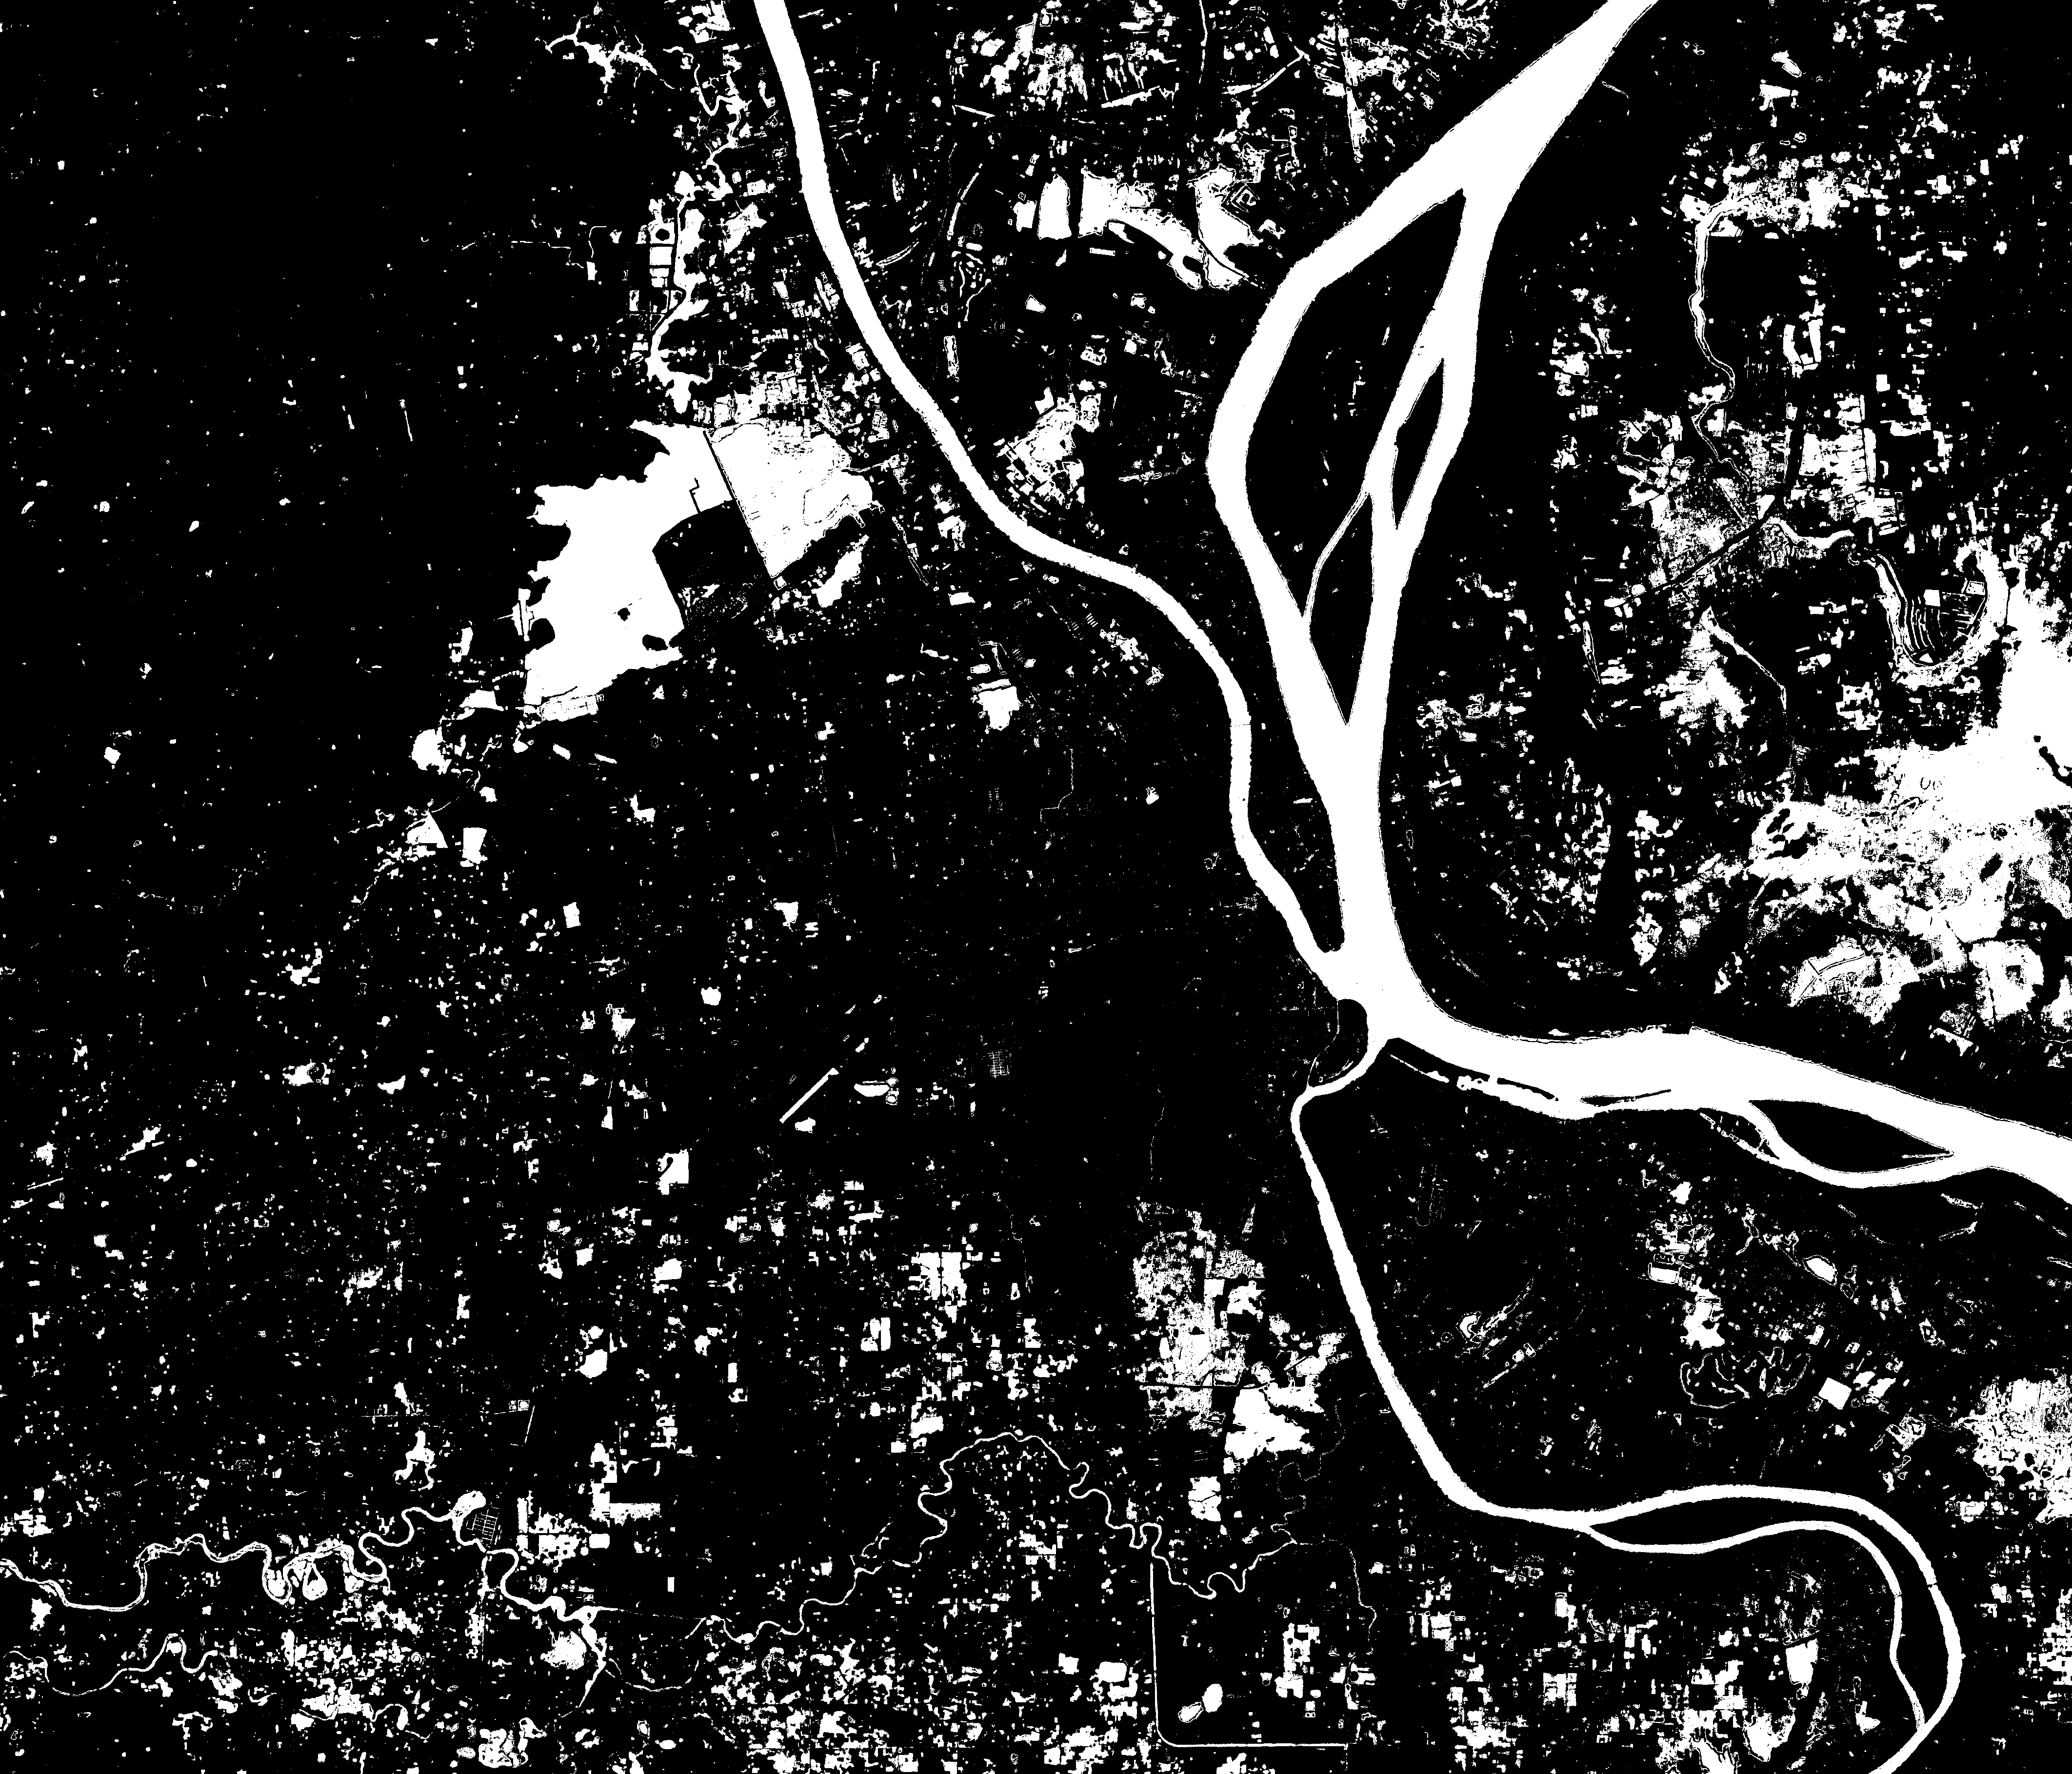

In [280]:
#To check the classification results, this code makes the binary image of the water class.
img_NN=Image.fromarray(255*(predicted_LULC_NN==4).astype(np.uint8))
img_NN

In [282]:
OutputFilePath_NN="./outputs/Classified_NN.tif"
with rio.open(OutputFilePath_NN,'w',driver='GTiff',width=ReadBand.width,height=ReadBand.height,count=1,crs=ReadBand.crs,transform=ReadBand.transform,dtype=np.uint8) as output:
    output.write(predicted_LULC_NN,1)
    output.close()

In [244]:
#Random Forest
trainData_RF=np.array(trainData)
testData_RF=np.array(testData)
trainLabel_RF=keras.utils.to_categorical(trainLabel)
testLabel_RF=keras.utils.to_categorical(testLabel)

clf_RF=RandomForestClassifier(n_estimators=100)
clf_RF.fit(trainData_RF,trainLabel_RF)
pred_test=clf_RF.predict(testData_RF)
acc=np.sum(np.argmax(pred_test,axis=1)==np.argmax(testLabel_RF,axis=1))/(np.argmax(pred_test,axis=1).size)
print("The classification accuracy is {:.4f}".format(acc))

The classification accuracy is 0.4225


In [153]:
predicted_LULC_RF=[]
column_length=S2Image[0].shape[1]


for i in tqdm(range(S2Image[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(NumOfBands):
        spectrum_data_at_row_i.append(S2Image[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class=clf_RF.predict(spectrum_data_at_row_i_T)
    predicted_LULC_RF.append(np.argmax(predicted_class,axis=1))

predicted_LULC_RF=np.array(predicted_LULC_RF).astype(np.uint8)

100%|██████████| 3638/3638 [09:25<00:00,  6.43it/s]  


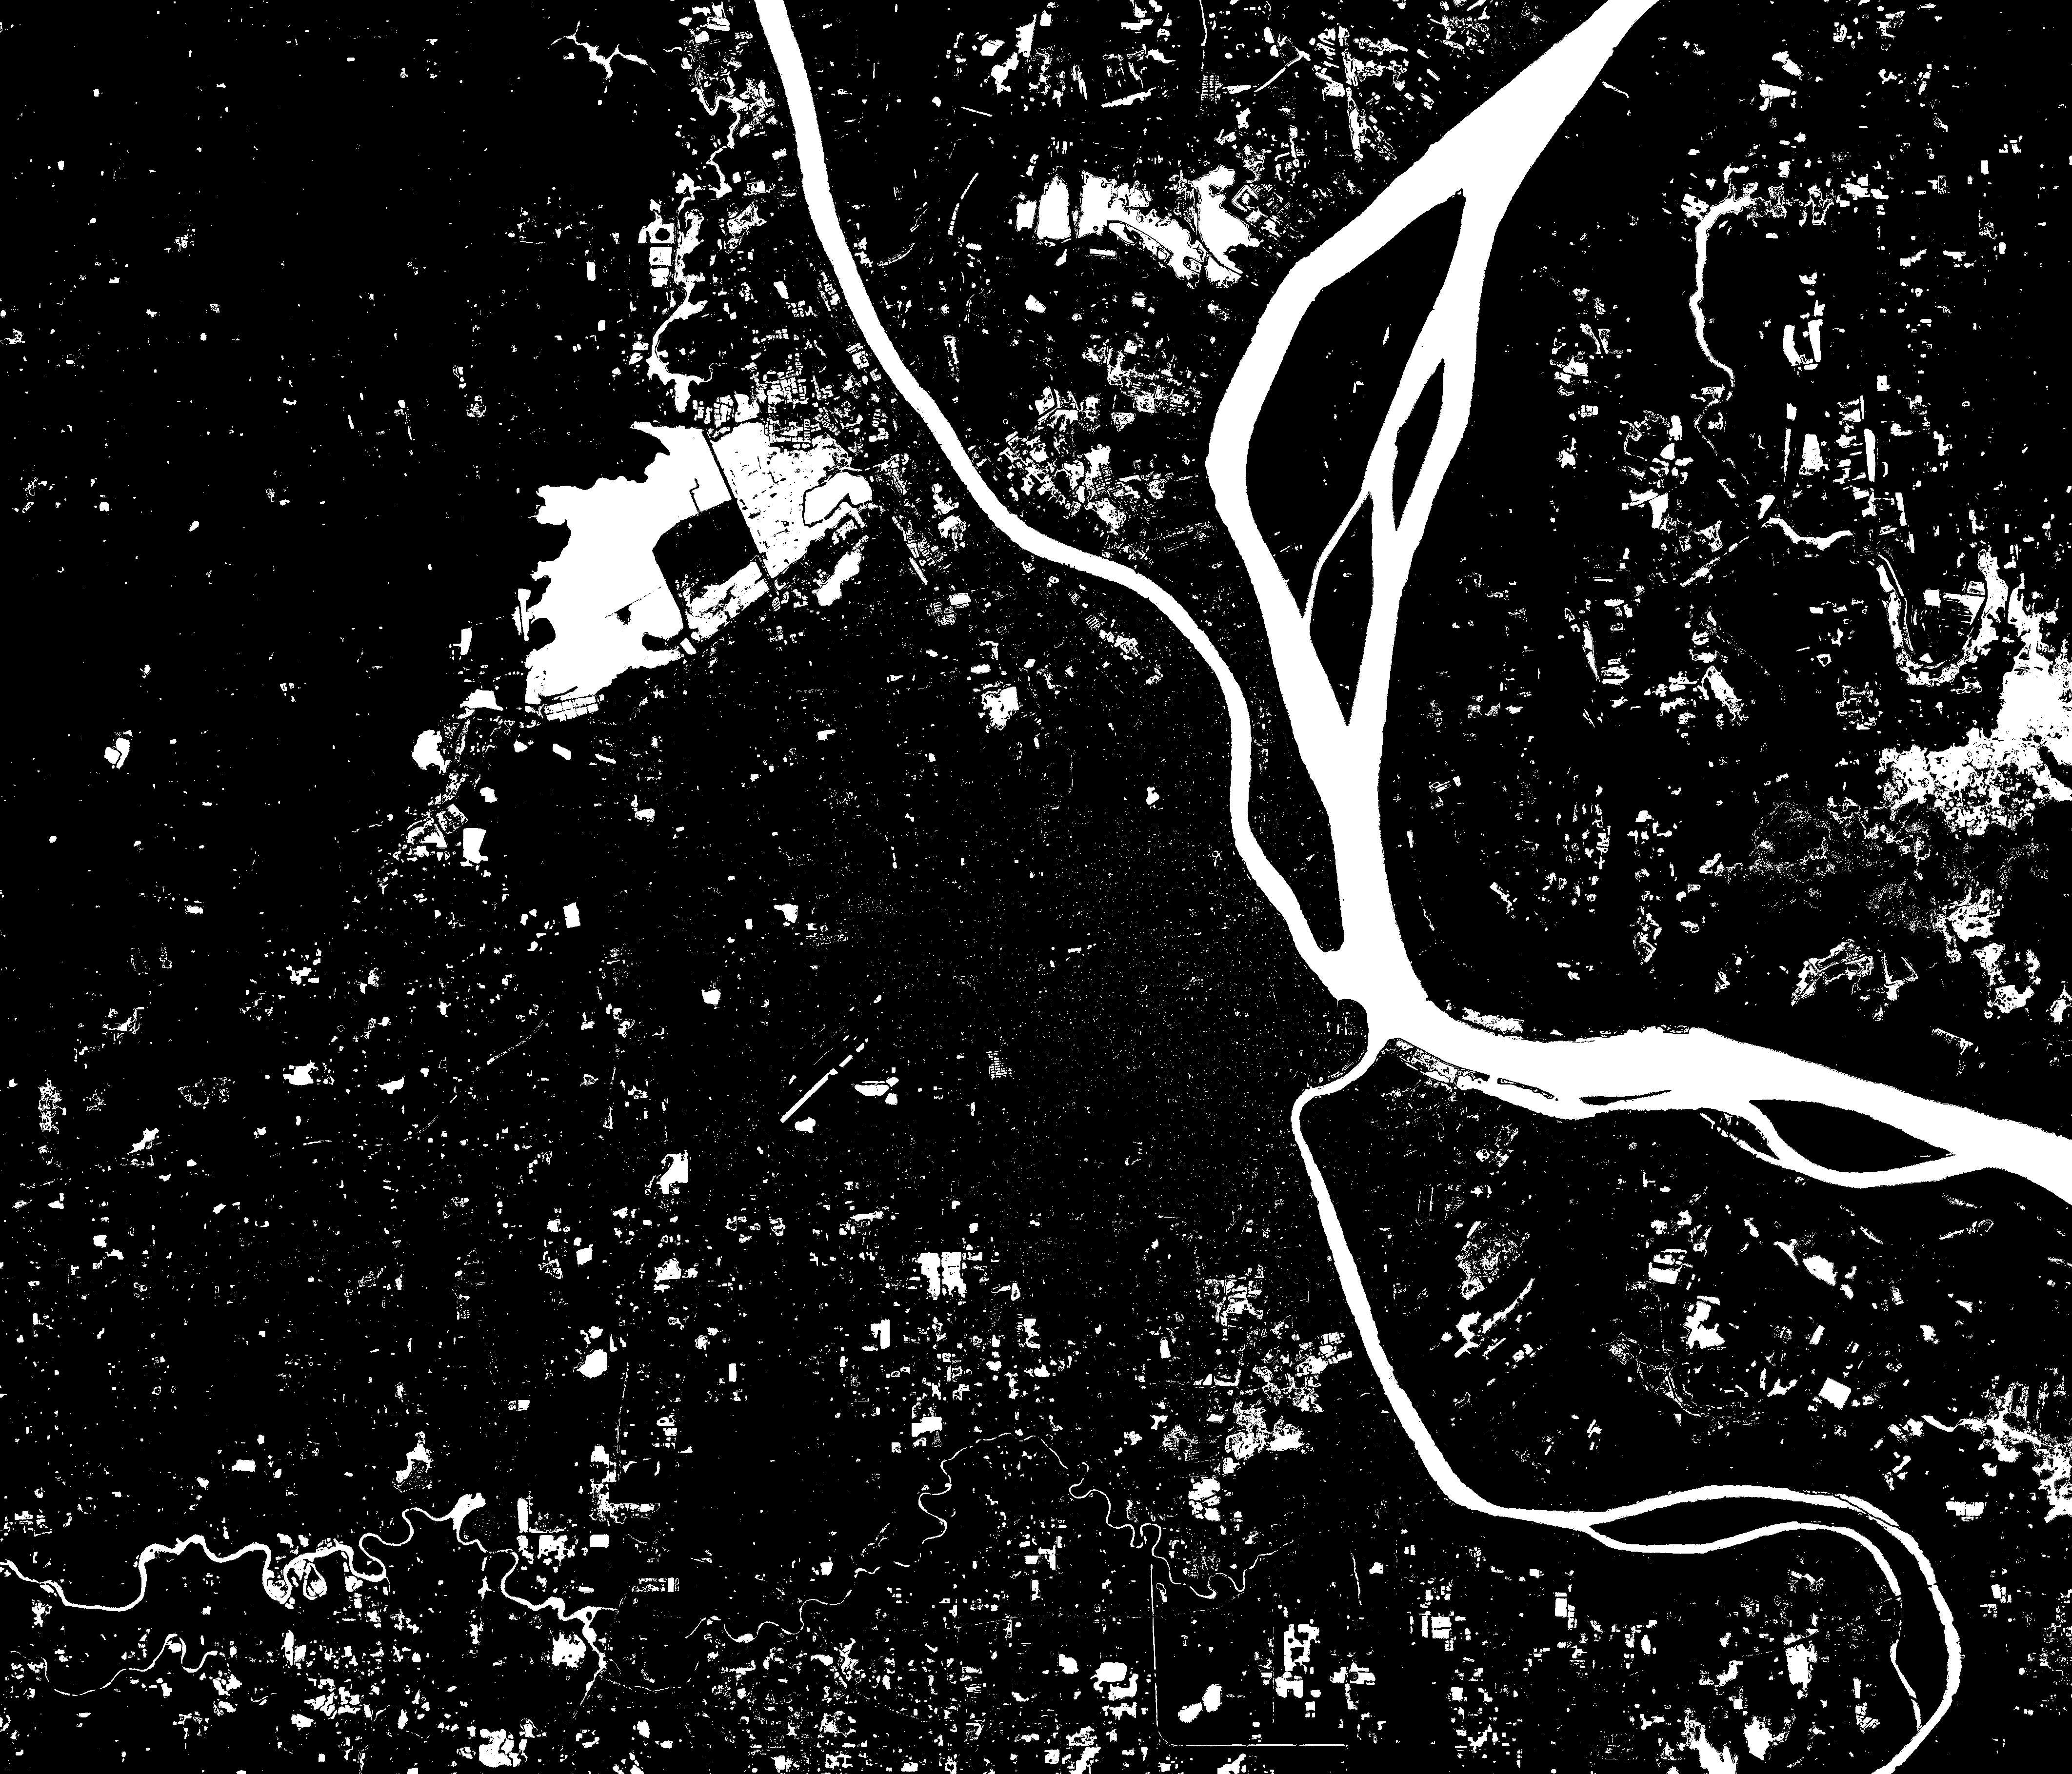

In [275]:
img_RF=Image.fromarray(255*(predicted_LULC_RF==4).astype(np.uint8))
img_RF


In [161]:
OutputFilePath_RF="./outputs/Classified_RF.tif"
with rio.open(OutputFilePath_RF,'w',driver='GTiff',width=ReadBand.width,height=ReadBand.height,count=1,crs=ReadBand.crs,transform=ReadBand.transform,dtype=np.uint8) as output:
    output.write(predicted_LULC_RF,1)
    output.close()

In [164]:
#SVM 

trainData_SVM=np.array(trainData)
testData_SVM=np.array(testData)
trainLabel_SVM=trainLabel
testLabel_SVM=testLabel

clf_SVM = SVC()    
clf_SVM.fit(trainData_SVM, trainLabel_SVM)

pred_test= clf_SVM.predict(testData_SVM)
acc=np.sum(pred_test==testLabel_SVM)/(pred_test.size)
print("The classification accuracy is {:.4f}".format(acc))

The classification accuracy is 0.5250


In [165]:
predicted_LULC_SVM=[]
column_length=S2Image[0].shape[1]


for i in tqdm(range(S2Image[0].shape[0])):
    spectrum_data_at_row_i=[]
    for m in range(NumOfBands):
        spectrum_data_at_row_i.append(S2Image[m][i])
    spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
    predicted_class=np.transpose(clf_SVM.predict(spectrum_data_at_row_i_T))
    predicted_LULC_SVM.append(predicted_class)

predicted_LULC_SVM=np.array(predicted_LULC_SVM).astype(np.uint8)

100%|██████████| 3638/3638 [14:58<00:00,  4.05it/s]


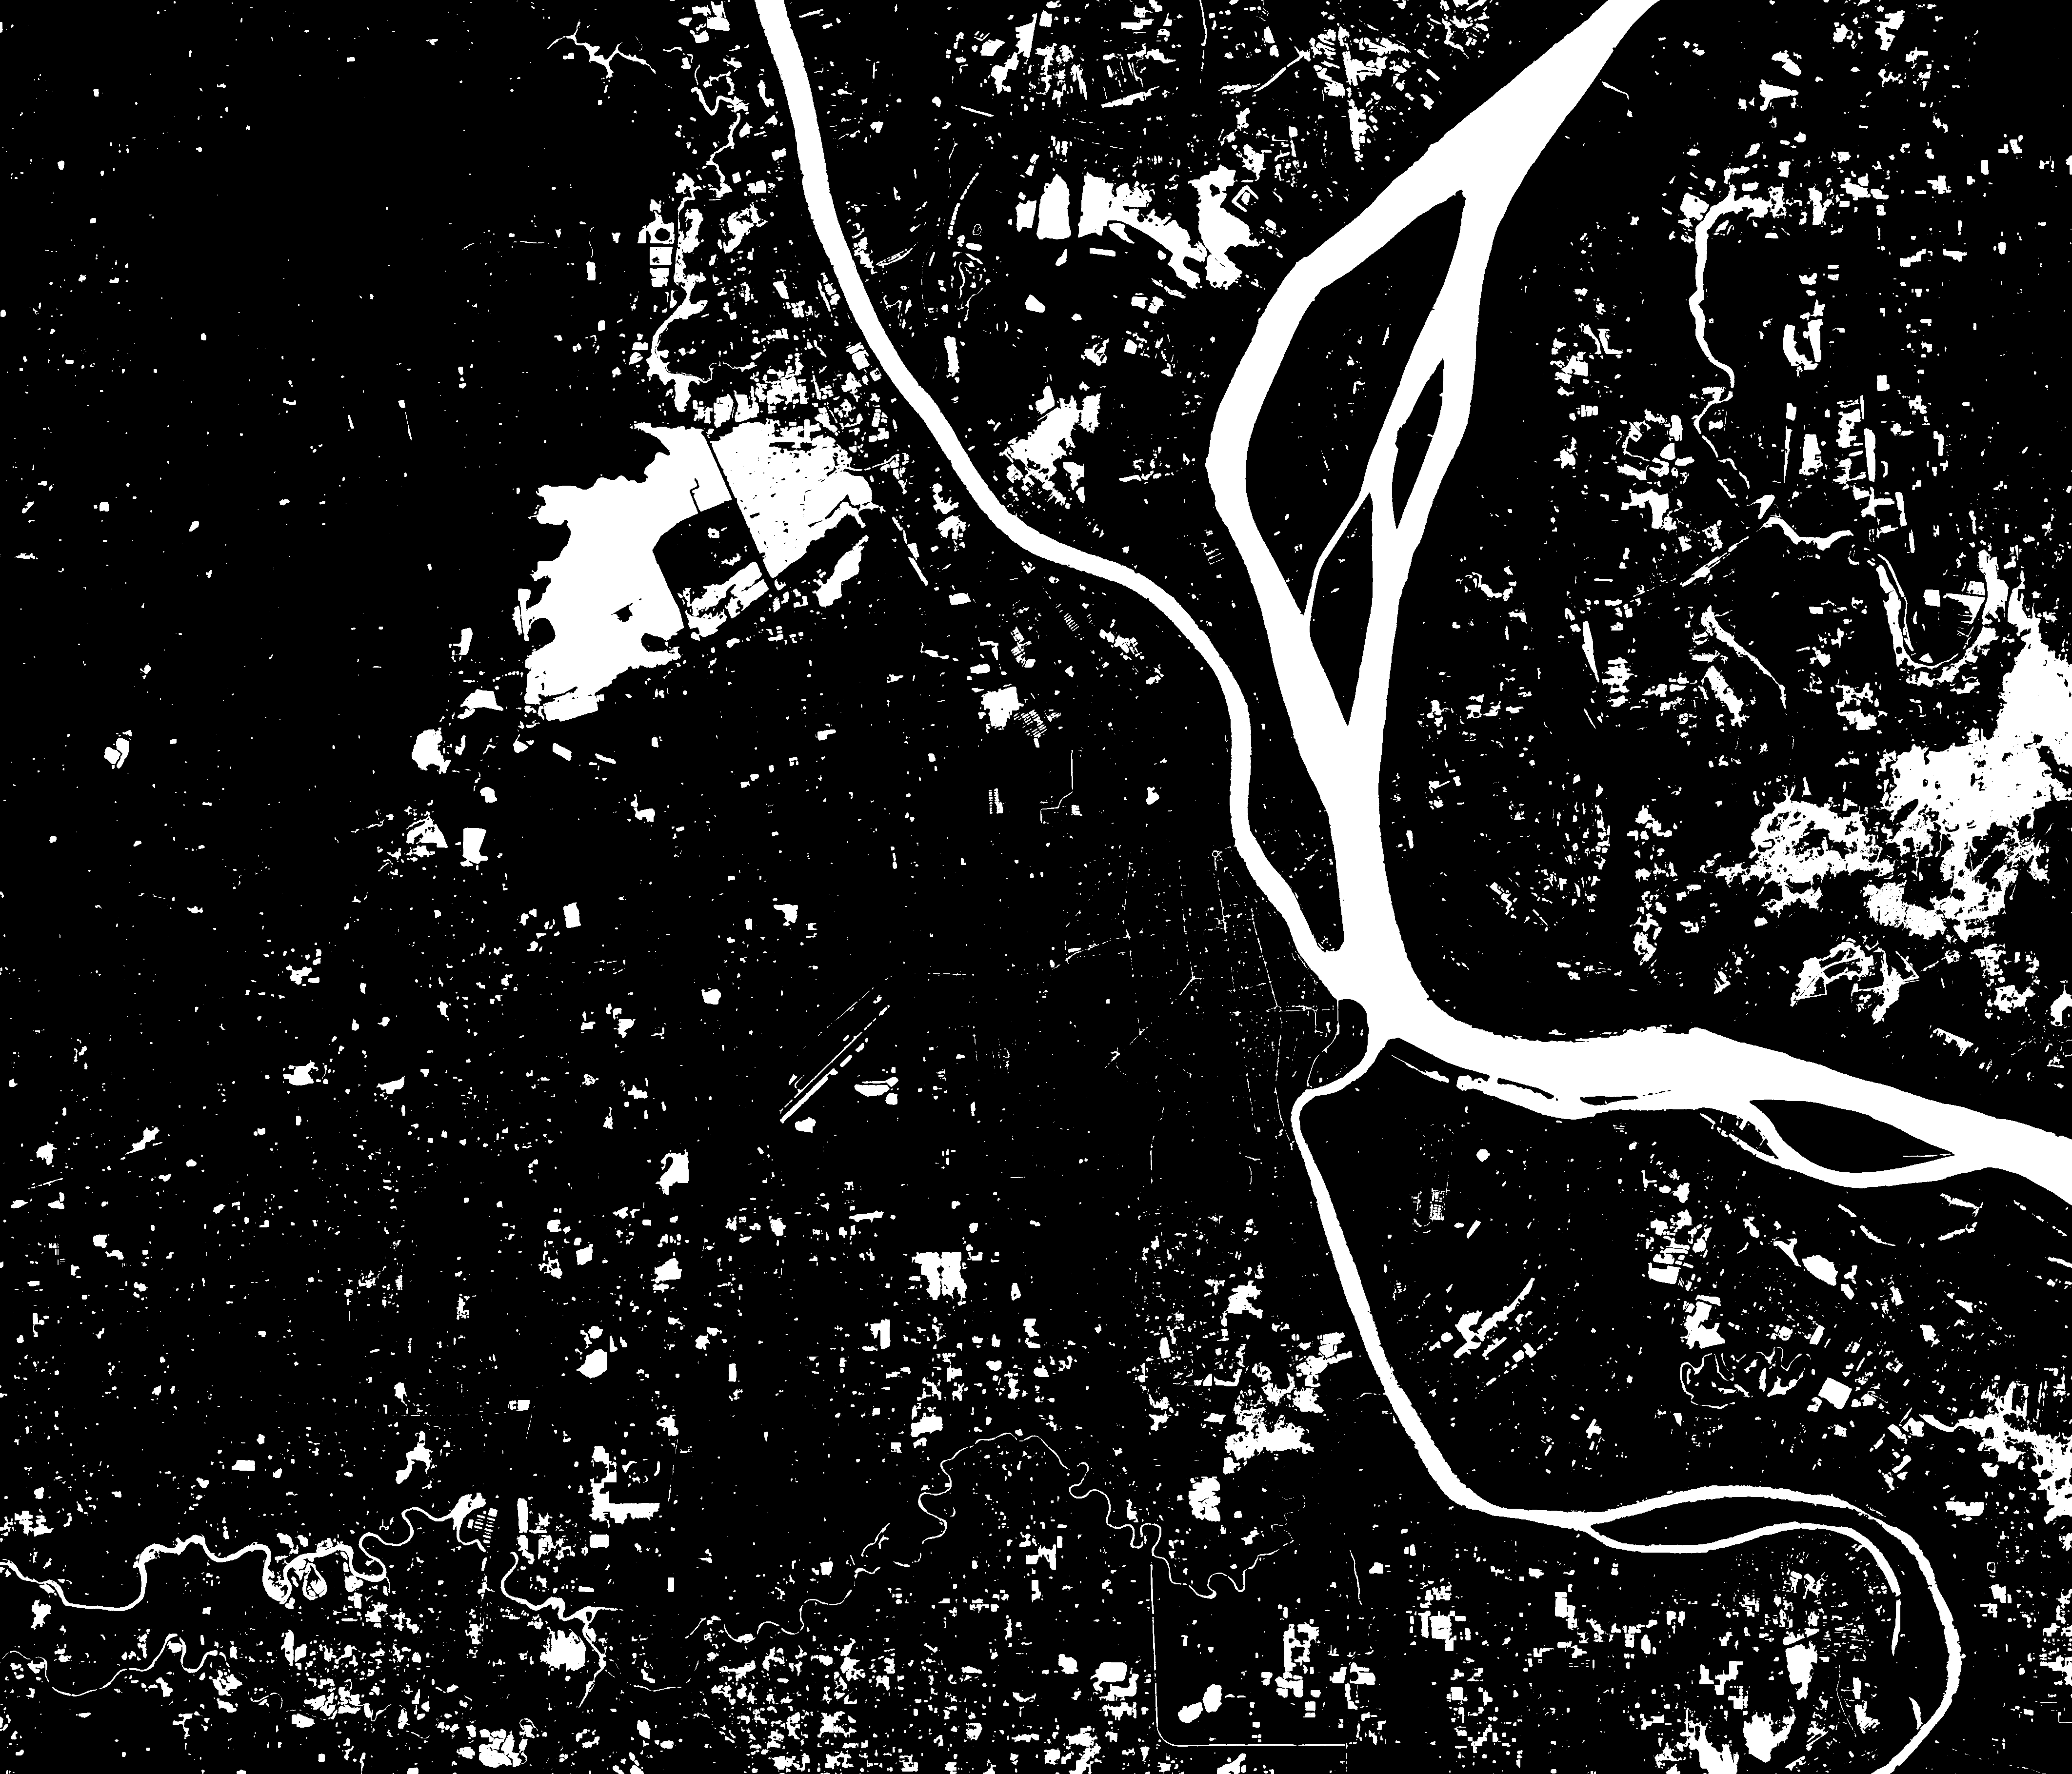

In [175]:
img_SVM=Image.fromarray(255*(predicted_LULC_SVM==4).astype(np.uint8))
img_SVM

In [176]:
OutputFilePath_SVM="./outputs/Classified_SVM.tif"
with rio.open(OutputFilePath_SVM,'w',driver='GTiff',width=ReadBand.width,height=ReadBand.height,count=1,crs=ReadBand.crs,transform=ReadBand.transform,dtype=np.uint8) as output:
    output.write(predicted_LULC_SVM,1)
    output.close()